In [0]:
# ============================================================
# CELL 1 — SETUP / LOAD / HELPERS (NEW STYLED VERSION)
# ============================================================

import os, io, math, json, textwrap

import pyspark.sql.functions as F
from pyspark.sql import Window
from pyspark.ml.feature import VectorAssembler, Bucketizer
from pyspark.ml.stat import Correlation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# -----------------------------
# DATA LOADING
# -----------------------------
PATH = "dbfs:/student-groups/Group_4_4/2015_final_feature_engineered_data_with_dep_delay"
df = spark.read.parquet(PATH)

otpw_full_df = df.cache()
otpw_3m_df = df.filter(
    (F.col("FL_DATE") >= F.lit("2015-01-01")) &
    (F.col("FL_DATE") <  F.lit("2015-04-01"))
).cache()

print(f"Full-year rows: {otpw_full_df.count():,}")
print(f"3-month rows:   {otpw_3m_df.count():,}")

TARGET_NUM = "DEP_DELAY"
TARGET_BIN = "DEP_DEL15"

# -----------------------------
# OUTPUT DIRECTORIES (MATCH NEW STYLE)
# -----------------------------
# Use /dbfs so images are directly readable as /files/...
CHARTS_DIR = "/dbfs/student-groups/Group_4_4/Charts/phase2"
os.makedirs(CHARTS_DIR, exist_ok=True)

print("Charts will save to:", CHARTS_DIR)

def save_fig(fig, filename):
    """
    Save figure directly to /dbfs Charts folder (no /tmp, no dbutils.fs.cp).
    """
    out_path = os.path.join(CHARTS_DIR, filename)
    fig.savefig(out_path, dpi=300, bbox_inches="tight", facecolor="white")
    plt.close(fig)
    print("saved:", out_path)
    return out_path

def save_pd(pd_df, filename):
    out_path = os.path.join(CHARTS_DIR, filename)
    pd_df.to_csv(out_path, index=False)
    print("saved:", out_path)
    return out_path

# -----------------------------
# FEATURE TYPE HELPERS
# -----------------------------
def get_numeric_cols(df_in, exclude=None):
    exclude = set(exclude) if exclude else set()
    return [
        c for c, t in df_in.dtypes
        if t in ("int", "bigint", "double", "float", "long") and c not in exclude
    ]

def get_categorical_cols(df_in, exclude=None, max_card=60):
    exclude = set(exclude) if exclude else set()
    cats = []
    for c, t in df_in.dtypes:
        if t == "string" and c not in exclude:
            card = df_in.select(c).distinct().count()
            if card <= max_card:
                cats.append(c)
    return cats

NUM_COLS = get_numeric_cols(df, exclude={TARGET_NUM, TARGET_BIN})
CAT_COLS = get_categorical_cols(df, exclude={TARGET_NUM, TARGET_BIN})
print("Numeric:", len(NUM_COLS), "Categorical:", len(CAT_COLS))

# ============================================================
# CELL 2 — GLOBAL PLOT STYLE (MATCH PHASE 2 EDA AESTHETICS)
# ============================================================

# -----------------------------
# COLOR PALETTE
# -----------------------------
COLORS = {
    "primary":   "#2E86AB",      # professional blue
    "secondary": "#A23B72",      # accent purple
    "success":   "#06A77D",      # on-time green
    "warning":   "#F18F01",      # delayed orange
    "danger":    "#D00000",      # high delays red
    "grid":      "#E8E8E8",      # light grid
    "text":      "#2D3142",      # dark text
    "background":"#FAFAFA",      # subtle background
    "gradient":  ["#2E86AB", "#5FA8D3", "#A23B72", "#F18F01", "#D00000"],
}

BAR_COLOR  = COLORS["warning"]   # orange bars
LINE_COLOR = COLORS["primary"]   # blue lines

# -----------------------------
# MATPLOTLIB DEFAULTS
# -----------------------------
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 300,
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],
    "axes.titlesize": 13,
    "axes.titleweight": "bold",
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "grid.linestyle": "-",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "legend.frameon": False,
})

# -----------------------------
# AXIS / LABEL HELPERS
# -----------------------------
def format_number(x, pos=None):
    """Format numbers with K/M suffixes for counts."""
    if x >= 1e6:
        return f"{x/1e6:.1f}M"
    elif x >= 1e3:
        return f"{x/1e3:.0f}K"
    return f"{int(x)}"

def style_axis(ax, title=None, xlabel=None, ylabel=None, format_y_km=True):
    """
    Consistent axis styling (used by new fancy notebook).
    """
    ax.set_facecolor(COLORS["background"])
    ax.grid(True, alpha=0.3, linestyle="-", linewidth=0.5, color=COLORS["grid"])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_color("#CCCCCC")
    ax.spines["bottom"].set_color("#CCCCCC")

    if title:
        ax.set_title(title, fontweight="bold", color=COLORS["text"], pad=10)
    if xlabel:
        ax.set_xlabel(xlabel, fontweight="semibold", color=COLORS["text"])
    if ylabel:
        ax.set_ylabel(ylabel, fontweight="semibold", color=COLORS["text"])

    if format_y_km:
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_number))

def styled_bar(ax, x, y, label=None, color=BAR_COLOR, alpha=0.85, **kwargs):
    return ax.bar(x, y, color=color, alpha=alpha, label=label, **kwargs)

def styled_line(ax, x, y, label=None, color=LINE_COLOR, marker="o", lw=2.5, **kwargs):
    return ax.plot(x, y, color=color, marker=marker, linewidth=lw, label=label, **kwargs)

def add_bar_labels(
    ax,
    bars,
    fmt="{:,.0f}",
    pad=0.02,
    rotation=90,
    fs=9,
    color="black",
    fontsize=None,
    **kwargs,
):
    """
    Backwards compatible:
      - old calls use fs=
      - new calls can use fontsize=
    """
    if fontsize is None:
        fontsize = fs

    ymax = ax.get_ylim()[1] if ax.get_ylim()[1] != 0 else 1
    for b in bars:
        h = b.get_height()
        if h <= 0:
            continue
        ax.text(
            b.get_x() + b.get_width() / 2,
            h + ymax * pad,
            fmt.format(h),
            ha="center",
            va="bottom",
            rotation=rotation,
            fontsize=fontsize,
            color=color,
        )

def add_line_labels(
    ax,
    x,
    y,
    every=2,
    fmt="{:.1f}%",
    fontsize=8,
    dy=0.6,
    color=LINE_COLOR,
    **kwargs,
):
    """Light labels on line points without clutter."""
    for i, (xi, yi) in enumerate(zip(x, y)):
        if i % every != 0:
            continue
        ax.text(
            xi,
            yi + dy,
            fmt.format(yi),
            ha="center",
            fontsize=fontsize,
            color=color,
        )

def finalize(ax, title=None, xlabel=None, ylabel=None, rotate_x=45):
    """
    Keep old signature, but align aesthetics with new style.
    """
    if title:
        ax.set_title(title, pad=10, color=COLORS["text"])
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    ax.tick_params(axis="x", rotation=rotate_x)
    ax.grid(True, axis="y", linestyle="--", alpha=0.25)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


from IPython.display import display  # put this once near the top of the notebook

# ============================================================
# CELL 3 — MISSINGNESS (ALL COLS) — NEW STYLING
# ============================================================

def plot_missingness_all(nulls_pd, title, filename):
    fig_h = max(10, len(nulls_pd) * 0.22)
    fig, ax = plt.subplots(figsize=(14, fig_h), facecolor="white")

    ax.barh(
        nulls_pd["column"],
        nulls_pd["null_pct"],
        color=BAR_COLOR,
        alpha=0.85
    )

    finalize(
        ax,
        title=title,
        xlabel="Missing (%)",
        ylabel="Feature",
        rotate_x=0
    )

    for i, v in enumerate(nulls_pd["null_pct"]):
        ax.text(v + 0.4, i, f"{v:.1f}%", fontsize=8, va="center")

    fig.tight_layout()

    # show in notebook
    display(fig)

    # save to /dbfs
    save_fig(fig, filename)


Full-year rows: 5,704,114
3-month rows:   1,354,285
Charts will save to: /dbfs/student-groups/Group_4_4/Charts/phase2
Numeric: 88 Categorical: 10


In [0]:
# quick DEP_DELAY sanity check
otpw_full_df.select(
    F.min("DEP_DELAY").alias("min"),
    F.max("DEP_DELAY").alias("max"),
    F.avg("DEP_DELAY").alias("mean"),
    F.expr("percentile(DEP_DELAY, 0.5)").alias("median")
).show()

otpw_full_df.select("DEP_DELAY").summary("count","min","25%","50%","75%","max").show()


+-----+------+-----------------+------+
|  min|   max|             mean|median|
+-----+------+-----------------+------+
|-82.0|1988.0|9.301552002642303|  -2.0|
+-----+------+-----------------+------+

+-------+---------+
|summary|DEP_DELAY|
+-------+---------+
|  count|  5704114|
|    min|    -82.0|
|    25%|     -5.0|
|    50%|     -2.0|
|    75%|      7.0|
|    max|   1988.0|
+-------+---------+



In [0]:
# ============================================================
# CELL — COMPUTE MISSINGNESS FOR FULL + 3M DATASETS
# ============================================================

def compute_missingness(df):
    total = df.count()
    miss = df.select([
        (F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)) / total).alias(c)
        for c in df.columns
    ]).toPandas().T.reset_index()
    miss.columns = ["column", "null_pct"]
    miss["null_pct"] = miss["null_pct"] * 100
    return miss.sort_values("null_pct", ascending=False)

# compute missingness
nulls_full = compute_missingness(otpw_full_df)
nulls_3m   = compute_missingness(otpw_3m_df)

print("Done computing missingness.")
print(nulls_full.head())


Done computing missingness.
                    column  null_pct
104              DEP_DELAY       0.0
89      wind_direction_cos       0.0
90   extreme_precipitation       0.0
91            extreme_wind       0.0
92     extreme_temperature       0.0


/root/.ipykernel/23289/command-7174456240422505-2726674419:270: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


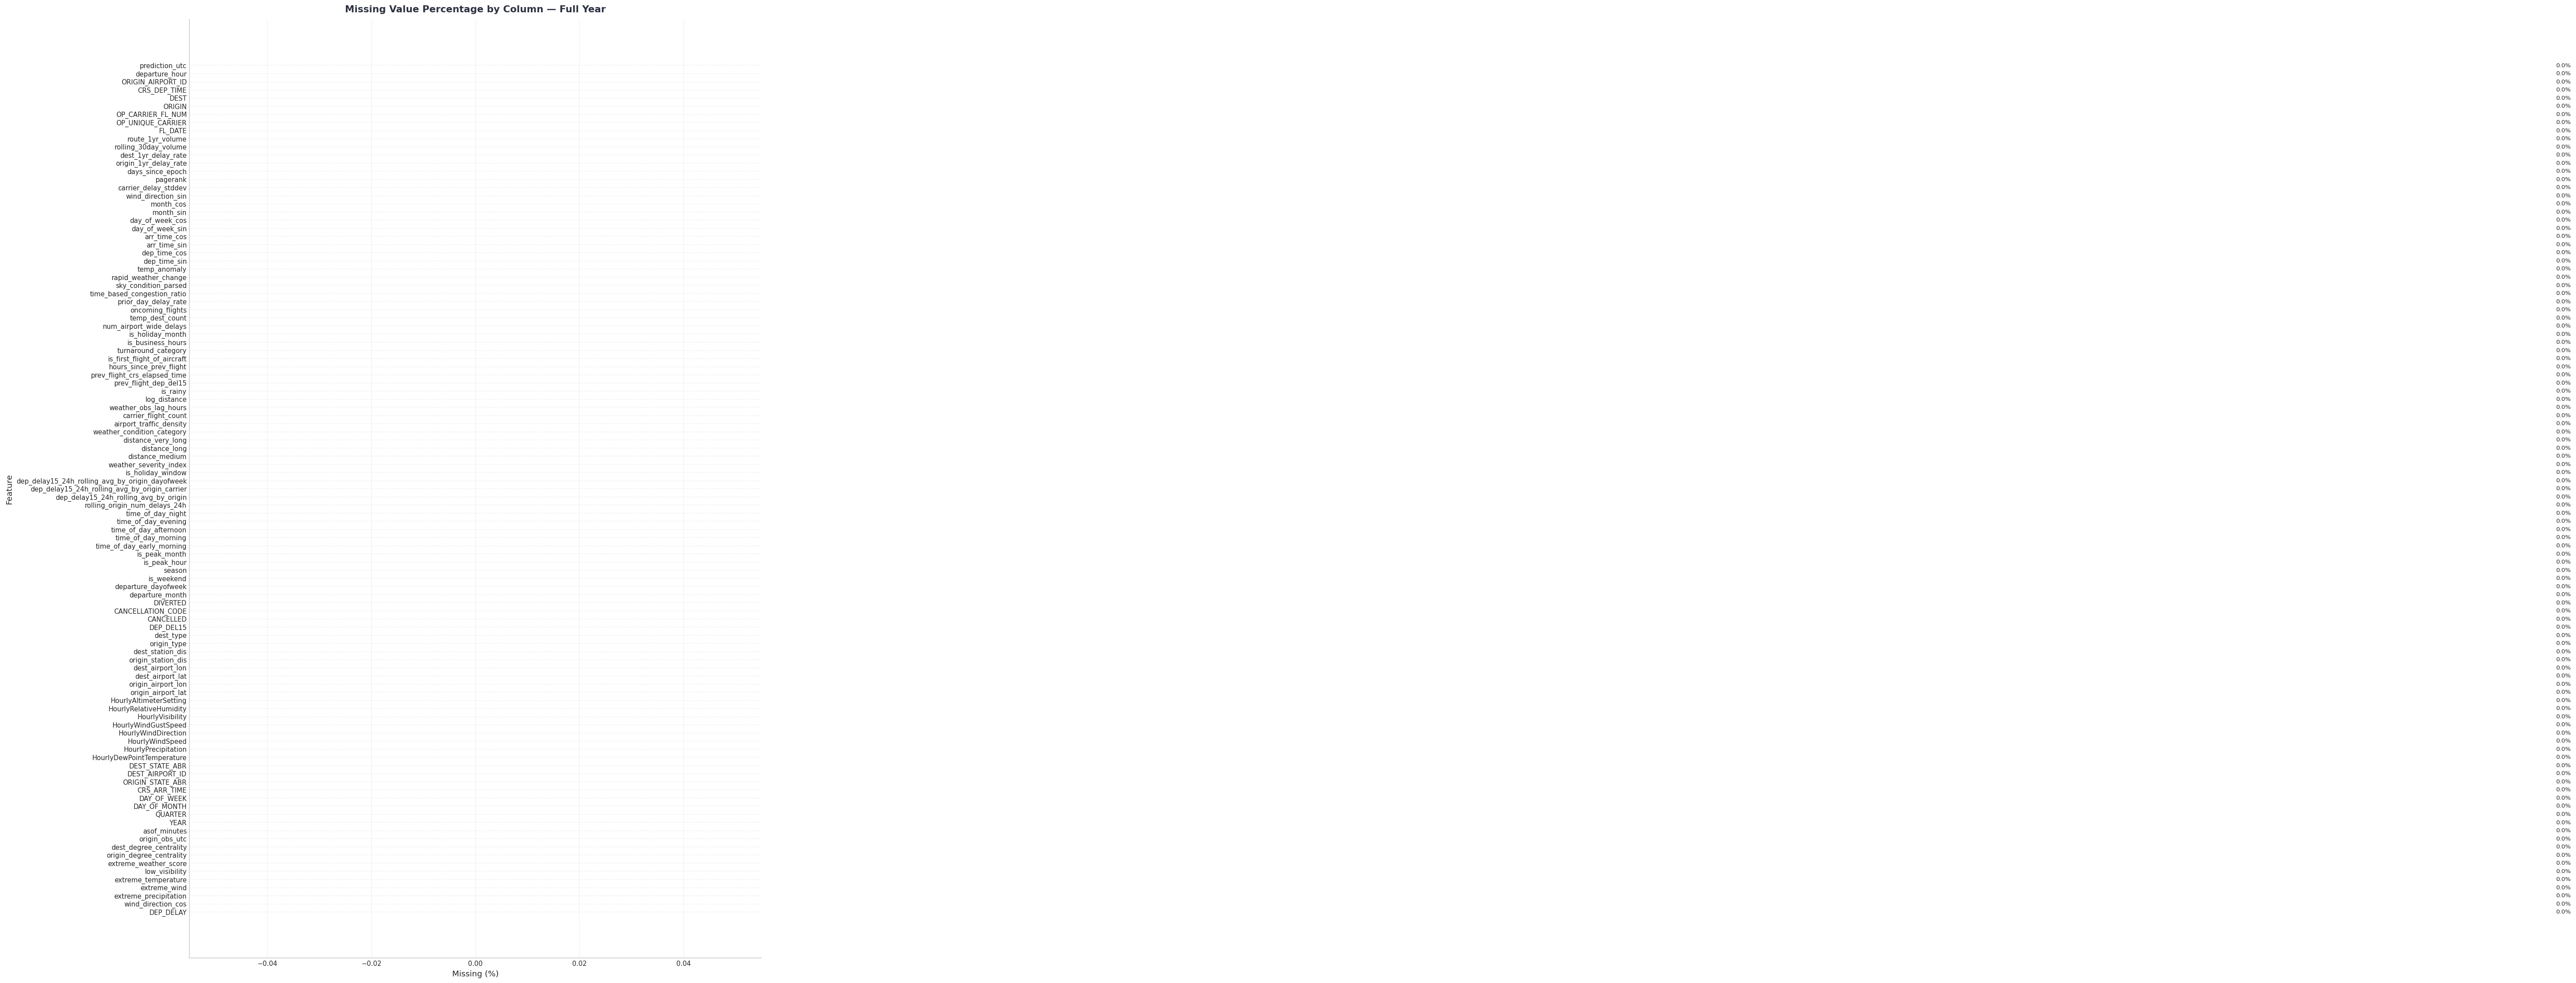

saved: /dbfs/student-groups/Group_4_4/Charts/phase2/missing_value_percentage_by_column_full.png


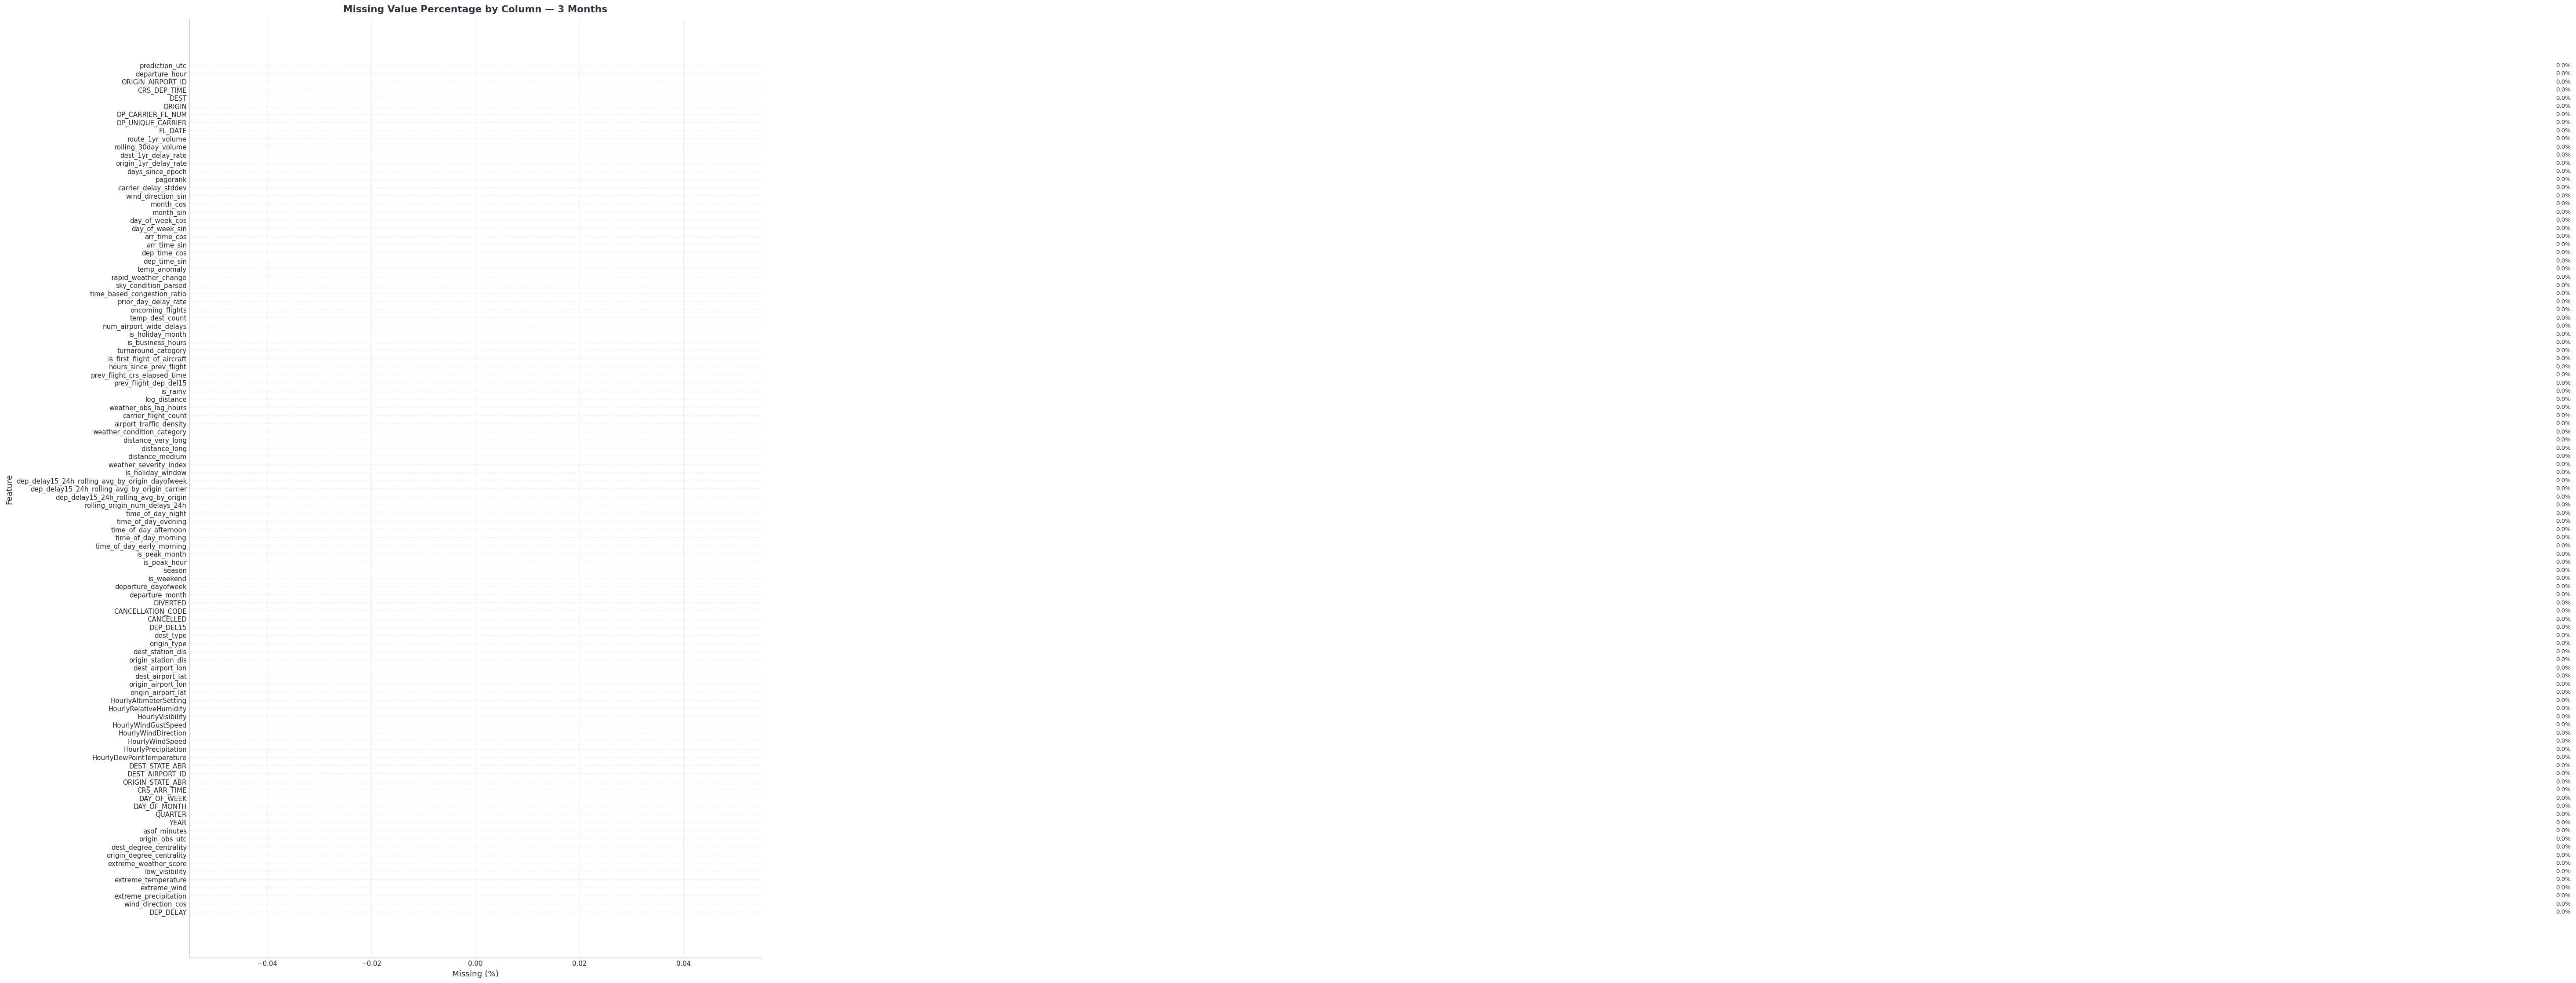

saved: /dbfs/student-groups/Group_4_4/Charts/phase2/missing_value_percentage_by_column_3m.png


In [0]:
plot_missingness_all(nulls_full, "Missing Value Percentage by Column — Full Year",
                     "missing_value_percentage_by_column_full.png")

plot_missingness_all(nulls_3m, "Missing Value Percentage by Column — 3 Months",
                     "missing_value_percentage_by_column_3m.png")


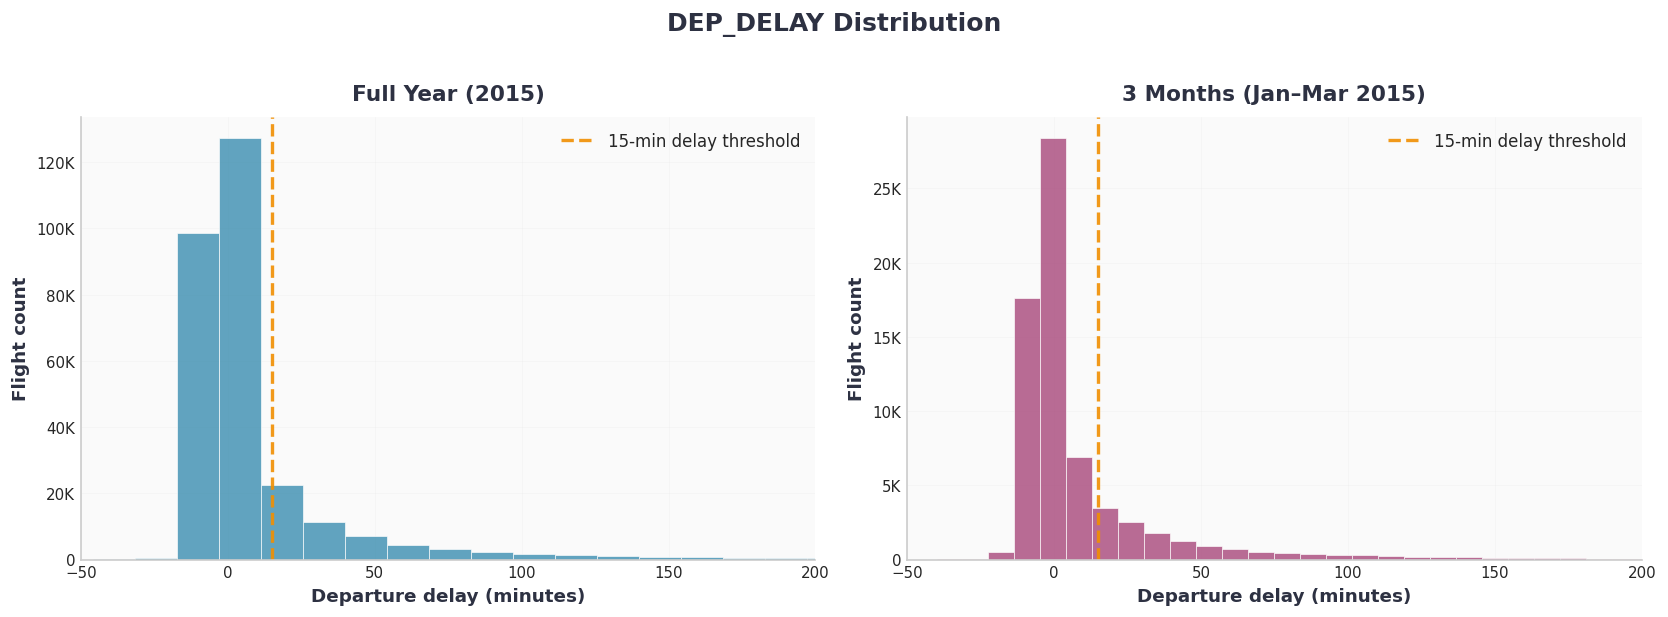

saved: /dbfs/student-groups/Group_4_4/Charts/phase2/dep_delay_distribution_combined_full_vs_3m.png


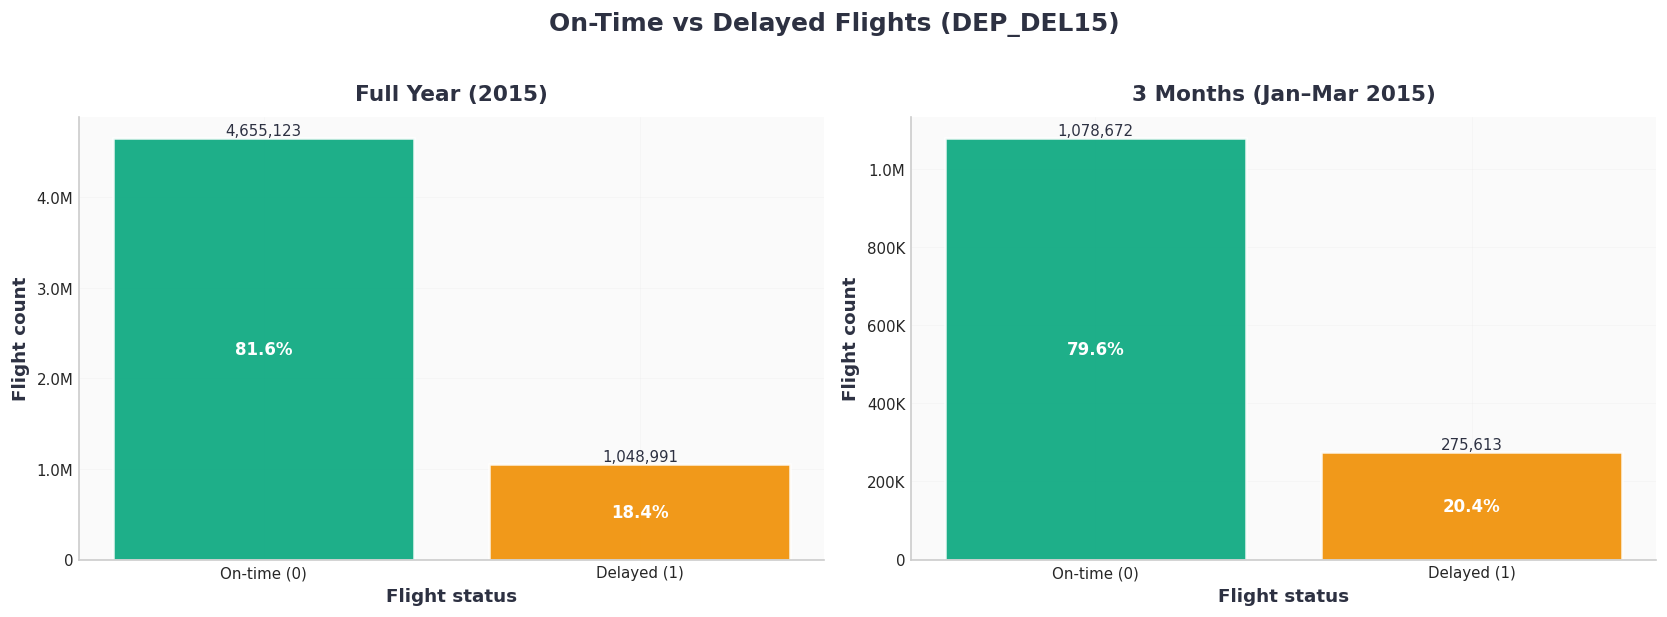

saved: /dbfs/student-groups/Group_4_4/Charts/phase2/dep_del15_balance_combined_full_vs_3m.png
Target distribution cell complete (combined).


In [0]:
# ============================================================
#  TARGET DISTRIBUTIONS (Combined + Styled)
#   - DEP_DELAY hist (Full vs 3M)
#   - DEP_DEL15 balance (Full vs 3M)
# ============================================================

def plot_dep_delay_hist_combined(df_full, df_3m, filename, sample_frac=0.05, bins=120):
    """
    Side-by-side histograms of DEP_DELAY for:
      - full year
      - 3-month sample
    Uses Phase 2 colors + styling and adds 15-minute delay threshold line.
    """
    # Sample so plotting stays fast
    pd_full = (
        df_full.select(TARGET_NUM)
               .dropna()
               .sample(sample_frac, seed=42)
               .toPandas()
    )
    pd_3m = (
        df_3m.select(TARGET_NUM)
             .dropna()
             .sample(sample_frac, seed=42)
             .toPandas()
    )

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), facecolor="white")

    # ---------------- Full year ----------------
    ax1 = axes[0]
    ax1.hist(
        pd_full[TARGET_NUM],
        bins=bins,
        color=COLORS["primary"],
        alpha=0.75,
        edgecolor="white",
        linewidth=0.5,
    )
    ax1.axvline(
        x=15,
        color=COLORS["warning"],
        linestyle="--",
        linewidth=2,
        label="15-min delay threshold",
        alpha=0.9,
    )
    style_axis(
        ax1,
        title="Full Year (2015)",
        xlabel="Departure delay (minutes)",
        ylabel="Flight count",
        format_y_km=True,
    )
    ax1.set_xlim(-50, 200)
    ax1.legend(loc="upper right", framealpha=0.9)

    # ---------------- 3-month sample ----------------
    ax2 = axes[1]
    ax2.hist(
        pd_3m[TARGET_NUM],
        bins=bins,
        color=COLORS["secondary"],
        alpha=0.75,
        edgecolor="white",
        linewidth=0.5,
    )
    ax2.axvline(
        x=15,
        color=COLORS["warning"],
        linestyle="--",
        linewidth=2,
        label="15-min delay threshold",
        alpha=0.9,
    )
    style_axis(
        ax2,
        title="3 Months (Jan–Mar 2015)",
        xlabel="Departure delay (minutes)",
        ylabel="Flight count",
        format_y_km=True,
    )
    ax2.set_xlim(-50, 200)
    ax2.legend(loc="upper right", framealpha=0.9)

    fig.suptitle("DEP_DELAY Distribution", fontsize=15, fontweight="bold", color=COLORS["text"], y=1.02)
    fig.tight_layout()

    # show + save
    display(fig)
    save_fig(fig, filename)


def plot_dep_del15_balance_combined(df_full, df_3m, filename):
    """
    Side-by-side bar charts for DEP_DEL15 class balance:
      - 0 = on time
      - 1 = delayed
    Uses green/orange colors and adds count + percentage labels.
    """
    pdf_full = (
        df_full.groupBy(TARGET_BIN)
               .count()
               .orderBy(TARGET_BIN)
               .toPandas()
    )
    pdf_3m = (
        df_3m.groupBy(TARGET_BIN)
             .count()
             .orderBy(TARGET_BIN)
             .toPandas()
    )

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), facecolor="white")

    labels = ["On-time (0)", "Delayed (1)"]
    bar_colors = [COLORS["success"], COLORS["warning"]]

    # ---------------- Full year ----------------
    ax1 = axes[0]
    x_pos = np.arange(len(pdf_full))
    bars1 = ax1.bar(
        x_pos,
        pdf_full["count"],
        color=bar_colors,
        alpha=0.9,
        edgecolor="white",
        linewidth=1.5,
    )

    total_full = pdf_full["count"].sum()
    for i, (bar, count) in enumerate(zip(bars1, pdf_full["count"])):
        pct = (count / total_full) * 100
        # count above bar
        ax1.text(
            bar.get_x() + bar.get_width() / 2,
            count,
            f"{int(count):,}",
            ha="center",
            va="bottom",
            fontsize=9,
            color=COLORS["text"],
        )
        # percentage inside bar
        ax1.text(
            bar.get_x() + bar.get_width() / 2,
            count * 0.5,
            f"{pct:.1f}%",
            ha="center",
            va="center",
            fontsize=10,
            fontweight="bold",
            color="white",
        )

    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(labels)
    style_axis(
        ax1,
        title="Full Year (2015)",
        xlabel="Flight status",
        ylabel="Flight count",
        format_y_km=True,
    )

    # ---------------- 3-month sample ----------------
    ax2 = axes[1]
    x_pos2 = np.arange(len(pdf_3m))
    bars2 = ax2.bar(
        x_pos2,
        pdf_3m["count"],
        color=bar_colors,
        alpha=0.9,
        edgecolor="white",
        linewidth=1.5,
    )

    total_3m = pdf_3m["count"].sum()
    for i, (bar, count) in enumerate(zip(bars2, pdf_3m["count"])):
        pct = (count / total_3m) * 100
        ax2.text(
            bar.get_x() + bar.get_width() / 2,
            count,
            f"{int(count):,}",
            ha="center",
            va="bottom",
            fontsize=9,
            color=COLORS["text"],
        )
        ax2.text(
            bar.get_x() + bar.get_width() / 2,
            count * 0.5,
            f"{pct:.1f}%",
            ha="center",
            va="center",
            fontsize=10,
            fontweight="bold",
            color="white",
        )

    ax2.set_xticks(x_pos2)
    ax2.set_xticklabels(labels)
    style_axis(
        ax2,
        title="3 Months (Jan–Mar 2015)",
        xlabel="Flight status",
        ylabel="Flight count",
        format_y_km=True,
    )

    fig.suptitle(
        "On-Time vs Delayed Flights (DEP_DEL15)",
        fontsize=15,
        fontweight="bold",
        color=COLORS["text"],
        y=1.02,
    )
    fig.tight_layout()

    # show + save
    display(fig)
    save_fig(fig, filename)


# ------------------------------------------------------------
# Generate + save BOTH combined charts
# ------------------------------------------------------------
plot_dep_delay_hist_combined(
    otpw_full_df,
    otpw_3m_df,
    "dep_delay_distribution_combined_full_vs_3m.png"
)

plot_dep_del15_balance_combined(
    otpw_full_df,
    otpw_3m_df,
    "dep_del15_balance_combined_full_vs_3m.png"
)

print("Target distribution cell complete (combined).")


In [0]:
# ============================================================
# CELL 4 — FLIGHT COUNT BY CARRIER (Styled)
# ============================================================

def plot_flight_count_by_carrier(df_in, title, filename, top_k=15):
    # Aggregate carrier counts
    pd_c = (
        df_in.groupBy("OP_UNIQUE_CARRIER")
             .count()
             .orderBy(F.desc("count"))
             .limit(top_k)
             .toPandas()
    )

    fig, ax = plt.subplots(figsize=(10, 5))

    # Styled orange bars
    styled_bar(
        ax,
        pd_c["OP_UNIQUE_CARRIER"],
        pd_c["count"],
        color=BAR_COLOR
    )

    # Standardize labels, title, and axis rotation
    finalize(
        ax,
        title=title,
        xlabel="Carrier",
        ylabel="Flight count",
        rotate_x=45
    )

    # Add value labels above bars
    for i, v in enumerate(pd_c["count"]):
        ax.text(
            i, 
            v + (v * 0.015), 
            f"{v:,}",
            ha="center",
            fontsize=9
        )

    fig.tight_layout()
    return save_fig(fig, filename)


# -------------------------------
# Generate both charts
# -------------------------------
plot_flight_count_by_carrier(
    otpw_full_df,
    "Flight Count by Operating Carrier — Full Year",
    "flight_count_by_operating_carrier_full.png"
)

plot_flight_count_by_carrier(
    otpw_3m_df,
    "Flight Count by Operating Carrier — 3 Months",
    "flight_count_by_operating_carrier_3m.png"
)


saved: /dbfs/student-groups/Group_4_4/Charts/phase2/flight_count_by_operating_carrier_full.png
saved: /dbfs/student-groups/Group_4_4/Charts/phase2/flight_count_by_operating_carrier_3m.png


'/dbfs/student-groups/Group_4_4/Charts/phase2/flight_count_by_operating_carrier_3m.png'

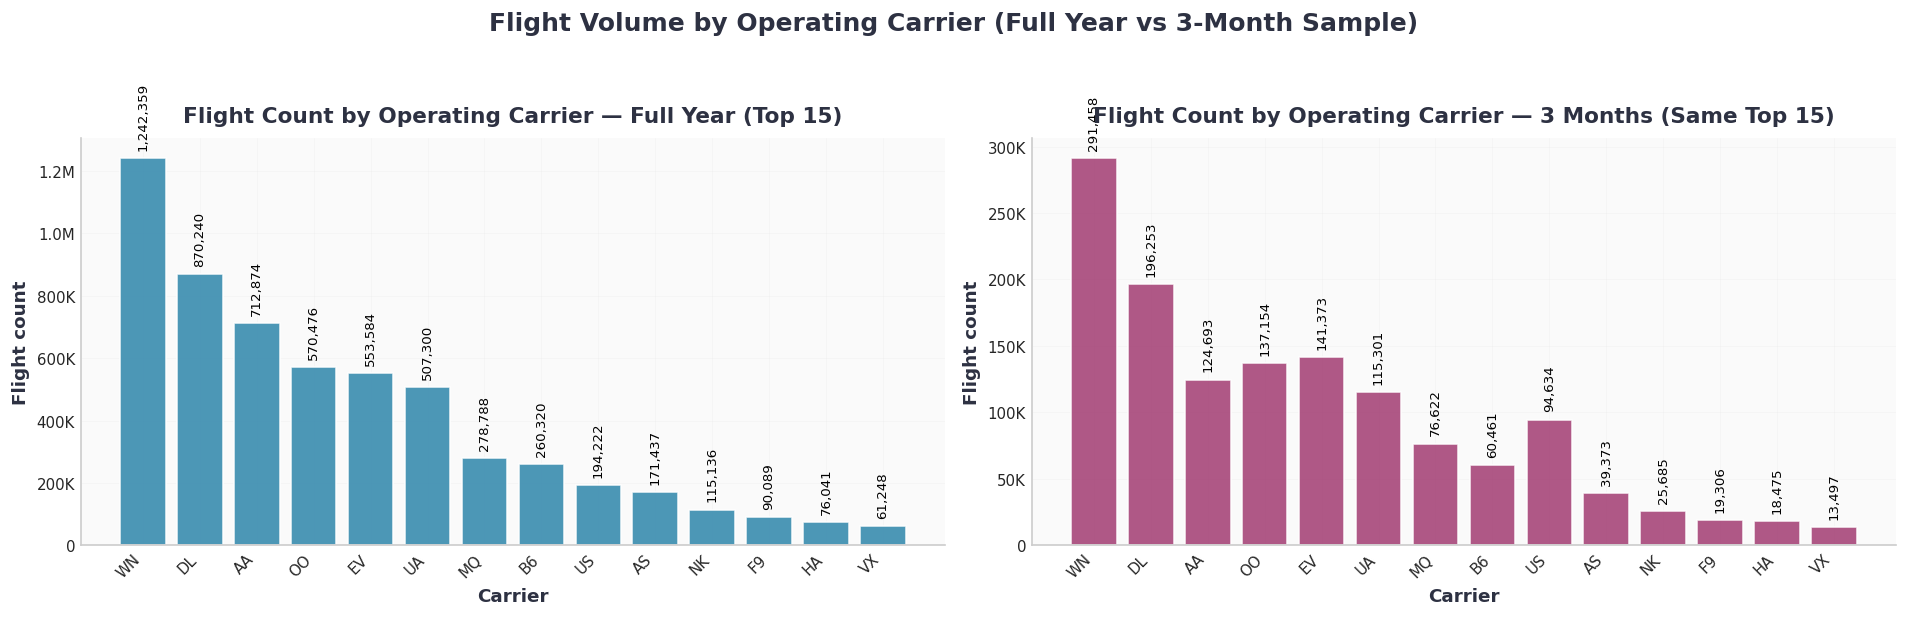

saved: /dbfs/student-groups/Group_4_4/Charts/phase2/flight_count_by_operating_carrier_combined_full_vs_3m.png


In [0]:
# ============================================================
# CELL 4 — FLIGHT COUNT BY CARRIER (Combined + Styled)
# ============================================================

def plot_flight_count_by_carrier_combined(df_full, df_3m, filename, top_k=15):
    """
    Side-by-side bar charts of flight count by carrier:
      - Left: full year (top_k carriers by volume)
      - Right: same carriers in 3-month window
    Styled to match target distribution visuals.
    """
    # ---- Get top_k carriers by volume from full-year ----
    pd_full = (
        df_full.groupBy("OP_UNIQUE_CARRIER")
               .count()
               .orderBy(F.desc("count"))
               .limit(top_k)
               .toPandas()
    )

    top_carriers = pd_full["OP_UNIQUE_CARRIER"].tolist()

    # ---- 3-month counts, restricted to same carriers ----
    pd_3m = (
        df_3m.groupBy("OP_UNIQUE_CARRIER")
             .count()
             .where(F.col("OP_UNIQUE_CARRIER").isin(top_carriers))
             .toPandas()
    )

    # Align 3m in same carrier order
    pd_3m = pd_3m.set_index("OP_UNIQUE_CARRIER").reindex(top_carriers).fillna(0).reset_index()

    fig, axes = plt.subplots(1, 2, figsize=(16, 5), facecolor="white")

    # ===================== LEFT: FULL YEAR =====================
    ax1 = axes[0]
    x_pos1 = np.arange(len(pd_full))
    bars1 = ax1.bar(
        x_pos1,
        pd_full["count"],
        color=COLORS["primary"],
        alpha=0.85,
        edgecolor="white",
        linewidth=1,
    )

    style_axis(
        ax1,
        title="Flight Count by Operating Carrier — Full Year (Top 15)",
        xlabel="Carrier",
        ylabel="Flight count",
        format_y_km=True,
    )
    ax1.set_xticks(x_pos1)
    ax1.set_xticklabels(pd_full["OP_UNIQUE_CARRIER"], rotation=45, ha="right")

    add_bar_labels(
        ax1,
        bars1,
        fmt="{:,.0f}",
        pad=0.02,
        rotation=90,
        fontsize=8,
    )

    # ===================== RIGHT: 3-MONTH WINDOW =====================
    ax2 = axes[1]
    x_pos2 = np.arange(len(pd_3m))
    bars2 = ax2.bar(
        x_pos2,
        pd_3m["count"],
        color=COLORS["secondary"],
        alpha=0.85,
        edgecolor="white",
        linewidth=1,
    )

    style_axis(
        ax2,
        title="Flight Count by Operating Carrier — 3 Months (Same Top 15)",
        xlabel="Carrier",
        ylabel="Flight count",
        format_y_km=True,
    )
    ax2.set_xticks(x_pos2)
    ax2.set_xticklabels(pd_3m["OP_UNIQUE_CARRIER"], rotation=45, ha="right")

    add_bar_labels(
        ax2,
        bars2,
        fmt="{:,.0f}",
        pad=0.02,
        rotation=90,
        fontsize=8,
    )

    fig.suptitle(
        "Flight Volume by Operating Carrier (Full Year vs 3-Month Sample)",
        fontsize=15,
        fontweight="bold",
        color=COLORS["text"],
        y=1.02,
    )
    fig.tight_layout()

    display(fig)
    save_fig(fig, filename)


# -------------------------------
# Generate combined chart
# -------------------------------
plot_flight_count_by_carrier_combined(
    otpw_full_df,
    otpw_3m_df,
    "flight_count_by_operating_carrier_combined_full_vs_3m.png"
)


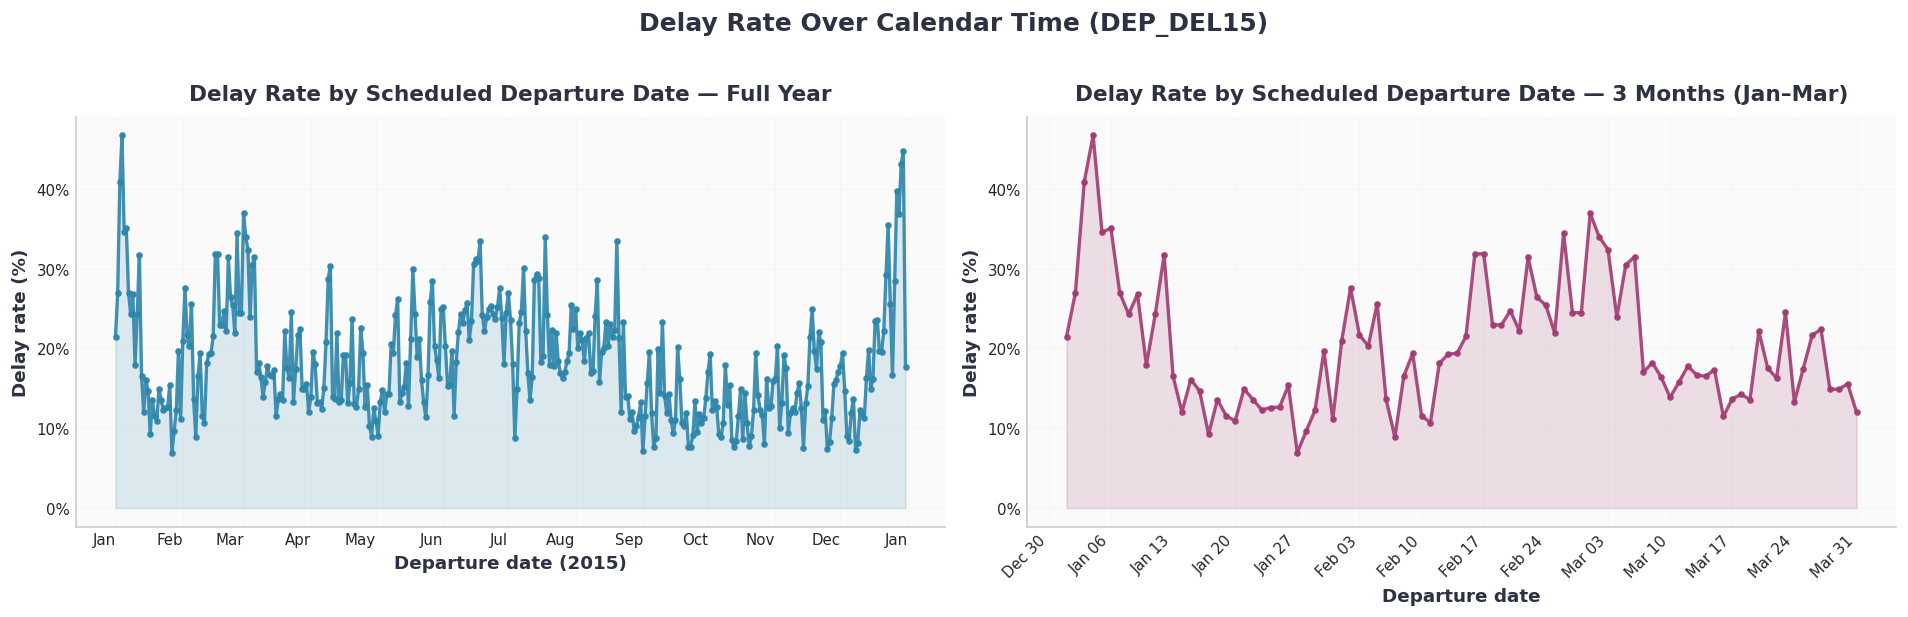

saved: /dbfs/student-groups/Group_4_4/Charts/phase2/delay_rate_by_scheduled_departure_date_combined_full_vs_3m.png


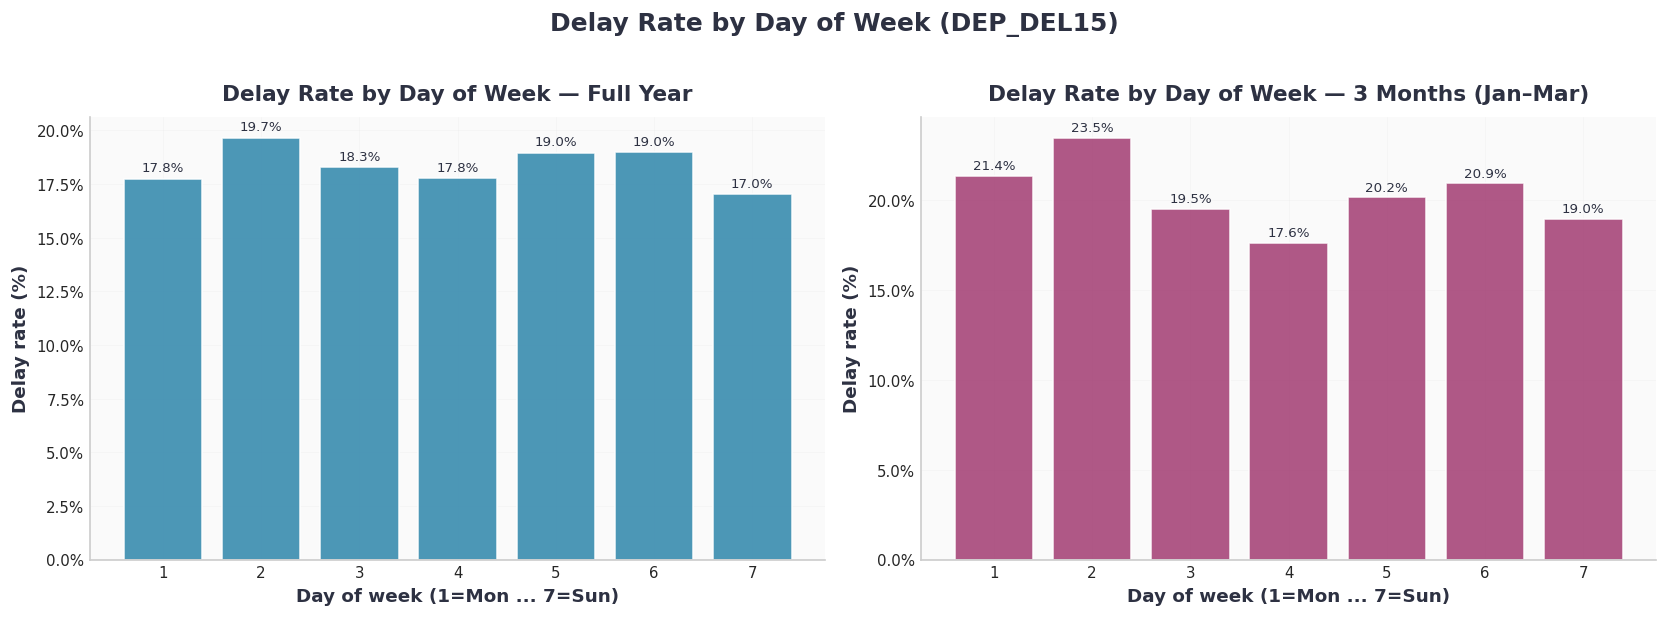

saved: /dbfs/student-groups/Group_4_4/Charts/phase2/delay_rate_by_day_of_week_combined_full_vs_3m.png
Cell 5 complete (combined delay patterns).


In [0]:
# ============================================================
# CELL 5 — DELAY PATTERNS OVER TIME (Combined + Styled)
#   - Delay rate by FL_DATE (Full vs 3M)
#   - Delay rate by Day of Week (Full vs 3M)
# ============================================================

import matplotlib.dates as mdates

def plot_delay_rate_by_date_combined(df_full, df_3m, filename):
    """
    Side-by-side line charts of delay rate (%) by FL_DATE:
      - Left: full year
      - Right: 3-month window
    Styled to match target distribution aesthetics.
    """
    # --- Full year ---
    pd_full = (
        df_full.groupBy("FL_DATE")
               .agg(F.mean(TARGET_BIN).alias("delay_rate"))
               .orderBy("FL_DATE")
               .toPandas()
    )
    pd_full["FL_DATE"] = pd.to_datetime(pd_full["FL_DATE"])

    # --- 3-month window ---
    pd_3m = (
        df_3m.groupBy("FL_DATE")
             .agg(F.mean(TARGET_BIN).alias("delay_rate"))
             .orderBy("FL_DATE")
             .toPandas()
    )
    pd_3m["FL_DATE"] = pd.to_datetime(pd_3m["FL_DATE"])

    fig, axes = plt.subplots(1, 2, figsize=(16, 5), facecolor="white")

    # ================= FULL YEAR =================
    ax1 = axes[0]
    ax1.plot(
        pd_full["FL_DATE"],
        pd_full["delay_rate"] * 100,
        color=COLORS["primary"],
        linewidth=2.0,
        marker="o",
        markersize=3,
        alpha=0.9,
    )
    ax1.fill_between(
        pd_full["FL_DATE"],
        0,
        pd_full["delay_rate"] * 100,
        color=COLORS["primary"],
        alpha=0.15,
    )

    style_axis(
        ax1,
        title="Delay Rate by Scheduled Departure Date — Full Year",
        xlabel="Departure date (2015)",
        ylabel="Delay rate (%)",
        format_y_km=False,
    )
    ax1.yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, p: f"{x:.0f}%")
    )
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    fig.autofmt_xdate(rotation=0)

    # ================= 3-MONTH WINDOW =================
    ax2 = axes[1]
    ax2.plot(
        pd_3m["FL_DATE"],
        pd_3m["delay_rate"] * 100,
        color=COLORS["secondary"],
        linewidth=2.0,
        marker="o",
        markersize=3,
        alpha=0.9,
    )
    ax2.fill_between(
        pd_3m["FL_DATE"],
        0,
        pd_3m["delay_rate"] * 100,
        color=COLORS["secondary"],
        alpha=0.15,
    )

    style_axis(
        ax2,
        title="Delay Rate by Scheduled Departure Date — 3 Months (Jan–Mar)",
        xlabel="Departure date",
        ylabel="Delay rate (%)",
        format_y_km=False,
    )
    ax2.yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, p: f"{x:.0f}%")
    )
    ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
    for label in ax2.get_xticklabels():
        label.set_rotation(45)
        label.set_ha("right")

    fig.suptitle(
        "Delay Rate Over Calendar Time (DEP_DEL15)",
        fontsize=15,
        fontweight="bold",
        color=COLORS["text"],
        y=1.02,
    )
    fig.tight_layout()

    display(fig)
    save_fig(fig, filename)


def plot_delay_rate_by_dow_combined(df_full, df_3m, filename):
    """
    Side-by-side bar charts of delay rate (%) by day of week:
      - Left: full year
      - Right: 3-month window
    1 = Monday ... 7 = Sunday.
    """
    # --- Full year ---
    pd_full = (
        df_full.groupBy("departure_dayofweek")
               .agg(F.mean(TARGET_BIN).alias("delay_rate"))
               .orderBy("departure_dayofweek")
               .toPandas()
    )

    # --- 3-month window ---
    pd_3m = (
        df_3m.groupBy("departure_dayofweek")
             .agg(F.mean(TARGET_BIN).alias("delay_rate"))
             .orderBy("departure_dayofweek")
             .toPandas()
    )

    # Optional nicer labels (still show 1–7 in axis text)
    dow_labels = ["1", "2", "3", "4", "5", "6", "7"]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), facecolor="white")

    # ================= FULL YEAR =================
    ax1 = axes[0]
    x1 = np.arange(len(pd_full))
    bars1 = ax1.bar(
        x1,
        pd_full["delay_rate"] * 100,
        color=COLORS["primary"],
        alpha=0.85,
        edgecolor="white",
        linewidth=1,
    )

    style_axis(
        ax1,
        title="Delay Rate by Day of Week — Full Year",
        xlabel="Day of week (1=Mon ... 7=Sun)",
        ylabel="Delay rate (%)",
        format_y_km=False,
    )
    ax1.set_xticks(x1)
    ax1.set_xticklabels(dow_labels)
    ax1.yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, p: f"{x:.1f}%")
    )

    # Add labels
    for i, v in enumerate(pd_full["delay_rate"] * 100):
        ax1.text(
            x1[i],
            v + 0.2,
            f"{v:.1f}%",
            ha="center",
            va="bottom",
            fontsize=8,
            color=COLORS["text"],
        )

    # ================= 3-MONTH WINDOW =================
    ax2 = axes[1]
    x2 = np.arange(len(pd_3m))
    bars2 = ax2.bar(
        x2,
        pd_3m["delay_rate"] * 100,
        color=COLORS["secondary"],
        alpha=0.85,
        edgecolor="white",
        linewidth=1,
    )

    style_axis(
        ax2,
        title="Delay Rate by Day of Week — 3 Months (Jan–Mar)",
        xlabel="Day of week (1=Mon ... 7=Sun)",
        ylabel="Delay rate (%)",
        format_y_km=False,
    )
    ax2.set_xticks(x2)
    ax2.set_xticklabels(dow_labels)
    ax2.yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, p: f"{x:.1f}%")
    )

    for i, v in enumerate(pd_3m["delay_rate"] * 100):
        ax2.text(
            x2[i],
            v + 0.2,
            f"{v:.1f}%",
            ha="center",
            va="bottom",
            fontsize=8,
            color=COLORS["text"],
        )

    fig.suptitle(
        "Delay Rate by Day of Week (DEP_DEL15)",
        fontsize=15,
        fontweight="bold",
        color=COLORS["text"],
        y=1.02,
    )
    fig.tight_layout()

    display(fig)
    save_fig(fig, filename)


# ------------------------------------------------------------
# Generate + save combined charts for FULL + 3M datasets
# ------------------------------------------------------------

plot_delay_rate_by_date_combined(
    otpw_full_df,
    otpw_3m_df,
    "delay_rate_by_scheduled_departure_date_combined_full_vs_3m.png"
)

plot_delay_rate_by_dow_combined(
    otpw_full_df,
    otpw_3m_df,
    "delay_rate_by_day_of_week_combined_full_vs_3m.png"
)

print("Cell 5 complete (combined delay patterns).")


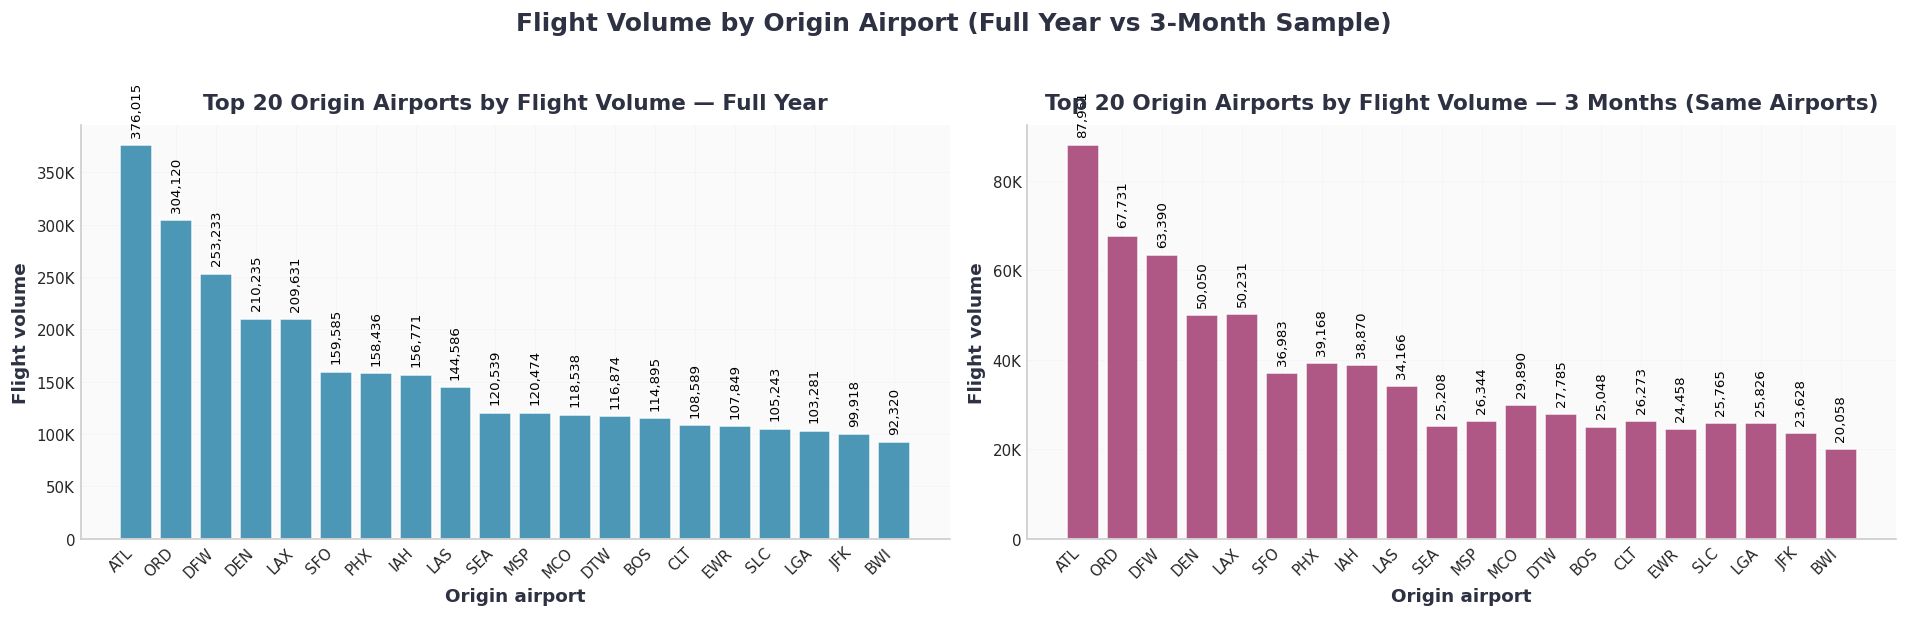

saved: /dbfs/student-groups/Group_4_4/Charts/phase2/top_20_airport_origin_by_flight_volume_combined_full_vs_3m.png


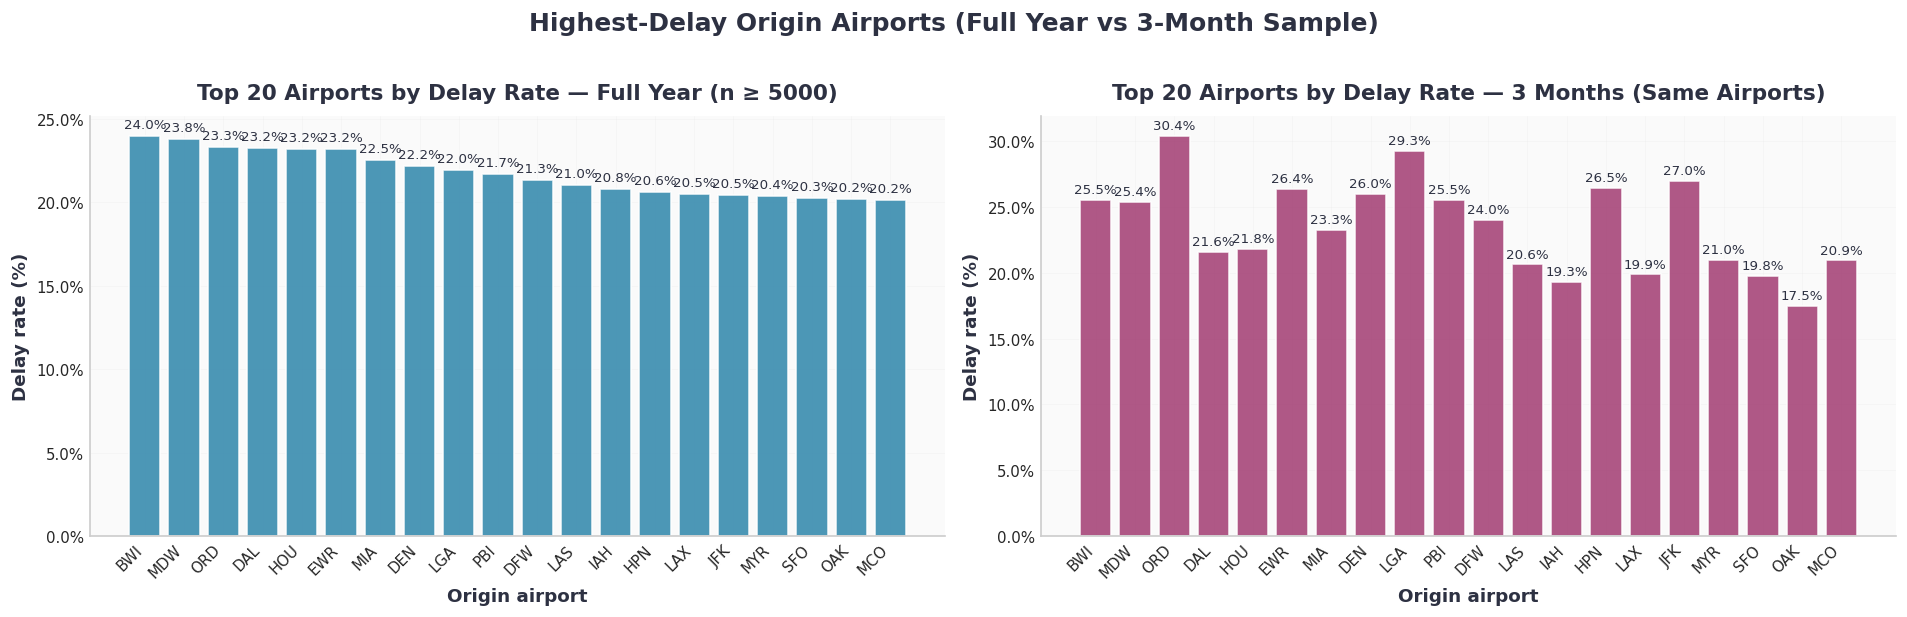

saved: /dbfs/student-groups/Group_4_4/Charts/phase2/top_20_airports_by_delay_rate_combined_full_vs_3m.png


In [0]:
# ============================================================
# CELL 6 — AIRPORT VOLUME + DELAY RATE (Combined + Styled)
# ============================================================

def plot_top_origins_volume_combined(df_full, df_3m, filename, top_k=20):
    """
    Side-by-side bar charts of flight volume by ORIGIN:
      - Left: full year (top_k airports by volume)
      - Right: same airports in 3-month window
    """
    # Top-k by volume from full-year
    pd_full = (
        df_full.groupBy("ORIGIN")
               .count()
               .orderBy(F.desc("count"))
               .limit(top_k)
               .toPandas()
    )
    top_airports = pd_full["ORIGIN"].tolist()

    # 3-month volume restricted to same airports
    pd_3m = (
        df_3m.groupBy("ORIGIN")
             .count()
             .where(F.col("ORIGIN").isin(top_airports))
             .toPandas()
    )
    pd_3m = (
        pd_3m.set_index("ORIGIN")
             .reindex(top_airports)
             .fillna(0)
             .reset_index()
    )

    fig, axes = plt.subplots(1, 2, figsize=(16, 5), facecolor="white")

    # -------- FULL YEAR --------
    ax1 = axes[0]
    x1 = np.arange(len(pd_full))
    bars1 = ax1.bar(
        x1,
        pd_full["count"],
        color=COLORS["primary"],
        alpha=0.85,
        edgecolor="white",
        linewidth=1,
    )

    style_axis(
        ax1,
        title="Top 20 Origin Airports by Flight Volume — Full Year",
        xlabel="Origin airport",
        ylabel="Flight volume",
        format_y_km=True,
    )
    ax1.set_xticks(x1)
    ax1.set_xticklabels(pd_full["ORIGIN"], rotation=45, ha="right")

    add_bar_labels(
        ax1,
        bars1,
        fmt="{:,.0f}",
        pad=0.02,
        rotation=90,
        fontsize=8,
    )

    # -------- 3-MONTH WINDOW --------
    ax2 = axes[1]
    x2 = np.arange(len(pd_3m))
    bars2 = ax2.bar(
        x2,
        pd_3m["count"],
        color=COLORS["secondary"],
        alpha=0.85,
        edgecolor="white",
        linewidth=1,
    )

    style_axis(
        ax2,
        title="Top 20 Origin Airports by Flight Volume — 3 Months (Same Airports)",
        xlabel="Origin airport",
        ylabel="Flight volume",
        format_y_km=True,
    )
    ax2.set_xticks(x2)
    ax2.set_xticklabels(pd_3m["ORIGIN"], rotation=45, ha="right")

    add_bar_labels(
        ax2,
        bars2,
        fmt="{:,.0f}",
        pad=0.02,
        rotation=90,
        fontsize=8,
    )

    fig.suptitle(
        "Flight Volume by Origin Airport (Full Year vs 3-Month Sample)",
        fontsize=15,
        fontweight="bold",
        color=COLORS["text"],
        y=1.02,
    )
    fig.tight_layout()

    display(fig)
    save_fig(fig, filename)


def plot_top_origins_delay_rate_combined(df_full, df_3m, filename, min_n=5000, top_k=20):
    """
    Side-by-side bar charts of delay rate (%) by ORIGIN:
      - Left: full year (top_k by delay rate among airports with >= min_n flights)
      - Right: same airports in 3-month window
    """
    # Full year: pick airports with enough volume and highest delay rate
    pd_full = (
        df_full.groupBy("ORIGIN")
               .agg(
                   F.count("*").alias("n"),
                   F.mean(TARGET_BIN).alias("delay_rate"),
               )
               .filter(F.col("n") >= min_n)
               .orderBy(F.desc("delay_rate"))
               .limit(top_k)
               .toPandas()
    )
    top_airports = pd_full["ORIGIN"].tolist()

    # 3-month delay rates for same airports
    pd_3m = (
        df_3m.groupBy("ORIGIN")
             .agg(
                 F.count("*").alias("n"),
                 F.mean(TARGET_BIN).alias("delay_rate"),
             )
             .where(F.col("ORIGIN").isin(top_airports))
             .toPandas()
    )

    # Align 3m table to the full-year airport order
    pd_3m = (
        pd_3m.set_index("ORIGIN")
             .reindex(top_airports)
             .reset_index()
    )

    fig, axes = plt.subplots(1, 2, figsize=(16, 5), facecolor="white")

    # -------- FULL YEAR --------
    ax1 = axes[0]
    x1 = np.arange(len(pd_full))
    bars1 = ax1.bar(
        x1,
        pd_full["delay_rate"] * 100,
        color=COLORS["primary"],
        alpha=0.85,
        edgecolor="white",
        linewidth=1,
    )

    style_axis(
        ax1,
        title=f"Top 20 Airports by Delay Rate — Full Year (n ≥ {min_n})",
        xlabel="Origin airport",
        ylabel="Delay rate (%)",
        format_y_km=False,
    )
    ax1.set_xticks(x1)
    ax1.set_xticklabels(pd_full["ORIGIN"], rotation=45, ha="right")
    ax1.yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, p: f"{x:.1f}%")
    )

    for i, v in enumerate(pd_full["delay_rate"] * 100):
        ax1.text(
            x1[i],
            v + 0.3,
            f"{v:.1f}%",
            ha="center",
            va="bottom",
            fontsize=8,
            color=COLORS["text"],
        )

    # -------- 3-MONTH WINDOW --------
    ax2 = axes[1]
    x2 = np.arange(len(pd_3m))
    bars2 = ax2.bar(
        x2,
        pd_3m["delay_rate"] * 100,
        color=COLORS["secondary"],
        alpha=0.85,
        edgecolor="white",
        linewidth=1,
    )

    style_axis(
        ax2,
        title="Top 20 Airports by Delay Rate — 3 Months (Same Airports)",
        xlabel="Origin airport",
        ylabel="Delay rate (%)",
        format_y_km=False,
    )
    ax2.set_xticks(x2)
    ax2.set_xticklabels(pd_3m["ORIGIN"], rotation=45, ha="right")
    ax2.yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, p: f"{x:.1f}%")
    )

    for i, v in enumerate(pd_3m["delay_rate"] * 100):
        ax2.text(
            x2[i],
            v + 0.3,
            f"{v:.1f}%",
            ha="center",
            va="bottom",
            fontsize=8,
            color=COLORS["text"],
        )

    fig.suptitle(
        "Highest-Delay Origin Airports (Full Year vs 3-Month Sample)",
        fontsize=15,
        fontweight="bold",
        color=COLORS["text"],
        y=1.02,
    )
    fig.tight_layout()

    display(fig)
    save_fig(fig, filename)


# ------------------------------------------------------------
# Generate ALL combined charts
# ------------------------------------------------------------

plot_top_origins_volume_combined(
    otpw_full_df,
    otpw_3m_df,
    "top_20_airport_origin_by_flight_volume_combined_full_vs_3m.png"
)

plot_top_origins_delay_rate_combined(
    otpw_full_df,
    otpw_3m_df,
    "top_20_airports_by_delay_rate_combined_full_vs_3m.png"
)


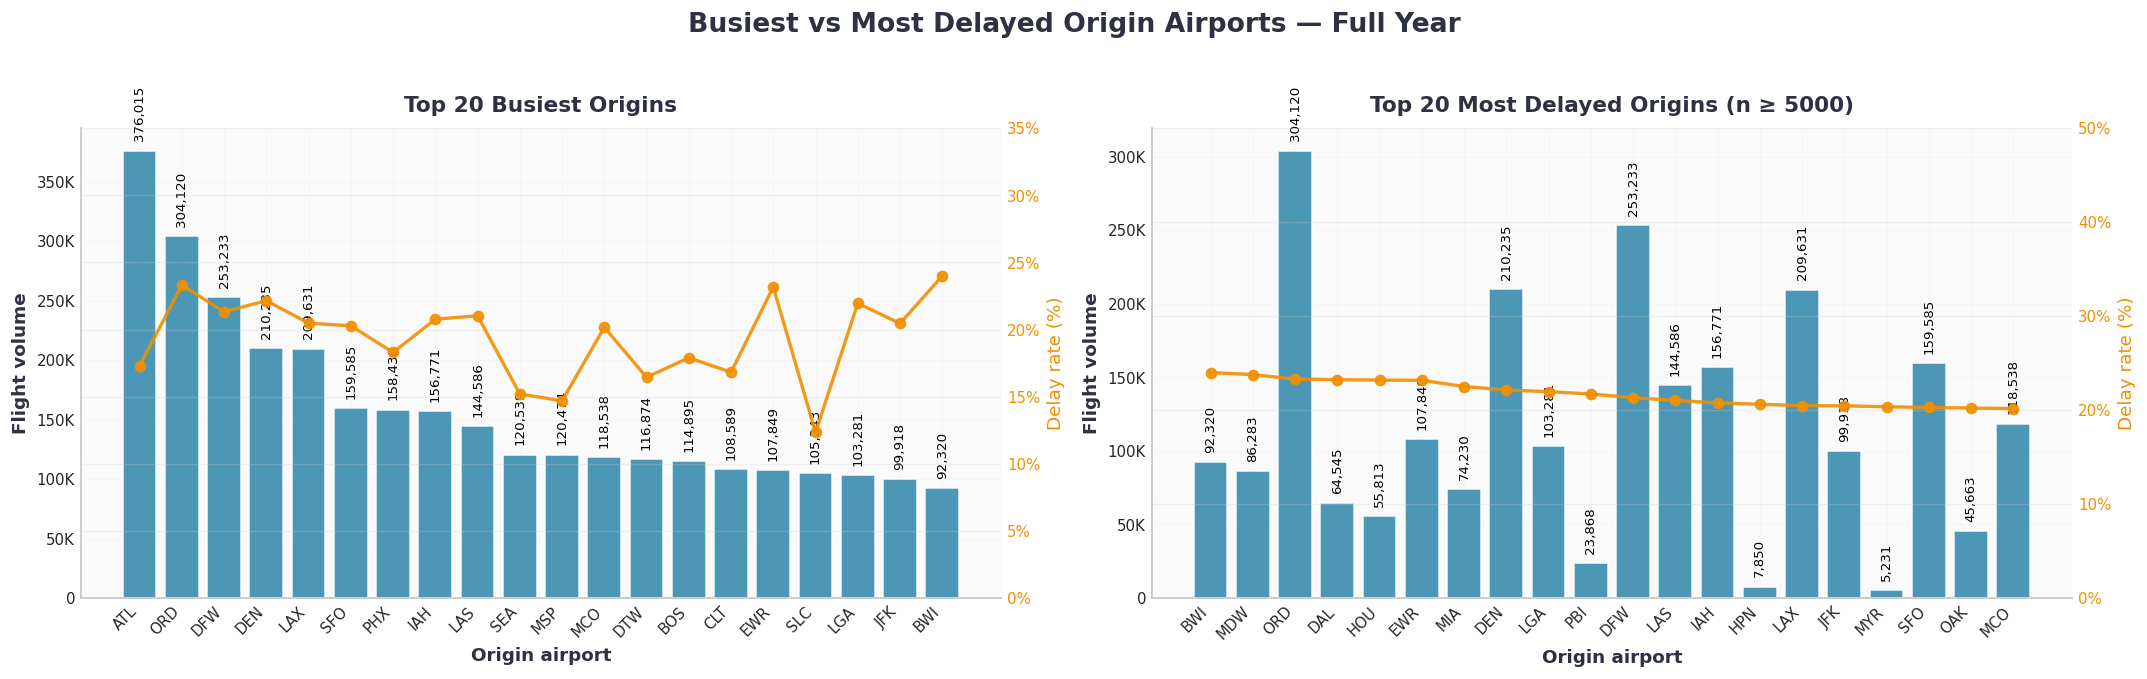

saved: /dbfs/student-groups/Group_4_4/Charts/phase2/busiest_vs_most_delayed_two_panel_full.png


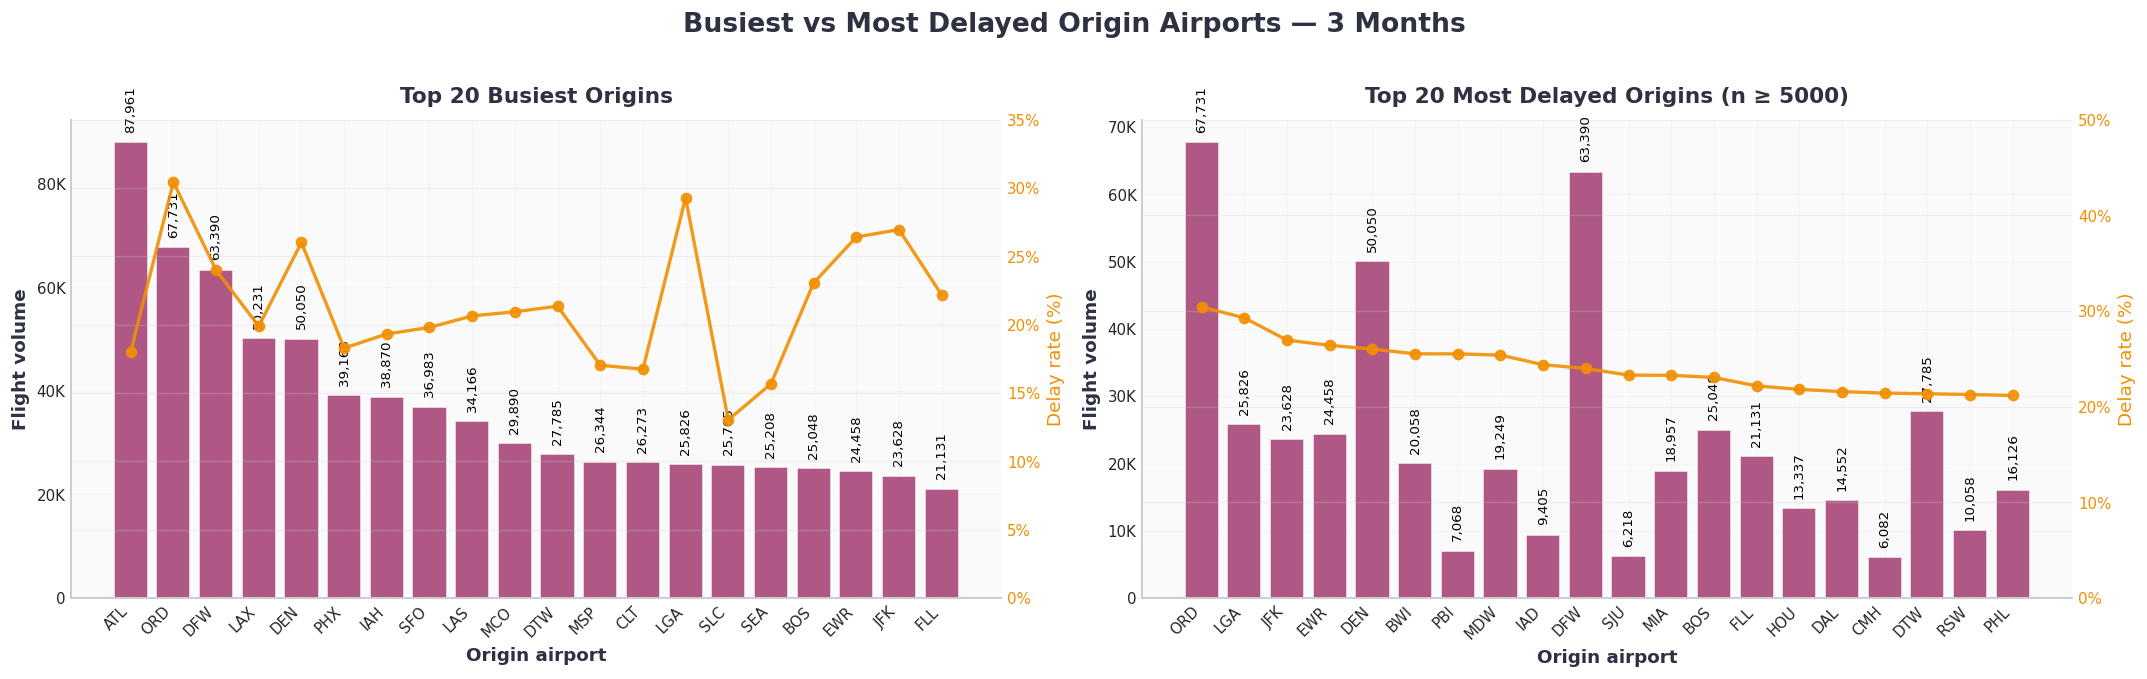

saved: /dbfs/student-groups/Group_4_4/Charts/phase2/busiest_vs_most_delayed_two_panel_3m.png


In [0]:
# ============================================================
# CELL 7 — TWO-PANEL BUSIEST vs MOST-DELAYED ORIGINS (Styled)
# ============================================================

def get_busiest_and_most_delayed(df_in, top_k=20, min_n=5000):
    busiest = (
        df_in.groupBy("ORIGIN")
             .agg(
                 F.count("*").alias("num_flights"),
                 (F.mean(TARGET_BIN) * 100).alias("delay_rate_pct"),
             )
             .orderBy(F.desc("num_flights"))
             .limit(top_k)
             .toPandas()
    )

    most_delayed = (
        df_in.groupBy("ORIGIN")
             .agg(
                 F.count("*").alias("num_flights"),
                 (F.mean(TARGET_BIN) * 100).alias("delay_rate_pct"),
             )
             .filter(F.col("num_flights") >= min_n)
             .orderBy(F.desc("delay_rate_pct"))
             .limit(top_k)
             .toPandas()
    )

    return busiest, most_delayed


def plot_busiest_vs_delayed_two_panel(
    df_in,
    title,
    filename,
    top_k=20,
    min_n=5000,
    color_key="primary",   # "primary" for full year, "secondary" for 3m
):
    pdf_busiest, pdf_delayed = get_busiest_and_most_delayed(
        df_in, top_k=top_k, min_n=min_n
    )

    base_color = COLORS[color_key]         # dataset identity (blue/purple)
    delay_color = COLORS["warning"]        # semantic delay color (orange)

    fig, axes = plt.subplots(1, 2, figsize=(18, 5.5), facecolor="white")

    # =====================================================
    # LEFT: Busiest origins (volume + delay rate line)
    # =====================================================
    ax1 = axes[0]
    x1 = np.arange(len(pdf_busiest))

    bars1 = ax1.bar(
        x1,
        pdf_busiest["num_flights"],
        color=base_color,
        alpha=0.85,
        edgecolor="white",
        linewidth=1,
    )

    style_axis(
        ax1,
        title="Top 20 Busiest Origins",
        xlabel="Origin airport",
        ylabel="Flight volume",
    )
    ax1.set_xticks(x1)
    ax1.set_xticklabels(pdf_busiest["ORIGIN"], rotation=45, ha="right")

    add_bar_labels(
        ax1,
        bars1,
        fmt="{:,.0f}",
        pad=0.02,
        rotation=90,
        fontsize=8,
    )

    # secondary axis = delay rate %
    ax1b = ax1.twinx()
    ax1b.plot(
        x1,
        pdf_busiest["delay_rate_pct"],
        color=delay_color,
        marker="o",
        linewidth=2,
        alpha=0.9,
        label="Delay rate (%)",
    )
    ax1b.set_ylabel("Delay rate (%)", color=delay_color)
    ax1b.tick_params(axis="y", labelcolor=delay_color)
    ax1b.yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, p: f"{x:.0f}%")
    )
    ax1b.set_ylim(
        0,
        max(35, pdf_busiest["delay_rate_pct"].max() * 1.15),
    )

    # =====================================================
    # RIGHT: Most delayed origins (volume + delay rate line)
    # =====================================================
    ax2 = axes[1]
    x2 = np.arange(len(pdf_delayed))

    bars2 = ax2.bar(
        x2,
        pdf_delayed["num_flights"],
        color=base_color,
        alpha=0.85,
        edgecolor="white",
        linewidth=1,
    )

    style_axis(
        ax2,
        title=f"Top 20 Most Delayed Origins (n ≥ {min_n})",
        xlabel="Origin airport",
        ylabel="Flight volume",
    )
    ax2.set_xticks(x2)
    ax2.set_xticklabels(pdf_delayed["ORIGIN"], rotation=45, ha="right")

    add_bar_labels(
        ax2,
        bars2,
        fmt="{:,.0f}",
        pad=0.02,
        rotation=90,
        fontsize=8,
    )

    ax2b = ax2.twinx()
    ax2b.plot(
        x2,
        pdf_delayed["delay_rate_pct"],
        color=delay_color,
        marker="o",
        linewidth=2,
        alpha=0.9,
        label="Delay rate (%)",
    )
    ax2b.set_ylabel("Delay rate (%)", color=delay_color)
    ax2b.tick_params(axis="y", labelcolor=delay_color)
    ax2b.yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, p: f"{x:.0f}%")
    )
    ax2b.set_ylim(
        0,
        max(50, pdf_delayed["delay_rate_pct"].max() * 1.10),
    )

    fig.suptitle(
        title,
        fontsize=16,
        fontweight="bold",
        color=COLORS["text"],
        y=1.02,
    )
    fig.tight_layout()

    display(fig)
    save_fig(fig, filename)


# --- run for full + 3m with correct palette mapping
plot_busiest_vs_delayed_two_panel(
    otpw_full_df,
    "Busiest vs Most Delayed Origin Airports — Full Year",
    "busiest_vs_most_delayed_two_panel_full.png",
    color_key="primary",   # full year = blue
)

plot_busiest_vs_delayed_two_panel(
    otpw_3m_df,
    "Busiest vs Most Delayed Origin Airports — 3 Months",
    "busiest_vs_most_delayed_two_panel_3m.png",
    color_key="secondary", # 3m = purple
)


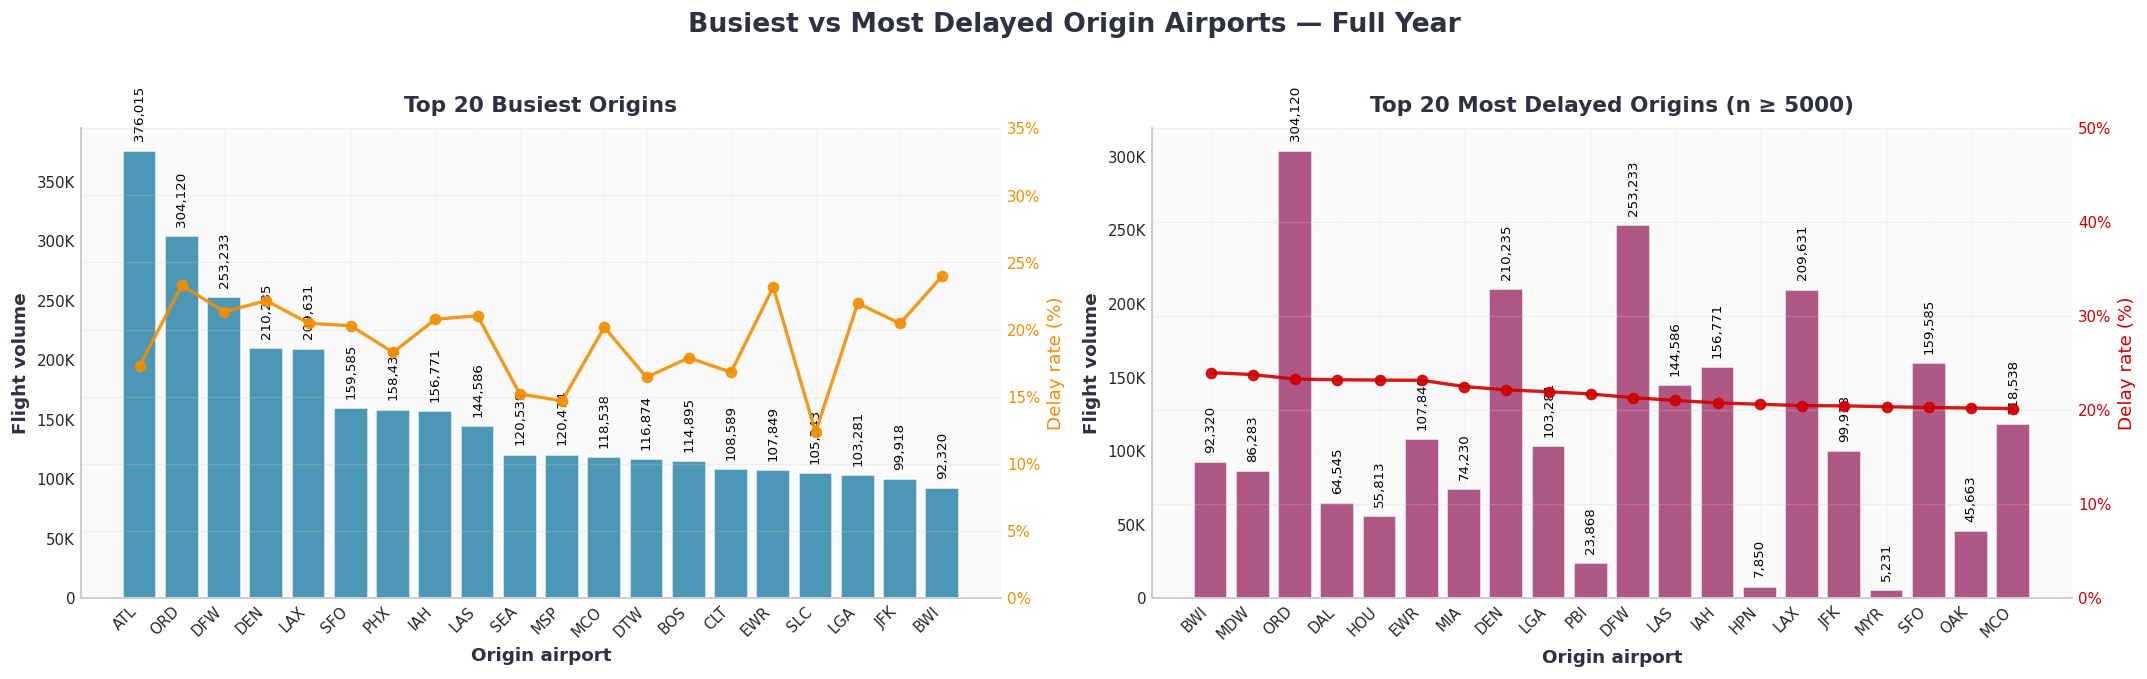

saved: /dbfs/student-groups/Group_4_4/Charts/phase2/busiest_vs_most_delayed_two_panel_full.png


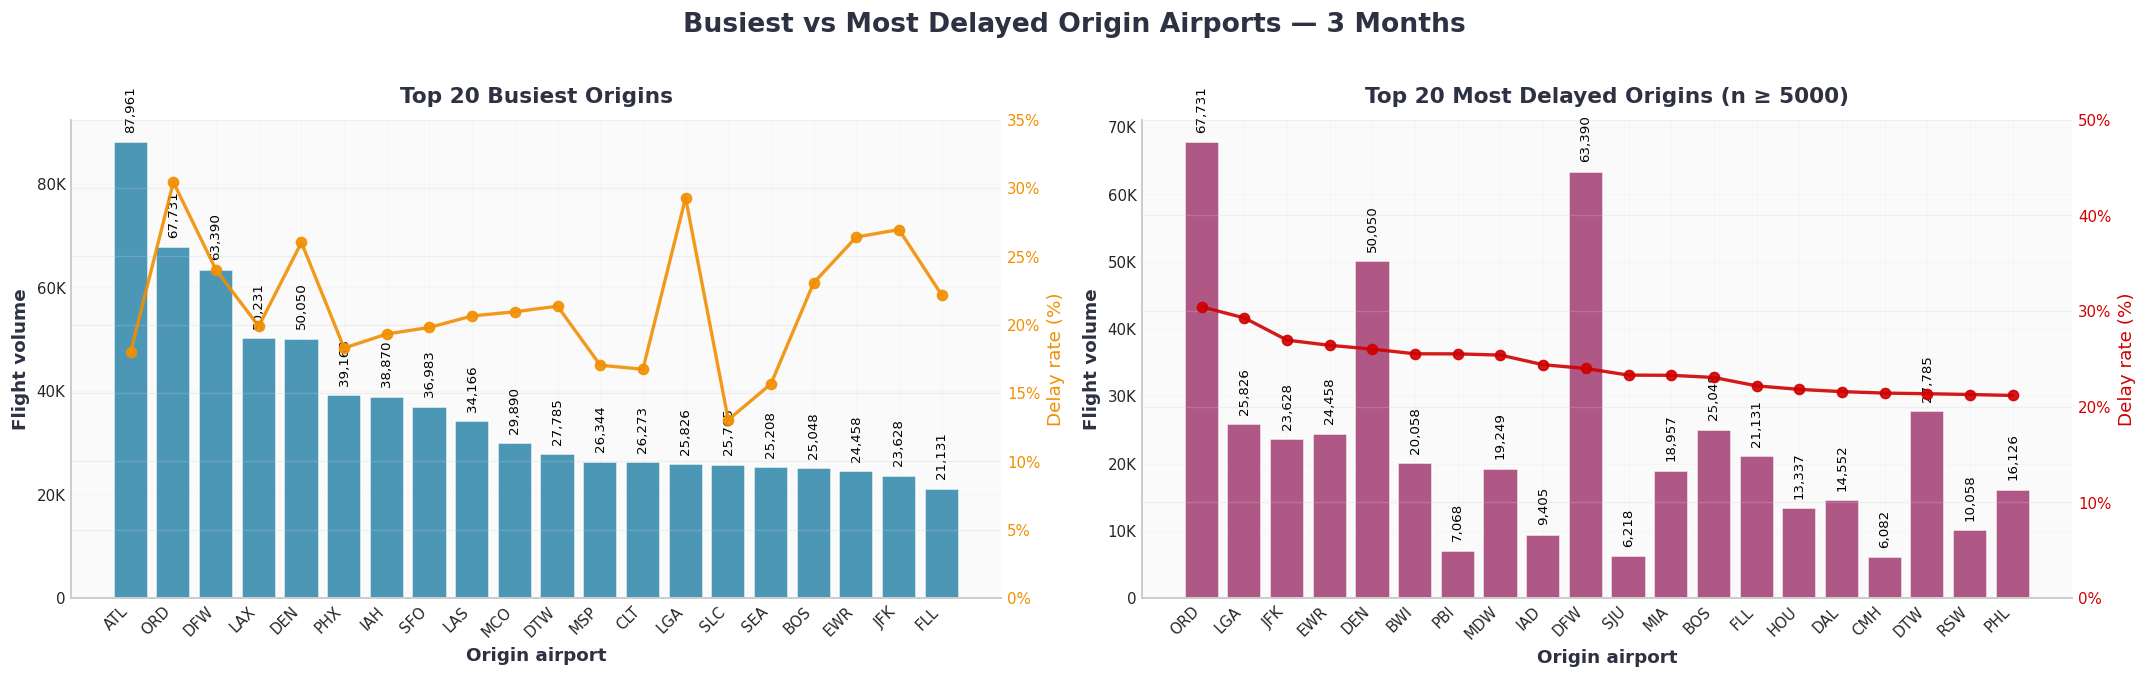

saved: /dbfs/student-groups/Group_4_4/Charts/phase2/busiest_vs_most_delayed_two_panel_3m.png


In [0]:
# ============================================================
# CELL 7 — TWO-PANEL BUSIEST vs MOST-DELAYED ORIGINS (Styled)
# ============================================================

def get_busiest_and_most_delayed(df_in, top_k=20, min_n=5000):
    busiest = (
        df_in.groupBy("ORIGIN")
             .agg(
                 F.count("*").alias("num_flights"),
                 (F.mean(TARGET_BIN) * 100).alias("delay_rate_pct"),
             )
             .orderBy(F.desc("num_flights"))
             .limit(top_k)
             .toPandas()
    )

    most_delayed = (
        df_in.groupBy("ORIGIN")
             .agg(
                 F.count("*").alias("num_flights"),
                 (F.mean(TARGET_BIN) * 100).alias("delay_rate_pct"),
             )
             .filter(F.col("num_flights") >= min_n)
             .orderBy(F.desc("delay_rate_pct"))
             .limit(top_k)
             .toPandas()
    )

    return busiest, most_delayed


def plot_busiest_vs_delayed_two_panel(df_in, title, filename, top_k=20, min_n=5000):
    pdf_busiest, pdf_delayed = get_busiest_and_most_delayed(
        df_in, top_k=top_k, min_n=min_n
    )

    fig, axes = plt.subplots(1, 2, figsize=(18, 5.5), facecolor="white")

    # =====================================================
    # LEFT: Busiest origins (volume + delay rate line)
    # =====================================================
    ax1 = axes[0]
    x1 = np.arange(len(pdf_busiest))

    bars1 = ax1.bar(
        x1,
        pdf_busiest["num_flights"],
        color=COLORS["primary"],
        alpha=0.85,
        edgecolor="white",
        linewidth=1,
    )

    style_axis(
        ax1,
        title="Top 20 Busiest Origins",
        xlabel="Origin airport",
        ylabel="Flight volume",
        format_y_km=True,
    )
    ax1.set_xticks(x1)
    ax1.set_xticklabels(pdf_busiest["ORIGIN"], rotation=45, ha="right")

    add_bar_labels(
        ax1,
        bars1,
        fmt="{:,.0f}",
        pad=0.02,
        rotation=90,
        fontsize=8,
    )

    # secondary axis = delay rate %
    ax1b = ax1.twinx()
    ax1b.plot(
        x1,
        pdf_busiest["delay_rate_pct"],
        color=COLORS["warning"],
        marker="o",
        linewidth=2,
        alpha=0.9,
        label="Delay rate (%)",
    )
    ax1b.set_ylabel("Delay rate (%)", color=COLORS["warning"])
    ax1b.tick_params(axis="y", labelcolor=COLORS["warning"])
    ax1b.yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, p: f"{x:.0f}%")
    )
    ax1b.set_ylim(
        0,
        max(35, pdf_busiest["delay_rate_pct"].max() * 1.15),
    )

    # =====================================================
    # RIGHT: Most delayed origins (volume + delay rate line)
    # =====================================================
    ax2 = axes[1]
    x2 = np.arange(len(pdf_delayed))

    bars2 = ax2.bar(
        x2,
        pdf_delayed["num_flights"],
        color=COLORS["secondary"],
        alpha=0.85,
        edgecolor="white",
        linewidth=1,
    )

    style_axis(
        ax2,
        title=f"Top 20 Most Delayed Origins (n ≥ {min_n})",
        xlabel="Origin airport",
        ylabel="Flight volume",
        format_y_km=True,
    )
    ax2.set_xticks(x2)
    ax2.set_xticklabels(pdf_delayed["ORIGIN"], rotation=45, ha="right")

    add_bar_labels(
        ax2,
        bars2,
        fmt="{:,.0f}",
        pad=0.02,
        rotation=90,
        fontsize=8,
    )

    ax2b = ax2.twinx()
    ax2b.plot(
        x2,
        pdf_delayed["delay_rate_pct"],
        color=COLORS["danger"],
        marker="o",
        linewidth=2,
        alpha=0.9,
        label="Delay rate (%)",
    )
    ax2b.set_ylabel("Delay rate (%)", color=COLORS["danger"])
    ax2b.tick_params(axis="y", labelcolor=COLORS["danger"])
    ax2b.yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, p: f"{x:.0f}%")
    )
    ax2b.set_ylim(
        0,
        max(50, pdf_delayed["delay_rate_pct"].max() * 1.10),
    )

    fig.suptitle(
        title,
        fontsize=16,
        fontweight="bold",
        color=COLORS["text"],
        y=1.02,
    )
    fig.tight_layout()

    display(fig)
    save_fig(fig, filename)


# --- run for full + 3m
plot_busiest_vs_delayed_two_panel(
    otpw_full_df,
    "Busiest vs Most Delayed Origin Airports — Full Year",
    "busiest_vs_most_delayed_two_panel_full.png",
)

plot_busiest_vs_delayed_two_panel(
    otpw_3m_df,
    "Busiest vs Most Delayed Origin Airports — 3 Months",
    "busiest_vs_most_delayed_two_panel_3m.png",
)


In [0]:
show_pair(
    full_name="top_20_busiest_airports_sorted_by_delay_rate_full.png",
    m3_name="top_20_busiest_airports_sorted_by_delay_rate_3m.png",
    title="Busiest Origins Sorted by Delay Rate",
    caption="Orange = volume, Blue = delay rate."
)


In [0]:
# ============================================================
# CELL 8 — WEATHER BINNED DELAY VS VOLUME (Styled + Clean)
# ============================================================

def binned_delay_vs_volume(
    df_in,
    col,
    bins,
    title,
    filename,
    min_bin_n=5000,
    drop_zero=False
):
    # --- 1) Bucketize into bins ---
    splits = [-float("inf")] + bins + [float("inf")]
    bucketizer = Bucketizer(
        splits=splits,
        inputCol=col,
        outputCol=f"{col}_bin",
        handleInvalid="skip"
    )

    bdf = bucketizer.transform(df_in.select(col, TARGET_BIN).dropna())
    if drop_zero:
        bdf = bdf.filter(F.col(col) > 0)

    pd_b = (
        bdf.groupBy(f"{col}_bin")
           .agg(
               F.count("*").alias("n"),
               F.mean(TARGET_BIN).alias("delay_rate"),
               F.mean(col).alias("bin_center"),
           )
           .filter(F.col("n") >= min_bin_n)
           .orderBy("bin_center")
           .toPandas()
    )

    if pd_b.empty:
        print(f"No bins with at least {min_bin_n} rows for {col}.")
        return None

    delay_pct = pd_b["delay_rate"] * 100

    # --- 2) Figure + primary axis (volume) ---
    fig, ax1 = plt.subplots(figsize=(12, 5), facecolor="white")

    bars = ax1.bar(
        pd_b["bin_center"],
        pd_b["n"],
        color=COLORS["primary"],    # volume: dataset-style blue
        alpha=0.85,
        edgecolor="white",
        linewidth=1,
    )

    style_axis(
        ax1,
        title=title,
        xlabel=col,
        ylabel="Flight volume",
        format_y_km=True,           # K/M formatting on volume
    )

    add_bar_labels(
        ax1,
        bars,
        fmt="{:,.0f}",
        pad=0.02,
        rotation=90,
        fontsize=8,
    )

    # --- 3) Secondary axis (delay rate %) ---
    ax2 = ax1.twinx()
    styled_line(
        ax2,
        pd_b["bin_center"],
        delay_pct,
        color=COLORS["warning"],    # semantic delay = orange
    )
    ax2.set_ylabel("Delay rate (%)", color=COLORS["warning"])
    ax2.tick_params(axis="y", labelcolor=COLORS["warning"])
    ax2.yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, p: f"{x:.0f}%")
    )
    ax2.set_ylim(0, max(35, delay_pct.max() * 1.15))

    # label every ~8 bins max to avoid clutter
    step = max(1, len(pd_b) // 8)
    for i, r in pd_b.iloc[::step].iterrows():
        ax2.text(
            r["bin_center"],
            r["delay_rate"] * 100 + 0.6,
            f"{r['delay_rate']*100:.1f}%",
            ha="center",
            fontsize=8,
            color=COLORS["warning"],
        )

    fig.tight_layout()

    # show + save
    display(fig)
    return save_fig(fig, filename)


In [0]:
# ============================================================
# CELL 8 — WEATHER BINNED DELAY VS VOLUME (styled + clean)
# ============================================================

def binned_delay_vs_volume(df_in, col, bins, title, filename,
                           min_bin_n=5000, drop_zero=False):
    splits = [-float("inf")] + bins + [float("inf")]
    bucketizer = Bucketizer(
        splits=splits,
        inputCol=col,
        outputCol=f"{col}_bin",
        handleInvalid="skip"
    )

    bdf = bucketizer.transform(df_in.select(col, TARGET_BIN).dropna())
    if drop_zero:
        bdf = bdf.filter(F.col(col) > 0)

    pd_b = (bdf.groupBy(f"{col}_bin")
              .agg(F.count("*").alias("n"),
                   F.mean(TARGET_BIN).alias("delay_rate"),
                   F.mean(col).alias("bin_center"))
              .filter(F.col("n") >= min_bin_n)
              .orderBy("bin_center")
              .toPandas())

    fig, ax1 = plt.subplots(figsize=(10,5))
    bars = styled_bar(ax1, pd_b["bin_center"], pd_b["n"])
    ax1.set_xlabel(col)
    ax1.set_ylabel("Flight Volume")
    add_bar_labels(ax1, bars, fmt="{:,.0f}", rotation=90, fs=8)

    ax2 = ax1.twinx()
    styled_line(ax2, pd_b["bin_center"], pd_b["delay_rate"]*100)
    ax2.set_ylabel("Delay Rate (%)")
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax2.set_ylim(0, max(35, (pd_b["delay_rate"]*100).max()*1.15))

    # only label every ~3 points to avoid clutter
    step = max(1, len(pd_b)//8)
    for i, r in pd_b.iloc[::step].iterrows():
        ax2.text(r["bin_center"], r["delay_rate"]*100 + 0.6,
                 f"{r['delay_rate']*100:.1f}%",
                 ha="center", fontsize=9, color=LINE_COLOR)

    ax1.set_title(title)
    fig.tight_layout()
    return save_fig(fig, filename)


In [0]:
def show_pair(full_name, m3_name, title, caption):    # Implementation of show_pair function
    print(f"Full Name: {full_name}")
    print(f"M3 Name: {m3_name}")
    print(f"Title: {title}")
    print(f"Caption: {caption}")

show_pair(

    full_name="temp_vs_delay_full.png",
    m3_name="temp_vs_delay_3m.png",
    title="Temperature vs Delay Patterns",
    caption="Bars show flight volume across temperature bins; line shows DEP_DEL15 delay rate."
)


Full Name: temp_vs_delay_full.png
M3 Name: temp_vs_delay_3m.png
Title: Temperature vs Delay Patterns
Caption: Bars show flight volume across temperature bins; line shows DEP_DEL15 delay rate.


In [0]:
# ============================================================
# CELL X — CORRELATION VS TARGETS (DEP_DEL15 + DEP_DELAY)
# ============================================================

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

def corr_vs_targets(df_in, feature_cols, bin_target="DEP_DEL15", num_target="DEP_DELAY", top_k=20):
    # drop targets if present
    feats = [c for c in feature_cols if c not in [bin_target, num_target]]

    # ---- point-biserial vs binary target
    pb_rows = []
    for c in feats:
        if c in df_in.columns:
            r = df_in.stat.corr(c, bin_target)
            if r is not None:
                pb_rows.append((c, float(r)))
    pb_pd = pd.DataFrame(pb_rows, columns=["feature","corr_pb"]).sort_values("corr_pb", ascending=False).head(top_k)

    # ---- pearson vs numeric target
    pr_rows = []
    for c in feats:
        if c in df_in.columns:
            r = df_in.stat.corr(c, num_target)
            if r is not None:
                pr_rows.append((c, float(r)))
    pr_pd = pd.DataFrame(pr_rows, columns=["feature","corr_pearson"]).sort_values("corr_pearson", ascending=False).head(top_k)

    return pb_pd, pr_pd

pb_full, pr_full = corr_vs_targets(otpw_full_df, NUM_COLS)
pb_3m,   pr_3m   = corr_vs_targets(otpw_3m_df, NUM_COLS)

display(pb_full)
display(pr_full)


feature   corr_pb
51                            prev_flight_dep_del15  0.368793
60                             prior_day_delay_rate  0.293963
40  dep_delay15_24h_rolling_avg_by_origin_dayofweek  0.266152
57                          num_airport_wide_delays  0.262699
39    dep_delay15_24h_rolling_avg_by_origin_carrier  0.231088
38            dep_delay15_24h_rolling_avg_by_origin  0.217391
1                                      CRS_DEP_TIME  0.167434
67                                     arr_time_cos  0.144690
9                                      CRS_ARR_TIME  0.141087
37                    rolling_origin_num_delays_24h  0.125903
84                            origin_1yr_delay_rate  0.111319
35                              time_of_day_evening  0.104275
85                              dest_1yr_delay_rate  0.097112
81                             carrier_delay_stddev  0.095236
17                           HourlyRelativeHumidity  0.086443
3                                    departure_hour  0.080685
78                            extreme_weather_score  0.078064
50                                         is_rainy  0.075440
36                                time_of_day_night  0.072267
65                                     dep_time_cos  0.060338

feature  corr_pearson
51                            prev_flight_dep_del15      0.285562
60                             prior_day_delay_rate      0.262830
40  dep_delay15_24h_rolling_avg_by_origin_dayofweek      0.228050
57                          num_airport_wide_delays      0.213178
39    dep_delay15_24h_rolling_avg_by_origin_carrier      0.195845
38            dep_delay15_24h_rolling_avg_by_origin      0.188888
1                                      CRS_DEP_TIME      0.110690
37                    rolling_origin_num_delays_24h      0.104786
67                                     arr_time_cos      0.100260
9                                      CRS_ARR_TIME      0.097880
84                            origin_1yr_delay_rate      0.083558
78                            extreme_weather_score      0.078422
17                           HourlyRelativeHumidity      0.076906
35                              time_of_day_evening      0.076372
50                                         is_rainy      0.075060
81                             carrier_delay_stddev      0.072528
85                              dest_1yr_delay_rate      0.072111
74                            extreme_precipitation      0.064698
3                                    departure_hour      0.062827
31                                    is_peak_month      0.047206

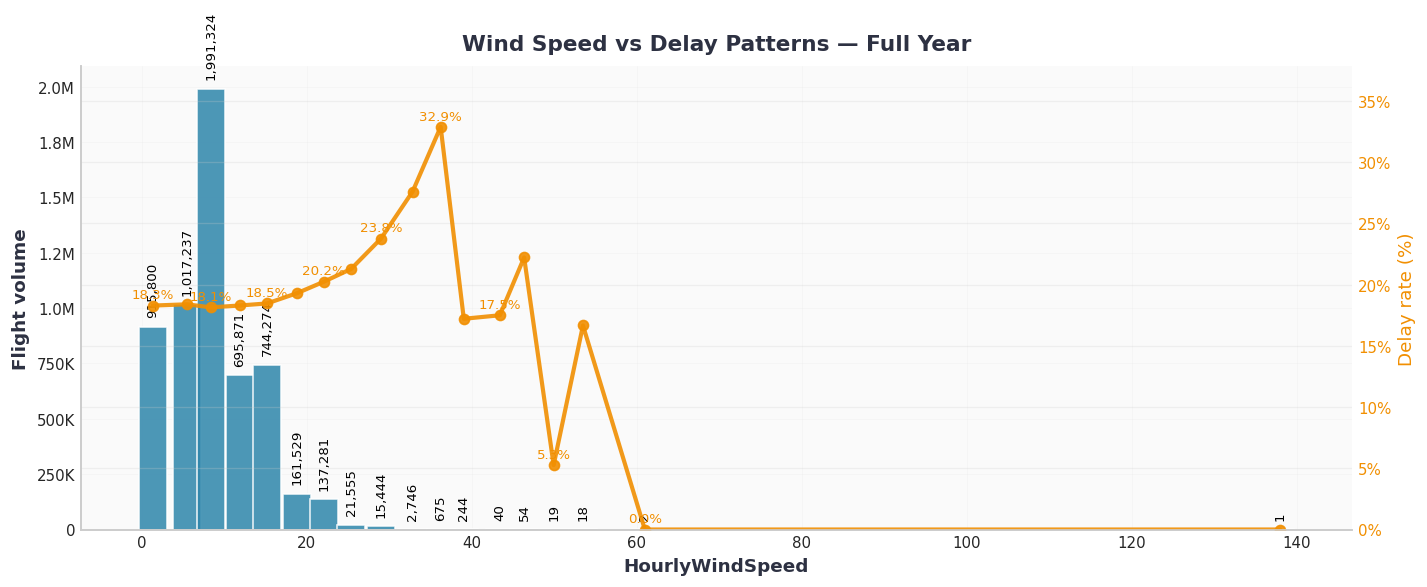

saved: /dbfs/student-groups/Group_4_4/Charts/phase2/wind_vs_delay_full.png


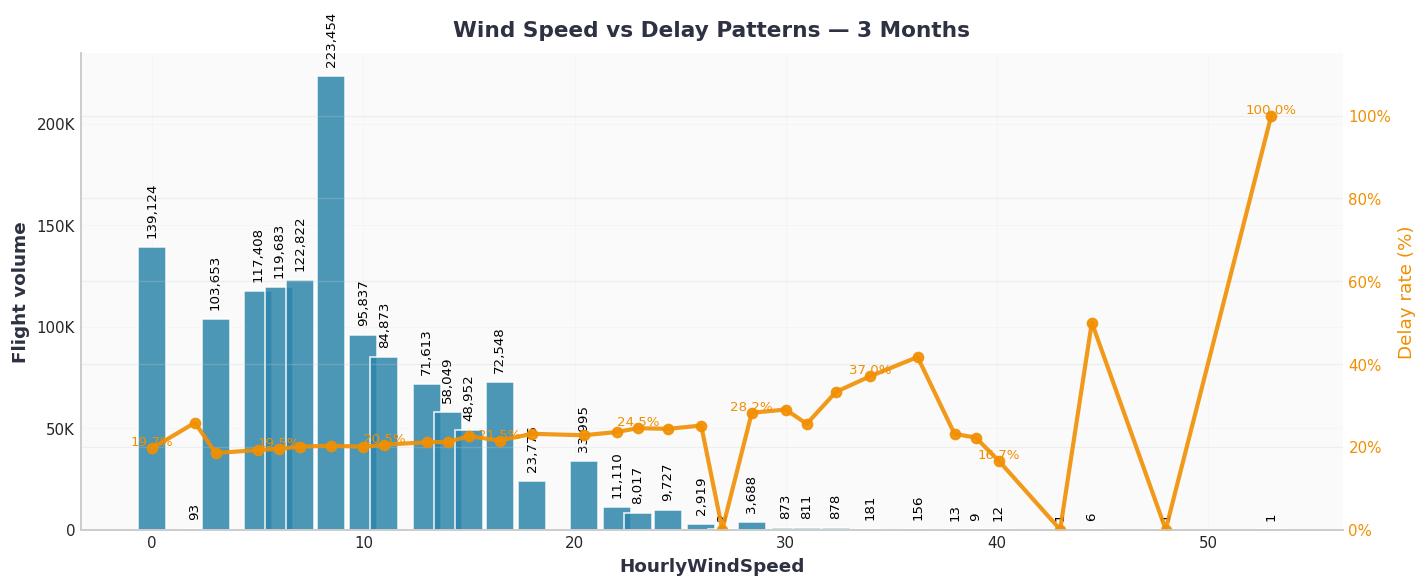

saved: /dbfs/student-groups/Group_4_4/Charts/phase2/wind_vs_delay_3m.png


In [0]:
# ============================================================
# CELL — WIND SPEED vs DELAY PATTERNS (Full + 3M, Styled)
# ============================================================

def plot_wind_vs_delay(
    df_in,
    col,
    title,
    filename,
    bins=40,
):
    """
    Wind speed vs delay:
      - Bars = flight volume (primary blue)
      - Line = delay rate (%) (orange)
      - Uses Phase 2 COLORS + style_axis
    """
    pd_w = (
        df_in.select(col, TARGET_BIN)
             .dropna()
             .toPandas()
    )

    if pd_w.empty:
        print(f"No data for {col} — skipping plot.")
        return None

    # Create bins in pandas
    pd_w["wind_bin"] = pd.cut(pd_w[col], bins=bins)

    grouped = (
        pd_w.groupby("wind_bin")
            .agg(
                n=("wind_bin", "size"),
                delay_rate=(TARGET_BIN, "mean"),
                bin_center=(col, "mean"),
            )
            .dropna()
            .reset_index(drop=True)
    )

    if grouped.empty:
        print(f"No non-empty bins for {col} — skipping plot.")
        return None

    # Approx bin width for bar chart
    bin_width = (grouped["bin_center"].max() - grouped["bin_center"].min()) / bins
    if not np.isfinite(bin_width) or bin_width <= 0:
        bin_width = max(1.0, grouped["bin_center"].std())

    delay_pct = grouped["delay_rate"] * 100

    fig, ax1 = plt.subplots(figsize=(12, 5), facecolor="white")

    # -----------------------------
    # Bars: flight volume (primary)
    # -----------------------------
    bars = ax1.bar(
        grouped["bin_center"],
        grouped["n"],
        width=bin_width,
        color=COLORS["primary"],
        alpha=0.85,
        edgecolor="white",
        linewidth=1,
    )

    style_axis(
        ax1,
        title=title,
        xlabel=col,
        ylabel="Flight volume",
        format_y_km=True,  # K/M for counts
    )

    add_bar_labels(
        ax1,
        bars,
        fmt="{:,.0f}",
        pad=0.02,
        rotation=90,
        fontsize=8,
    )

    # -----------------------------
    # Line: delay rate (%) (orange)
    # -----------------------------
    ax2 = ax1.twinx()
    ax2.plot(
        grouped["bin_center"],
        delay_pct,
        color=COLORS["warning"],
        marker="o",
        linewidth=2.5,
        alpha=0.9,
    )
    ax2.set_ylabel("Delay rate (%)", color=COLORS["warning"])
    ax2.tick_params(axis="y", labelcolor=COLORS["warning"])
    ax2.yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, p: f"{x:.0f}%")
    )
    ax2.set_ylim(0, max(35, delay_pct.max() * 1.15))

    # Label every ~8 points max
    step = max(1, len(grouped) // 8)
    for i, r in grouped.iloc[::step].iterrows():
        ax2.text(
            r["bin_center"],
            r["delay_rate"] * 100 + 0.6,
            f"{r['delay_rate']*100:.1f}%",
            ha="center",
            fontsize=8,
            color=COLORS["warning"],
        )

    fig.tight_layout()

    # show + save
    display(fig)
    return save_fig(fig, filename)


# ---- AUTO USE HourlyWindSpeed ----
if "HourlyWindSpeed" in df.columns:
    WIND_COL = "HourlyWindSpeed"

    plot_wind_vs_delay(
        otpw_full_df,
        WIND_COL,
        "Wind Speed vs Delay Patterns — Full Year",
        "wind_vs_delay_full.png",
    )

    plot_wind_vs_delay(
        otpw_3m_df,
        WIND_COL,
        "Wind Speed vs Delay Patterns — 3 Months",
        "wind_vs_delay_3m.png",
    )
else:
    print("No wind speed column found — skipping wind/delay plot.")


In [0]:
dbutils.fs.ls("dbfs:/student-groups/Group_4_4/Charts/phase2")


In [0]:
# ============================================================
# CELL — WIND SPEED vs DELAY PATTERNS (Full + 3M, Styled)
# ============================================================

def plot_wind_vs_delay(df_in, col, title, filename, bins=40):
    """
    Creates a clean histogram of wind speed (volume) + delay rate line,
    matching the aesthetic of the earlier weather visuals.
    """
    pd_w = (
        df_in.select(col, TARGET_BIN)
             .dropna()
             .toPandas()
    )

    # Create bins
    pd_w["wind_bin"] = pd.cut(pd_w[col], bins=bins)

    grouped = (
        pd_w.groupby("wind_bin")
            .agg(
                n=("wind_bin","size"),
                delay_rate=(TARGET_BIN,"mean"),
                bin_center=(col,"mean")
            )
            .dropna()
    )

    fig, ax1 = plt.subplots(figsize=(10,5))

    # Bar = flight volume
    ax1.bar(
        grouped["bin_center"],
        grouped["n"],
        width=(grouped["bin_center"].max() - grouped["bin_center"].min())/bins,
        color=BAR_COLOR, alpha=0.85
    )
    ax1.set_xlabel(col)
    ax1.set_ylabel("Flight Volume")

    # Line = delay rate
    ax2 = ax1.twinx()
    ax2.plot(
        grouped["bin_center"],
        grouped["delay_rate"] * 100,
        color=LINE_COLOR,
        marker="o",
        linewidth=2.3
    )
    ax2.set_ylabel("Delay Rate (%)")

    ax1.set_title(title)
    fig.tight_layout()
    return save_fig(fig, filename)


# ---- AUTO USE HourlyWindSpeed ----
if "HourlyWindSpeed" in df.columns:
    WIND_COL = "HourlyWindSpeed"

    plot_wind_vs_delay(
        otpw_full_df, WIND_COL,
        "Wind Speed vs Delay Patterns — Full Year",
        "wind_vs_delay_full.png"
    )

    plot_wind_vs_delay(
        otpw_3m_df, WIND_COL,
        "Wind Speed vs Delay Patterns — 3 Months",
        "wind_vs_delay_3m.png"
    )
else:
    print("No wind speed column found — skipping wind/delay plot.")


saved: /dbfs/student-groups/Group_4_4/Charts/phase2/wind_vs_delay_full.png
saved: /dbfs/student-groups/Group_4_4/Charts/phase2/wind_vs_delay_3m.png


In [0]:
show_pair(
    full_name="wind_vs_delay_full.png",
    m3_name="wind_vs_delay_3m.png",
    title="Wind Speed vs Delay Patterns",
    caption="Bars show flight volume across wind speed bins; line shows DEP_DEL15 delay rate.",
)


Full Name: wind_vs_delay_full.png
M3 Name: wind_vs_delay_3m.png
Title: Wind Speed vs Delay Patterns
Caption: Bars show flight volume across wind speed bins; line shows DEP_DEL15 delay rate.


In [0]:
# ============================================================
# CELL — PRECIPITATION vs DELAY PATTERNS (Full + 3M, Styled)
# ============================================================

def plot_precip_vs_delay(df_in, col, title, filename, bins=40, drop_zero=True):
    """
    Clean precipitation histogram (volume) + delay rate line.
    drop_zero=True removes clear-sky zeros so bins focus on actual precip.
    """

    pd_p = (
        df_in.select(col, TARGET_BIN)
             .dropna()
             .toPandas()
    )

    if drop_zero:
        pd_p = pd_p[pd_p[col] > 0]

    # If still empty after drop_zero, skip safely
    if len(pd_p) == 0:
        print(f"No non-zero precipitation rows for {title}. Skipping.")
        return

    # bins
    pd_p["precip_bin"] = pd.cut(pd_p[col], bins=bins)

    grouped = (
        pd_p.groupby("precip_bin")
            .agg(
                n=("precip_bin", "size"),
                delay_rate=(TARGET_BIN, "mean"),
                bin_center=(col, "mean")
            )
            .dropna()
    )

    fig, ax1 = plt.subplots(figsize=(10,5))

    # Bar = volume
    width = (grouped["bin_center"].max() - grouped["bin_center"].min()) / bins
    ax1.bar(
        grouped["bin_center"],
        grouped["n"],
        width=width,
        color=BAR_COLOR,
        alpha=0.85
    )
    ax1.set_xlabel(col)
    ax1.set_ylabel("Flight Volume")

    # Line = delay rate
    ax2 = ax1.twinx()
    ax2.plot(
        grouped["bin_center"],
        grouped["delay_rate"] * 100,
        color=LINE_COLOR,
        marker="o",
        linewidth=2.3
    )
    ax2.set_ylabel("Delay Rate (%)")

    ax1.set_title(title)
    fig.tight_layout()
    return save_fig(fig, filename)


# ---- run if column exists ----
if "HourlyPrecipitation" in df.columns:
    P_COL = "HourlyPrecipitation"

    plot_precip_vs_delay(
        otpw_full_df, P_COL,
        "Precipitation vs Delay Patterns — Full Year",
        "precip_vs_delay_full.png",
        bins=40,
        drop_zero=True
    )

    plot_precip_vs_delay(
        otpw_3m_df, P_COL,
        "Precipitation vs Delay Patterns — 3 Months",
        "precip_vs_delay_3m.png",
        bins=40,
        drop_zero=True
    )
else:
    print("No precipitation column found — skipping precip/delay plot.")


saved: /dbfs/student-groups/Group_4_4/Charts/phase2/precip_vs_delay_full.png
saved: /dbfs/student-groups/Group_4_4/Charts/phase2/precip_vs_delay_3m.png


In [0]:
show_pair(
    full_name="precip_vs_delay_full.png",
    m3_name="precip_vs_delay_3m.png",
    title="Precipitation vs Delay Patterns",
    caption="Bars show flight volume across precipitation bins (non-zero only); line shows DEP_DEL15 delay rate."
)


Full Name: precip_vs_delay_full.png
M3 Name: precip_vs_delay_3m.png
Title: Precipitation vs Delay Patterns
Caption: Bars show flight volume across precipitation bins (non-zero only); line shows DEP_DEL15 delay rate.


In [0]:
# ============================================================
# CELL 8 — WEATHER BINNED DELAY VS VOLUME (styled + clean)
# ============================================================

def binned_delay_vs_volume(df_in, col, bins, title, filename,
                           min_bin_n=5000, drop_zero=False):
    splits = [-float("inf")] + bins + [float("inf")]
    bucketizer = Bucketizer(
        splits=splits,
        inputCol=col,
        outputCol=f"{col}_bin",
        handleInvalid="skip"
    )

    bdf = bucketizer.transform(df_in.select(col, TARGET_BIN).dropna())
    if drop_zero:
        bdf = bdf.filter(F.col(col) > 0)

    pd_b = (bdf.groupBy(f"{col}_bin")
              .agg(F.count("*").alias("n"),
                   F.mean(TARGET_BIN).alias("delay_rate"),
                   F.mean(col).alias("bin_center"))
              .filter(F.col("n") >= min_bin_n)
              .orderBy("bin_center")
              .toPandas())

    fig, ax1 = plt.subplots(figsize=(11, 5.5))
    bars = styled_bar(ax1, pd_b["bin_center"], pd_b["n"])

    ax1.set_xlabel(col)
    ax1.set_ylabel("Flight Volume")

    # ---- MINIMAL FIX: log scale only if one bin dominates ----
    if pd_b["n"].max() / max(1, pd_b["n"].median()) > 8:
        ax1.set_yscale("log")
        ax1.set_ylabel("Flight Volume (log scale)")

    add_bar_labels(ax1, bars, fmt="{:,.0f}", rotation=0, fs=8, pad=0.006)

    ax2 = ax1.twinx()
    styled_line(ax2, pd_b["bin_center"], pd_b["delay_rate"]*100)
    ax2.set_ylabel("Delay Rate (%)")
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax2.set_ylim(0, max(35, (pd_b["delay_rate"]*100).max()*1.15))

    step = max(1, len(pd_b)//10)
    for i, r in pd_b.iloc[::step].iterrows():
        ax2.text(r["bin_center"], r["delay_rate"]*100 + 0.6,
                 f"{r['delay_rate']*100:.1f}%",
                 ha="center", fontsize=9, color=LINE_COLOR)

    ax1.set_title(title)
    fig.tight_layout()
    return save_fig(fig, filename)


In [0]:
show_pair(
    full_name="delay_rate_vs_flight_volume_temperature_full.png",
    m3_name="delay_rate_vs_flight_volume_temperature_3m.png",
    title="Delay Rate vs Flight Volume by Temperature"
)

show_pair(
    full_name="delay_rate_vs_flight_volume_wind_speed_full.png",
    m3_name="delay_rate_vs_flight_volume_wind_speed_3m.png",
    title="Delay Rate vs Flight Volume by Wind Speed"
)

show_pair(
    full_name="delay_rate_vs_flight_volume_precipitation_full.png",
    m3_name="delay_rate_vs_flight_volume_precipitation_3m.png",
    title="Delay Rate vs Flight Volume by Precipitation"
)

show_pair(
    full_name="delay_rate_by_visibility_bin_full.png",
    m3_name="delay_rate_by_visibility_bin_3m.png",
    title="Delay Rate by Visibility Bin"
)


---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
File <command-4585473245490117>, line 1
----> 1 show_pair(
      2     full_name="delay_rate_vs_flight_volume_temperature_full.png",
      3     m3_name="delay_rate_vs_flight_volume_temperature_3m.png",
      4     title="Delay Rate vs Flight Volume by Temperature"
      5 )
      7 show_pair(
      8     full_name="delay_rate_vs_flight_volume_wind_speed_full.png",
      9     m3_name="delay_rate_vs_flight_volume_wind_speed_3m.png",
     10     title="Delay Rate vs Flight Volume by Wind Speed"
     11 )
     13 show_pair(
     14     full_name="delay_rate_vs_flight_volume_precipitation_full.png",
     15     m3_name="delay_rate_vs_flight_volume_precipitation_3m.png",
     16     title="Delay Rate vs Flight Volume by Precipitation"
     17 )

TypeError: show_pair() missing 1 required positional argument: 'caption'

In [0]:
# ============================================================
# CELL 9 — PEARSON CORRELATION HEATMAP
# ============================================================

def pearson_heatmap(df_in, cols, title, filename):
    cols = cols[:50]
    assembler = VectorAssembler(inputCols=cols, outputCol="features", handleInvalid="skip")
    vec = assembler.transform(df_in.select(cols).dropna())
    corr = Correlation.corr(vec, "features", "pearson").head()[0].toArray()
    corr_pd = pd.DataFrame(corr, index=cols, columns=cols)

    fig, ax = plt.subplots(figsize=(10,8))
    im = ax.imshow(corr_pd, aspect="auto")
    fig.colorbar(im, ax=ax)
    ax.set_xticks(range(len(cols))); ax.set_xticklabels(cols, rotation=90, fontsize=6)
    ax.set_yticks(range(len(cols))); ax.set_yticklabels(cols, fontsize=6)
    ax.set_title(title)
    fig.tight_layout()
    save_fig(fig, filename)
    save_pd(corr_pd.reset_index().rename(columns={"index":"feature"}), filename.replace(".png",".csv"))

pearson_heatmap(otpw_full_df, NUM_COLS,
    "Correlation Matrix (Pearson) — Full Year",
    "correlation_matrix_full.png")

pearson_heatmap(otpw_3m_df, NUM_COLS,
    "Correlation Matrix (Pearson) — 3 Months",
    "correlation_matrix_3m.png")
# ============================================================
# CELL 9 — PEARSON CORRELATION HEATMAP (Styled)
# ============================================================

def pearson_heatmap(df_in, cols, title, filename):
    # Limit to first 50 numeric columns for readability
    cols = cols[:50]

    # Assemble to vector
    assembler = VectorAssembler(inputCols=cols, outputCol="features", handleInvalid="skip")
    vec = assembler.transform(df_in.select(cols).dropna())
    
    # Compute Pearson matrix
    corr = Correlation.corr(vec, "features", "pearson").head()[0].toArray()
    corr_pd = pd.DataFrame(corr, index=cols, columns=cols)

    # -------------------------------------------------------
    # Styled heatmap
    # -------------------------------------------------------
    fig, ax = plt.subplots(figsize=(14, 12))

    im = ax.imshow(
        corr_pd,
        aspect="auto",
        cmap="coolwarm",        # cleaner professional palette
        vmin=-1,
        vmax=1
    )

    # Colorbar (styled)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=10)

    # Ticks + labels
    ax.set_xticks(range(len(cols)))
    ax.set_xticklabels(cols, rotation=90, fontsize=7)

    ax.set_yticks(range(len(cols)))
    ax.set_yticklabels(cols, fontsize=7)

    # Title — using finalize helper for consistent style
    finalize(
        ax,
        title=title,
        xlabel="",
        ylabel=""
    )

    fig.tight_layout()

    # Save both PNG + CSV
    save_fig(fig, filename)
    save_pd(
        corr_pd.reset_index().rename(columns={"index": "feature"}),
        filename.replace(".png", ".csv")
    )


saved: /dbfs/student-groups/Group_4_4/Charts/phase2/correlation_matrix_full.png
saved: /dbfs/student-groups/Group_4_4/Charts/phase2/correlation_matrix_full.csv
saved: /dbfs/student-groups/Group_4_4/Charts/phase2/correlation_matrix_3m.png
saved: /dbfs/student-groups/Group_4_4/Charts/phase2/correlation_matrix_3m.csv


In [0]:
show_pair(
    full_name="correlation_matrix_full.png",
    m3_name="correlation_matrix_3m.png",
    title="Pearson Correlation Matrix",
    caption="Correlation across the first 50 numeric features."
)


Full Name: correlation_matrix_full.png
M3 Name: correlation_matrix_3m.png
Title: Pearson Correlation Matrix
Caption: Correlation across the first 50 numeric features.


In [0]:
import pyspark.sql.functions as F

# --- busiest origins
top20_busiest = (
    df.groupBy("ORIGIN")
      .agg(
          F.count("*").alias("num_flights"),
          (F.mean("DEP_DEL15") * 100).alias("delay_rate_pct")
      )
      .orderBy(F.desc("num_flights"))
      .limit(20)
)

# --- most delayed origins
top20_most_delayed = (
    df.groupBy("ORIGIN")
      .agg(
          F.count("*").alias("num_flights"),
          (F.mean("DEP_DEL15") * 100).alias("delay_rate_pct")
      )
      .orderBy(F.desc("delay_rate_pct"))
      .limit(20)
)

# Convert to Pandas
pdf_busiest = top20_busiest.toPandas()
pdf_delayed = top20_most_delayed.toPandas()

display(pdf_busiest)
display(pdf_delayed)


ORIGIN  num_flights  delay_rate_pct
0     ATL       376015       17.299842
1     ORD       304120       23.303301
2     DFW       253233       21.325815
3     DEN       210235       22.150451
4     LAX       209631       20.477887
5     SFO       159585       20.282608
6     PHX       158436       18.298871
7     IAH       156771       20.767872
8     LAS       144586       21.031082
9     SEA       120539       15.208356
10    MSP       120474       14.686986
11    MCO       118538       20.167372
12    DTW       116874       16.442494
13    BOS       114895       17.898951
14    CLT       108589       16.824909
15    EWR       107849       23.173140
16    SLC       105243       12.341913
17    LGA       103281       21.959509
18    JFK        99918       20.454773
19    BWI        92320       23.992634

ORIGIN  num_flights  delay_rate_pct
0     ADK           95       43.157895
1     GST           76       40.789474
2     ILG           95       38.947368
3     UST          157       31.210191
4     STC           77       31.168831
5     MVY          216       31.018519
6     OTH          296       29.391892
7     CEC          173       28.901734
8     PBG          291       28.178694
9     ASE         3321       27.491719
10    MMH          140       27.142857
11    GUM          359       25.905292
12    ACK          513       24.561404
13    BWI        92320       23.992634
14    MDW        86283       23.782205
15    ITH           30       23.333333
16    ORD       304120       23.303301
17    DAL        64545       23.233403
18    HOU        55813       23.193521
19    EWR       107849       23.173140

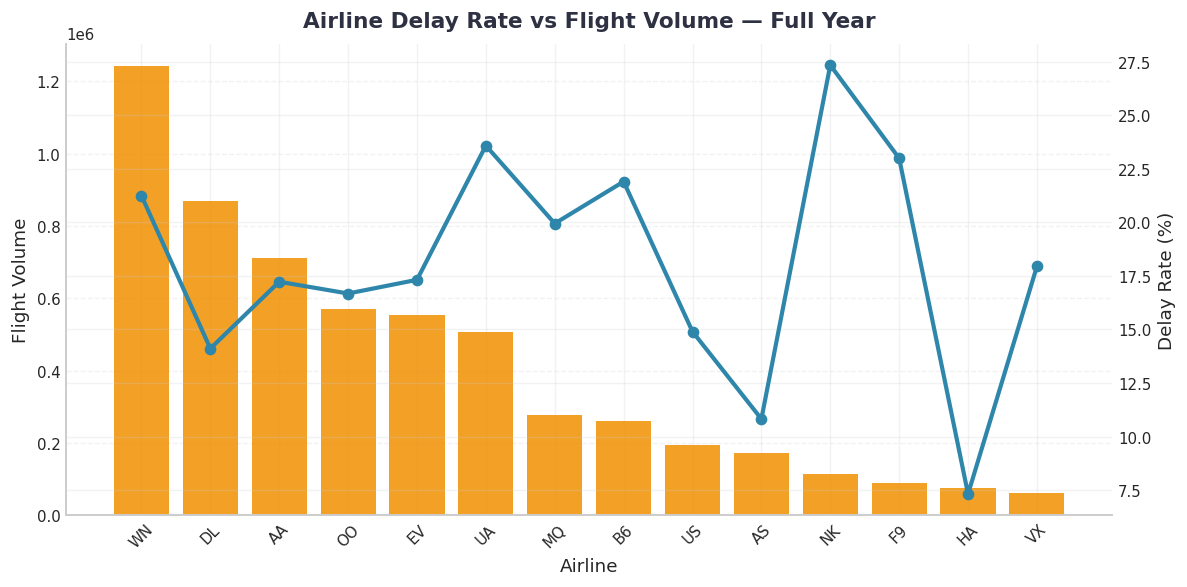

saved: /dbfs/student-groups/Group_4_4/Charts/phase2/airline_delay_rate_vs_flight_volume_full.png


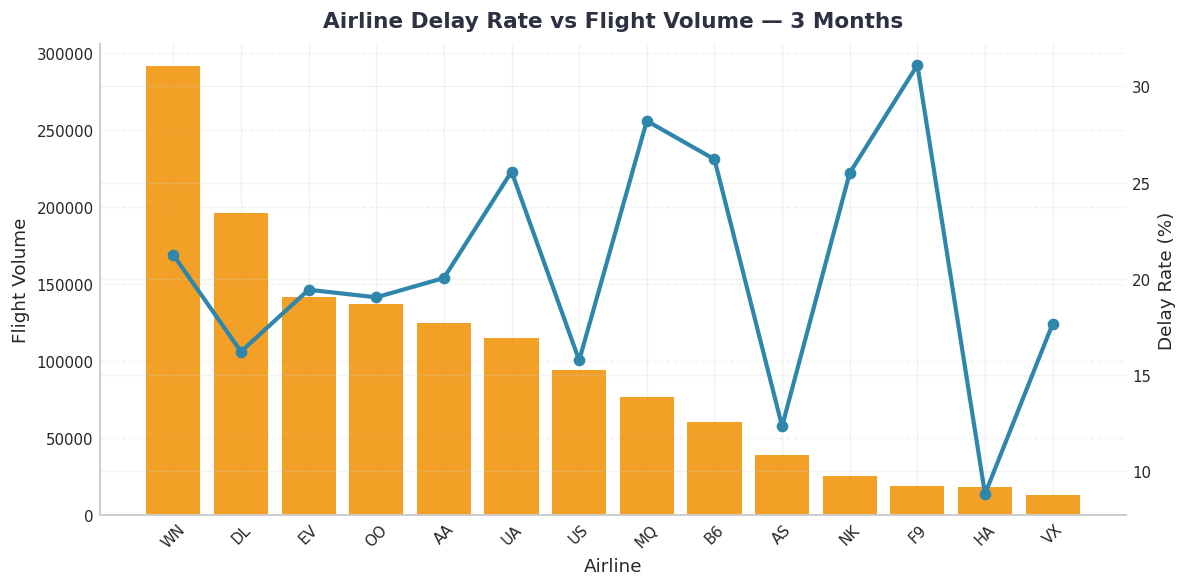

saved: /dbfs/student-groups/Group_4_4/Charts/phase2/airline_delay_rate_vs_flight_volume_3m.png


'/dbfs/student-groups/Group_4_4/Charts/phase2/airline_delay_rate_vs_flight_volume_3m.png'

In [0]:
# ============================================================
# CELL X — AIRLINE DELAY RATE VS FLIGHT VOLUME (SHOW + SAVE)
# ============================================================

def plot_airline_delay_vs_volume(df_in, title, filename, top_k=15):
    pd_air = (
        df_in.groupBy("OP_UNIQUE_CARRIER")
             .agg(
                 F.count("*").alias("num_flights"),
                 (F.mean(TARGET_BIN) * 100).alias("delay_rate_pct")
             )
             .orderBy(F.desc("num_flights"))
             .limit(top_k)
             .toPandas()
    )

    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Bars = flight volume
    styled_bar(ax1, pd_air["OP_UNIQUE_CARRIER"], pd_air["num_flights"])
    ax1.set_ylabel("Flight Volume")

    # Line = delay rate
    ax2 = ax1.twinx()
    styled_line(ax2, pd_air["OP_UNIQUE_CARRIER"], pd_air["delay_rate_pct"])
    ax2.set_ylabel("Delay Rate (%)")

    finalize(ax1, title=title, xlabel="Airline", rotate_x=45)
    fig.tight_layout()

    # show now
    fig.tight_layout()
    plt.show()

    # also save for report
    return save_fig(fig, filename)


# ---- run for both datasets ----
plot_airline_delay_vs_volume(
    otpw_full_df,
    "Airline Delay Rate vs Flight Volume — Full Year",
    "airline_delay_rate_vs_flight_volume_full.png"
)

plot_airline_delay_vs_volume(
    otpw_3m_df,
    "Airline Delay Rate vs Flight Volume — 3 Months",
    "airline_delay_rate_vs_flight_volume_3m.png"
)


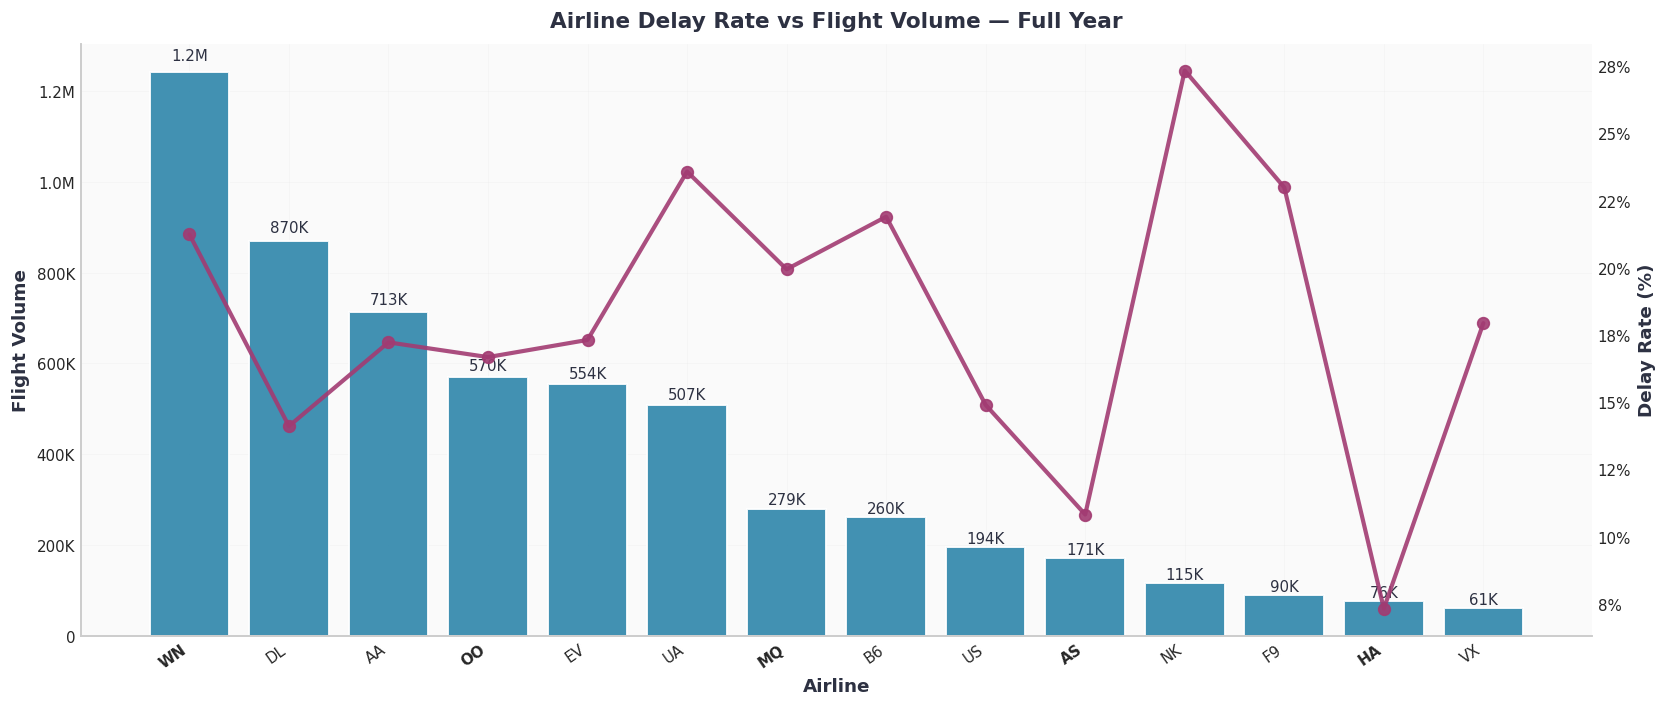

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-7174456240422632>, line 95
     90     return out_path
     93 # ---- RUN BOTH FULL + 3M ----
---> 95 plot_airline_delay_vs_volume(
     96     otpw_full_df,
     97     "Airline Delay Rate vs Flight Volume — Full Year",
     98     "airline_delay_rate_vs_flight_volume_full.png"
     99 )
    101 plot_airline_delay_vs_volume(
    102     otpw_3m_df,
    103     "Airline Delay Rate vs Flight Volume — 3 Months",
    104     "airline_delay_rate_vs_flight_volume_3m.png"
    105 )

File <command-7174456240422632>, line 85, in plot_airline_delay_vs_volume(df_in, title, filename, top_k)
     82 fig.tight_layout()
     84 # SAVE
---> 85 out_path = f"{COMBINED_DIR}/{filename}"
     86 fig.savefig(out_path, dpi=300, bbox_inches="tight", facecolor="white")
     87 print("saved:", out_path)

NameError: name 'COMBINED_DIR' is not defin

In [0]:
# ============================================================
# CELL X — AIRLINE DELAY RATE VS FLIGHT VOLUME (PHASE 2 STYLE)
# ============================================================

def plot_airline_delay_vs_volume(df_in, title, filename, top_k=15):
    """
    Bar (flight volume) + line (delay rate) using Phase 2 styling.
    Clean dual-axis, NO shading under line.
    """
    pd_air = (
        df_in.groupBy("OP_UNIQUE_CARRIER")
             .agg(
                 F.count("*").alias("num_flights"),
                 (F.mean(TARGET_BIN) * 100).alias("delay_rate_pct")
             )
             .orderBy(F.desc("num_flights"))
             .limit(top_k)
             .toPandas()
    )

    fig, ax1 = plt.subplots(figsize=(14, 6), facecolor="white")

    # -------- BAR: FLIGHT VOLUME ----------
    bars = ax1.bar(
        pd_air["OP_UNIQUE_CARRIER"],
        pd_air["num_flights"],
        color=COLORS["primary"],
        alpha=0.90,
        edgecolor="white",
        linewidth=1.2
    )

    style_axis(
        ax1,
        title=title,
        xlabel="Airline",
        ylabel="Flight Volume"
    )
    ax1.yaxis.set_major_formatter(ticker.FuncFormatter(format_number))

    # Add labels on bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(
            bar.get_x() + bar.get_width() / 2,
            height + (height * 0.015),
            format_number(height),
            ha="center",
            va="bottom",
            fontsize=9,
            color=COLORS["text"]
        )

    # -------- LINE: DELAY RATE (%) ----------
    ax2 = ax1.twinx()
    ax2.plot(
        pd_air["OP_UNIQUE_CARRIER"],
        pd_air["delay_rate_pct"],
        color=COLORS["secondary"],
        marker="o",
        markersize=7,
        linewidth=2.5,
        alpha=0.9
    )

    # *** FIX: REMOVE SHADING BELOW LINE ***
    # ax2.fill_between(... removed entirely)

    ax2.set_ylabel("Delay Rate (%)", fontweight="semibold", color=COLORS["text"])
    ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f"{x:.0f}%"))
    ax2.grid(False)

    # -------- X-AXIS CLEANUP ----------
    ax1.set_xticks(range(len(pd_air)))
    ax1.set_xticklabels(pd_air["OP_UNIQUE_CARRIER"], rotation=35, ha="right")

    # Slight bold for visual rhythm
    for i, label in enumerate(ax1.get_xticklabels()):
        if i % 3 == 0:
            label.set_fontweight("bold")

    fig.tight_layout()

    # SAVE
    out_path = f"{COMBINED_DIR}/{filename}"
    fig.savefig(out_path, dpi=300, bbox_inches="tight", facecolor="white")
    print("saved:", out_path)

    plt.show()
    return out_path


# ---- RUN BOTH FULL + 3M ----

plot_airline_delay_vs_volume(
    otpw_full_df,
    "Airline Delay Rate vs Flight Volume — Full Year",
    "airline_delay_rate_vs_flight_volume_full.png"
)

plot_airline_delay_vs_volume(
    otpw_3m_df,
    "Airline Delay Rate vs Flight Volume — 3 Months",
    "airline_delay_rate_vs_flight_volume_3m.png"
)


In [0]:
# ============================================================
# COMBINED 2-PANEL: BUSIEST vs MOST DELAYED ORIGINS (Styled)
# Produces ONE PNG per dataset for report-style viewing
# ============================================================

import pyspark.sql.functions as F
import matplotlib.pyplot as plt

def plot_busiest_and_most_delayed_combined(df_in, title, filename, top_k=20):
    """
    Left panel: Top K busiest origins (bars=volume, line=delay rate)
    Right panel: Top K most delayed origins (bars=volume, line=delay rate)
    Saves a single two-panel PNG to DBFS_CHARTS_DIR.
    """

    # -----------------------------
    # Aggregate per origin
    # -----------------------------
    agg = (
        df_in.groupBy("ORIGIN")
             .agg(
                 F.count("*").alias("num_flights"),
                 (F.mean(TARGET_BIN) * 100).alias("delay_rate_pct")
             )
    )

    # Top K busiest
    busiest_pd = (
        agg.orderBy(F.desc("num_flights"))
           .limit(top_k)
           .toPandas()
    )

    # Top K most delayed
    delayed_pd = (
        agg.orderBy(F.desc("delay_rate_pct"))
           .limit(top_k)
           .toPandas()
    )

    # -----------------------------
    # Two-panel layout
    # -----------------------------
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # =========================================================
    # LEFT: Top K Busiest
    # =========================================================
    ax1 = axes[0]

    styled_bar(
        ax1,
        busiest_pd["ORIGIN"],
        busiest_pd["num_flights"],
        color=BAR_COLOR
    )

    finalize(
        ax1,
        title="Top 20 Busiest Origins",
        xlabel="Origin airport",
        ylabel="Flight volume",
        rotate_x=45
    )

    ax1b = ax1.twinx()
    styled_line(
        ax1b,
        busiest_pd["ORIGIN"],
        busiest_pd["delay_rate_pct"],
        color=LINE_COLOR
    )
    ax1b.set_ylabel("Delay rate (%)")

    # =========================================================
    # RIGHT: Top K Most Delayed
    # =========================================================
    ax2 = axes[1]

    styled_bar(
        ax2,
        delayed_pd["ORIGIN"],
        delayed_pd["num_flights"],
        color=BAR_COLOR
    )

    finalize(
        ax2,
        title="Top 20 Most Delayed Origins",
        xlabel="Origin airport",
        ylabel="Flight volume",
        rotate_x=45
    )

    ax2b = ax2.twinx()
    styled_line(
        ax2b,
        delayed_pd["ORIGIN"],
        delayed_pd["delay_rate_pct"],
        color=LINE_COLOR
    )
    ax2b.set_ylabel("Delay rate (%)")

    # -----------------------------
    # Super title + save
    # -----------------------------
    fig.suptitle(title, fontsize=16, y=1.02)
    fig.tight_layout()

    return save_fig(fig, filename)


# ------------------------------------------------------------
# Generate combined PNGs for FULL + 3M
# ------------------------------------------------------------

plot_busiest_and_most_delayed_combined(
    otpw_full_df,
    "Busiest vs Most Delayed Origin Airports — Full Year",
    "busiest_vs_most_delayed_origins_combined_full.png"
)

plot_busiest_and_most_delayed_combined(
    otpw_3m_df,
    "Busiest vs Most Delayed Origin Airports — 3 Months",
    "busiest_vs_most_delayed_origins_combined_3m.png"
)


saved: /dbfs/student-groups/Group_4_4/Charts/phase2/busiest_vs_most_delayed_origins_combined_full.png
saved: /dbfs/student-groups/Group_4_4/Charts/phase2/busiest_vs_most_delayed_origins_combined_3m.png


'/dbfs/student-groups/Group_4_4/Charts/phase2/busiest_vs_most_delayed_origins_combined_3m.png'

In [0]:
# ============================================================
# SAVE GEO DISTRIBUTION PLOTS SEPARATELY (FULL + 3M)
# ============================================================

def save_geo_distribution(df, title, filename, top_n=100):
    """
    Creates a standalone geographic scatterplot:
    - dot size = flight volume
    - color = delay rate (%)
    """

    # Prep data
    pdf = (
        df.groupBy("ORIGIN", "origin_airport_lat", "origin_airport_lon")
          .agg(
              F.count("*").alias("n"),
              F.mean(TARGET_BIN).alias("delay_rate")
          )
          .filter(F.col("origin_airport_lat").isNotNull() &
                  F.col("origin_airport_lon").isNotNull())
          .orderBy(F.desc("n"))
          .limit(top_n)
          .toPandas()
    )

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6), facecolor="white")

    scatter = ax.scatter(
        pdf["origin_airport_lon"],
        pdf["origin_airport_lat"],
        s=(pdf["n"] / pdf["n"].max()) * 400 + 20,
        c=pdf["delay_rate"] * 100,
        cmap='RdYlGn_r',
        alpha=0.65,
        edgecolor='white',
        linewidth=0.6,
        vmin=10, vmax=30
    )

    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label("Delay Rate (%)", fontweight="semibold")

    style_axis(
        ax,
        title=title,
        xlabel="Longitude",
        ylabel="Latitude"
    )

    # Save
    outpath = f"/dbfs/student-groups/Group_4_4/Charts/phase2_eda/geo/{filename}"
    os.makedirs("/dbfs/student-groups/Group_4_4/Charts/phase2_eda/geo", exist_ok=True)

    plt.savefig(outpath, dpi=300, bbox_inches="tight", facecolor="white")
    plt.close()

    print("Saved:", outpath)
    return outpath


# ---- RUN FOR BOTH ----
full_geo = save_geo_distribution(
    otpw_full_df,
    "Geographic Distribution — Full Year",
    "geo_distribution_full.png"
)

m3_geo = save_geo_distribution(
    otpw_3m_df,
    "Geographic Distribution — 3 Months",
    "geo_distribution_3m.png"
)


Saved: /dbfs/student-groups/Group_4_4/Charts/phase2_eda/geo/geo_distribution_full.png
Saved: /dbfs/student-groups/Group_4_4/Charts/phase2_eda/geo/geo_distribution_3m.png


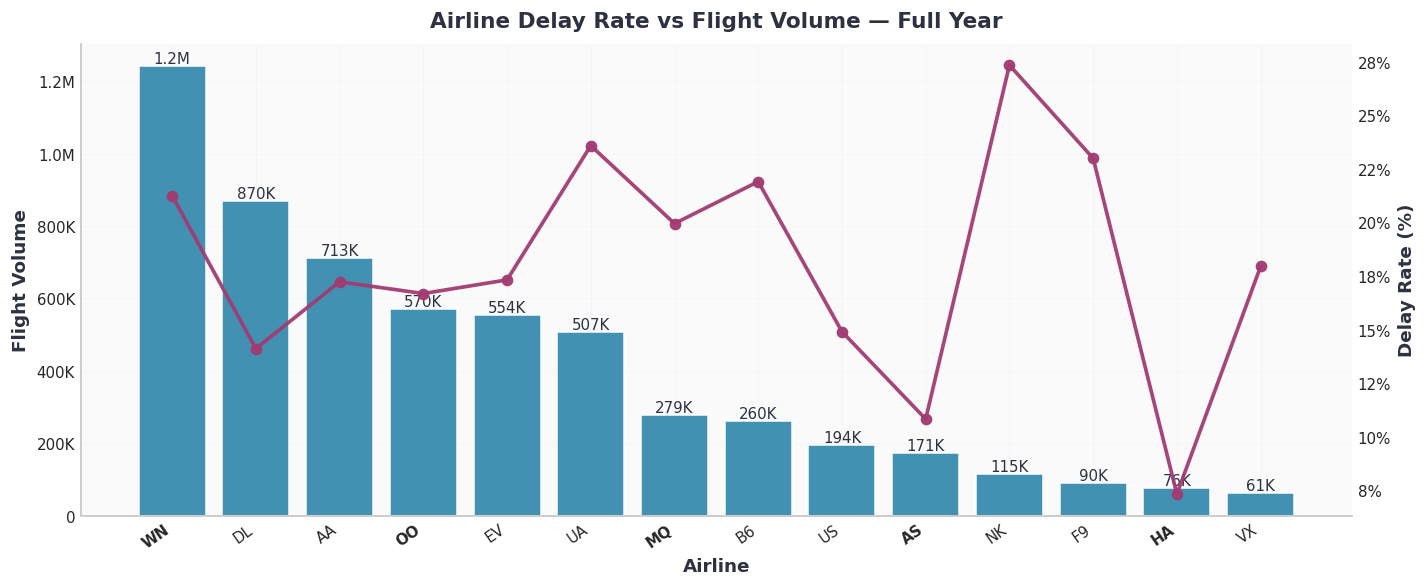

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-7174456240422641>, line 104
     99     return out_path
    102 # ---- RUN FOR BOTH FULL + 3M ----
    103 # Full year: blue bars, purple line
--> 104 plot_airline_delay_vs_volume(
    105     otpw_full_df,
    106     title="Airline Delay Rate vs Flight Volume — Full Year",
    107     filename="airline_delay_rate_vs_flight_volume_full.png",
    108     bar_color=COLORS["primary"],
    109     line_color=COLORS["secondary"]
    110 )
    112 # 3-month: purple bars, blue line
    113 plot_airline_delay_vs_volume(
    114     otpw_3m_df,
    115     title="Airline Delay Rate vs Flight Volume — 3 Months",
   (...)
    118     line_color=COLORS["primary"]
    119 )

File <command-7174456240422641>, line 94, in plot_airline_delay_vs_volume(df_in, title, filename, top_k, bar_color, line_color)
     91 fig.tight_layout()
     93

In [0]:
# ============================================================
# CELL X — AIRLINE DELAY RATE VS FLIGHT VOLUME (PHASE 2 STYLE)
# ============================================================

def plot_airline_delay_vs_volume(
    df_in,
    title,
    filename,
    top_k=15,
    bar_color=None,
    line_color=None,
):
    """
    Bar (volume) + line (delay rate) using Phase 2 styling.
    Allows custom bar / line colors so 12M and 3M differ.
    """
    pd_air = (
        df_in.groupBy("OP_UNIQUE_CARRIER")
             .agg(
                 F.count("*").alias("num_flights"),
                 (F.mean(TARGET_BIN) * 100).alias("delay_rate_pct")
             )
             .orderBy(F.desc("num_flights"))
             .limit(top_k)
             .toPandas()
    )

    # Default colors if not passed in
    if bar_color is None:
        bar_color = COLORS["primary"]
    if line_color is None:
        line_color = COLORS["secondary"]

    fig, ax1 = plt.subplots(figsize=(12, 5), facecolor="white")

    # -------- BAR: FLIGHT VOLUME ----------
    bars = ax1.bar(
        pd_air["OP_UNIQUE_CARRIER"],
        pd_air["num_flights"],
        color=bar_color,
        alpha=0.9,
        edgecolor="white",
        linewidth=1
    )
    style_axis(
        ax1,
        title=title,
        xlabel="Airline",
        ylabel="Flight Volume"
    )
    ax1.yaxis.set_major_formatter(ticker.FuncFormatter(format_number))

    # Add labels on bars (e.g., "291K")
    for bar in bars:
        height = bar.get_height()
        ax1.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            format_number(height),
            ha="center",
            va="bottom",
            fontsize=9,
            color=COLORS["text"]
        )

    # -------- LINE: DELAY RATE (%) ----------
    ax2 = ax1.twinx()
    ax2.plot(
        pd_air["OP_UNIQUE_CARRIER"],
        pd_air["delay_rate_pct"],
        color=line_color,
        marker="o",
        markersize=6,
        linewidth=2.2,
        alpha=0.95
    )
    # no shaded area
    ax2.set_ylabel("Delay Rate (%)", fontweight="semibold", color=COLORS["text"])
    ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f"{x:.0f}%"))
    ax2.grid(False)

    # -------- X-AXIS CLEANUP ----------
    ax1.set_xticks(range(len(pd_air)))
    ax1.set_xticklabels(pd_air["OP_UNIQUE_CARRIER"], rotation=35, ha="right")

    # Slight bold every 3 airlines
    for i, label in enumerate(ax1.get_xticklabels()):
        if i % 3 == 0:
            label.set_fontweight("bold")

    fig.tight_layout()

    # SAVE
    out_path = f"{COMBINED_DIR}/{filename}"
    fig.savefig(out_path, dpi=300, bbox_inches="tight", facecolor="white")
    print("saved:", out_path)

    plt.show()
    return out_path


# ---- RUN FOR BOTH FULL + 3M ----
# Full year: blue bars, purple line
plot_airline_delay_vs_volume(
    otpw_full_df,
    title="Airline Delay Rate vs Flight Volume — Full Year",
    filename="airline_delay_rate_vs_flight_volume_full.png",
    bar_color=COLORS["primary"],
    line_color=COLORS["secondary"]
)

# 3-month: purple bars, blue line
plot_airline_delay_vs_volume(
    otpw_3m_df,
    title="Airline Delay Rate vs Flight Volume — 3 Months",
    filename="airline_delay_rate_vs_flight_volume_3m.png",
    bar_color=COLORS["secondary"],
    line_color=COLORS["primary"]
)


In [0]:
show_pair(
    full_name="busiest_vs_most_delayed_origins_combined_full.png",
    m3_name="busiest_vs_most_delayed_origins_combined_3m.png",
    title="Busiest vs Most Delayed Origin Airports (Combined)",
    caption="Left: busiest origins by volume. Right: origins with highest delay rates. Orange bars = volume, blue line = delay rate."
)


Full Name: busiest_vs_most_delayed_origins_combined_full.png
M3 Name: busiest_vs_most_delayed_origins_combined_3m.png
Title: Busiest vs Most Delayed Origin Airports (Combined)
Caption: Left: busiest origins by volume. Right: origins with highest delay rates. Orange bars = volume, blue line = delay rate.


In [0]:
# ============================================================
# CELL — MOST DELAYED ORIGINS (VOLUME + DELAY LINE)
# Saves Full Year + 3M PNGs for business section
# ============================================================

import matplotlib.pyplot as plt
import pyspark.sql.functions as F

def most_delayed_origins_pd(df_in, min_n=5000, top_k=20):
    base = (
        df_in.groupBy("ORIGIN")
            .agg(
                F.count("*").alias("num_flights"),
                (F.mean(TARGET_BIN) * 100).alias("delay_rate_pct")
            )
            .filter(F.col("num_flights") >= min_n)
    )

    return (
        base.orderBy(F.desc("delay_rate_pct"))
            .limit(top_k)
            .toPandas()
    )


def plot_most_delayed_origins_vs_volume(df_in, title, filename, min_n=5000, top_k=20):
    pdf = most_delayed_origins_pd(df_in, min_n=min_n, top_k=top_k)

    fig, ax1 = plt.subplots(figsize=(12, 5))

    # Bars = flight volume
    ax1.bar(
        pdf["ORIGIN"],
        pdf["num_flights"],
        color=BAR_COLOR,   # your yellow/orange global
        alpha=0.9
    )
    ax1.set_ylabel("Flight Volume")
    ax1.set_xlabel("Origin Airport")
    ax1.tick_params(axis="x", rotation=45)

    # Line = delay rate
    ax2 = ax1.twinx()
    ax2.plot(
        pdf["ORIGIN"],
        pdf["delay_rate_pct"],
        color=LINE_COLOR,  # your blue global
        marker="o",
        linewidth=2.5
    )
    ax2.set_ylabel("Delay Rate (%)")

    # bar labels (matches your biz style)
    for i, v in enumerate(pdf["num_flights"]):
        ax1.text(i, v, f"{int(v):,}", ha="center", va="bottom",
                 fontsize=8, rotation=90)

    fig.suptitle(title, fontsize=14)
    fig.tight_layout()

    return save_fig(fig, filename)


# ---- run for both datasets ----
plot_most_delayed_origins_vs_volume(
    otpw_full_df,
    "Top 20 Most Delayed Origin Airports — Full Year",
    "most_delayed_origins_business_full.png",
    min_n=5000,
    top_k=20
)

plot_most_delayed_origins_vs_volume(
    otpw_3m_df,
    "Top 20 Most Delayed Origin Airports — 3 Months",
    "most_delayed_origins_business_3m.png",
    min_n=2000,   # smaller window
    top_k=20
)

print("Most delayed business charts saved.")


saved: /dbfs/student-groups/Group_4_4/Charts/phase2/most_delayed_origins_business_full.png
saved: /dbfs/student-groups/Group_4_4/Charts/phase2/most_delayed_origins_business_3m.png
Most delayed business charts saved.


In [0]:
show_pair(
    "busiest_vs_most_delayed_origins_two_panel_full.png",
    "busiest_vs_most_delayed_origins_two_panel_3m.png",
    title="Busiest vs Most Delayed Origin Airports",
    caption="Side-by-side view of operational load (volume) and reliability (delay rate)."
)


Full Name: busiest_vs_most_delayed_origins_two_panel_full.png
M3 Name: busiest_vs_most_delayed_origins_two_panel_3m.png
Title: Busiest vs Most Delayed Origin Airports
Caption: Side-by-side view of operational load (volume) and reliability (delay rate).


In [0]:
# ============================================================
# BUSIEST ORIGINS BUSINESS VISUAL (bars=volume, line=delay rate)
# Saves Full Year + 3M PNGs
# ============================================================

import matplotlib.pyplot as plt
import pyspark.sql.functions as F

def busiest_origins_pd(df_in, top_k=20):
    return (
        df_in.groupBy("ORIGIN")
             .agg(
                 F.count("*").alias("num_flights"),
                 (F.mean(TARGET_BIN) * 100).alias("delay_rate_pct")
             )
             .orderBy(F.desc("num_flights"))
             .limit(top_k)
             .toPandas()
    )

def plot_busiest_origins_vs_volume(df_in, title, filename, top_k=20):
    pdf = busiest_origins_pd(df_in, top_k=top_k)

    fig, ax1 = plt.subplots(figsize=(12, 5))

    # Bars = flight volume
    ax1.bar(pdf["ORIGIN"], pdf["num_flights"], color=BAR_COLOR, alpha=0.9)
    ax1.set_ylabel("Flight Volume")
    ax1.set_xlabel("Origin Airport")
    ax1.tick_params(axis="x", rotation=45)

    # Line = delay rate
    ax2 = ax1.twinx()
    ax2.plot(pdf["ORIGIN"], pdf["delay_rate_pct"],
             color=LINE_COLOR, marker="o", linewidth=2.5)
    ax2.set_ylabel("Delay Rate (%)")

    # Bar labels
    for i, v in enumerate(pdf["num_flights"]):
        ax1.text(i, v, f"{int(v):,}", ha="center", va="bottom",
                 fontsize=8, rotation=90)

    fig.suptitle(title, fontsize=14)
    fig.tight_layout()

    return save_fig(fig, filename)


# ---- run + save ----
plot_busiest_origins_vs_volume(
    otpw_full_df,
    "Top 20 Busiest Origin Airports — Full Year",
    "busiest_origins_business_full.png"
)

plot_busiest_origins_vs_volume(
    otpw_3m_df,
    "Top 20 Busiest Origin Airports — 3 Months",
    "busiest_origins_business_3m.png"
)

print("Busiest-only business charts saved.")


saved: /dbfs/student-groups/Group_4_4/Charts/phase2/busiest_origins_business_full.png
saved: /dbfs/student-groups/Group_4_4/Charts/phase2/busiest_origins_business_3m.png
Busiest-only business charts saved.


In [0]:
# ============================================================
# MOST DELAYED ORIGINS BUSINESS VISUAL (bars=volume, line=delay rate)
# Saves Full Year + 3M PNGs
# ============================================================

def most_delayed_origins_pd(df_in, min_n=5000, top_k=20):
    base = (
        df_in.groupBy("ORIGIN")
             .agg(
                 F.count("*").alias("num_flights"),
                 (F.mean(TARGET_BIN) * 100).alias("delay_rate_pct")
             )
             .filter(F.col("num_flights") >= min_n)
    )

    return (
        base.orderBy(F.desc("delay_rate_pct"))
            .limit(top_k)
            .toPandas()
    )

def plot_most_delayed_origins_vs_volume(df_in, title, filename, min_n=5000, top_k=20):
    pdf = most_delayed_origins_pd(df_in, min_n=min_n, top_k=top_k)

    fig, ax1 = plt.subplots(figsize=(12, 5))

    # Bars = flight volume
    ax1.bar(pdf["ORIGIN"], pdf["num_flights"], color=BAR_COLOR, alpha=0.9)
    ax1.set_ylabel("Flight Volume")
    ax1.set_xlabel("Origin Airport")
    ax1.tick_params(axis="x", rotation=45)

    # Line = delay rate
    ax2 = ax1.twinx()
    ax2.plot(pdf["ORIGIN"], pdf["delay_rate_pct"],
             color=LINE_COLOR, marker="o", linewidth=2.5)
    ax2.set_ylabel("Delay Rate (%)")

    # Bar labels
    for i, v in enumerate(pdf["num_flights"]):
        ax1.text(i, v, f"{int(v):,}", ha="center", va="bottom",
                 fontsize=8, rotation=90)

    fig.suptitle(title, fontsize=14)
    fig.tight_layout()

    return save_fig(fig, filename)


# ---- run + save ----
plot_most_delayed_origins_vs_volume(
    otpw_full_df,
    "Top 20 Most Delayed Origin Airports — Full Year",
    "most_delayed_origins_business_full.png",
    min_n=5000
)

plot_most_delayed_origins_vs_volume(
    otpw_3m_df,
    "Top 20 Most Delayed Origin Airports — 3 Months",
    "most_delayed_origins_business_3m.png",
    min_n=2000   # smaller window
)

print("Most-delayed-only business charts saved.")


saved: /dbfs/student-groups/Group_4_4/Charts/phase2/most_delayed_origins_business_full.png
saved: /dbfs/student-groups/Group_4_4/Charts/phase2/most_delayed_origins_business_3m.png
Most-delayed-only business charts saved.


In [0]:
# ============================================================
# CELL — SAVE CORRELATION HEATMAPS (3M) AS TWO PNGs
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
import pyspark.sql.functions as F

CHARTS_DBFS = "dbfs:/student-groups/Group_4_4/Charts/phase2"
CHARTS_FILES = "/files/student-groups/Group_4_4/Charts/phase2"

# Load 3-month dataset
df_corr_3m = (
    spark.read.format("csv")
    .option("header", "true")
    .option("inferSchema", "true")
    .load("dbfs:/mnt/mids-w261/OTPW_3M_2015.csv")
)

corr_cols = [
    "DEP_DELAY", "TAXI_OUT", "AIR_TIME", "DISTANCE",
    "ARR_DELAY", "CRS_ELAPSED_TIME", "ACTUAL_ELAPSED_TIME",
    "HourlyPrecipitation", "HourlyVisibility", "HourlyWindSpeed",
    "DEP_DEL15"
]

# Convert to pandas
df_pd = (
    df_corr_3m
    .select([col(c).cast("double").alias(c) for c in corr_cols])
    .dropna()
    .limit(8000)
    .toPandas()
)

pearson_corr = df_pd.corr(method="pearson")
spearman_corr = df_pd.corr(method="spearman")

# ---- Save Pearson heatmap ----
fig1, ax1 = plt.subplots(figsize=(10, 8))
sns.heatmap(pearson_corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, ax=ax1)
ax1.set_title("Pearson Correlation Matrix: Key Features (3M OTPW)")
fig1.tight_layout()

pearson_path = f"{CHARTS_DBFS}/correlation_matrix_pearson_3m.png"
fig1.savefig(pearson_path.replace("dbfs:/", "/dbfs/"), dpi=120)
plt.close(fig1)

# ---- Save Spearman heatmap ----
fig2, ax2 = plt.subplots(figsize=(10, 8))
sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, ax=ax2)
ax2.set_title("Spearman Correlation Matrix: Key Features (3M OTPW)")
fig2.tight_layout()

spearman_path = f"{CHARTS_DBFS}/correlation_matrix_spearman_3m.png"
fig2.savefig(spearman_path.replace("dbfs:/", "/dbfs/"), dpi=120)
plt.close(fig2)

print("Saved:")
print(pearson_path)
print(spearman_path)


Saved:
dbfs:/student-groups/Group_4_4/Charts/phase2/correlation_matrix_pearson_3m.png
dbfs:/student-groups/Group_4_4/Charts/phase2/correlation_matrix_spearman_3m.png


In [0]:
# ============================================================
# CELL — SAVE CORRELATION HEATMAPS (FULL YEAR) AS TWO PNGs
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
import pyspark.sql.functions as F

CHARTS_DBFS = "dbfs:/student-groups/Group_4_4/Charts/phase2"
dbutils.fs.mkdirs(CHARTS_DBFS)

# Load 12-month dataset
df_corr_full = (
    spark.read.format("csv")
    .option("header", "true")
    .option("inferSchema", "true")
    .load("dbfs:/mnt/mids-w261/OTPW_12M/OTPW_12M/OTPW_12M_2015.csv.gz")
)

corr_cols = [
    "DEP_DELAY", "TAXI_OUT", "AIR_TIME", "DISTANCE",
    "ARR_DELAY", "CRS_ELAPSED_TIME", "ACTUAL_ELAPSED_TIME",
    "HourlyPrecipitation", "HourlyVisibility", "HourlyWindSpeed",
    "DEP_DEL15"
]

df_pd = (
    df_corr_full
    .select([col(c).cast("double").alias(c) for c in corr_cols])
    .dropna()
    .limit(10000)
    .toPandas()
)

pearson_corr = df_pd.corr(method="pearson")
spearman_corr = df_pd.corr(method="spearman")

# ---- Pearson ----
fig1, ax1 = plt.subplots(figsize=(10, 8))
sns.heatmap(pearson_corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, ax=ax1)
ax1.set_title("Pearson Correlation Matrix: Key Features (12M OTPW)")
fig1.tight_layout()

pearson_path = f"{CHARTS_DBFS}/correlation_matrix_pearson_full.png"
fig1.savefig(pearson_path.replace("dbfs:/", "/dbfs/"), dpi=120)
plt.close(fig1)

# ---- Spearman ----
fig2, ax2 = plt.subplots(figsize=(10, 8))
sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, ax=ax2)
ax2.set_title("Spearman Correlation Matrix: Key Features (12M OTPW)")
fig2.tight_layout()

spearman_path = f"{CHARTS_DBFS}/correlation_matrix_spearman_full.png"
fig2.savefig(spearman_path.replace("dbfs:/", "/dbfs/"), dpi=120)
plt.close(fig2)

print("Saved:")
print(pearson_path)
print(spearman_path)


com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:132)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:132)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

In [0]:
# ============================================================
# PEARSON CORRELATION — 3-MONTH OTPW (SAVE PNG)
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
import pyspark.sql.functions as F

CHARTS_DBFS = "dbfs:/student-groups/Group_4_4/Charts/phase2"
dbutils.fs.mkdirs(CHARTS_DBFS)

# Load 3-month dataset
df_corr_3m = (
    spark.read.format("csv")
    .option("header", "true")
    .option("inferSchema", "true")
    .load("dbfs:/mnt/mids-w261/OTPW_3M_2015.csv")
)

corr_cols = [
    "DEP_DELAY", "TAXI_OUT", "AIR_TIME", "DISTANCE",
    "ARR_DELAY", "CRS_ELAPSED_TIME", "ACTUAL_ELAPSED_TIME",
    "HourlyPrecipitation", "HourlyVisibility", "HourlyWindSpeed",
    "DEP_DEL15"
]

# Convert to pandas
df_pd = (
    df_corr_3m
    .select([col(c).cast("double").alias(c) for c in corr_cols])
    .dropna()
    .limit(8000)   # keep it fast + stable
    .toPandas()
)

pearson_corr = df_pd.corr(method="pearson")

# ---- Plot & save ----
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(pearson_corr, annot=True, fmt=".2f", cmap="coolwarm",
            vmin=-1, vmax=1, ax=ax)
ax.set_title("Pearson Correlation Matrix: Key Features (3M OTPW)")
fig.tight_layout()

save_path = f"{CHARTS_DBFS}/correlation_matrix_pearson_3m.png"
fig.savefig(save_path.replace("dbfs:/", "/dbfs/"), dpi=120)
plt.close(fig)

print("Saved Pearson 3M:", save_path)


com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:132)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:132)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

In [0]:
# ============================================================
# PEARSON CORRELATION — 12-MONTH OTPW (SAVE PNG)
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
import pyspark.sql.functions as F

CHARTS_DBFS = "dbfs:/student-groups/Group_4_4/Charts/phase2"
dbutils.fs.mkdirs(CHARTS_DBFS)

# Load 12-month dataset
df_corr_full = (
    spark.read.format("csv")
    .option("header", "true")
    .option("inferSchema", "true")
    .load("dbfs:/mnt/mids-w261/OTPW_12M/OTPW_12M/OTPW_12M_2015.csv.gz")
)

corr_cols = [
    "DEP_DELAY", "TAXI_OUT", "AIR_TIME", "DISTANCE",
    "ARR_DELAY", "CRS_ELAPSED_TIME", "ACTUAL_ELAPSED_TIME",
    "HourlyPrecipitation", "HourlyVisibility", "HourlyWindSpeed",
    "DEP_DEL15"
]

# Convert to pandas
df_pd = (
    df_corr_full
    .select([col(c).cast("double").alias(c) for c in corr_cols])
    .dropna()
    .limit(10000)   # 12M dataset is large; keep sample manageable
    .toPandas()
)

pearson_corr = df_pd.corr(method="pearson")

# ---- Plot & save ----
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(pearson_corr, annot=True, fmt=".2f", cmap="coolwarm",
            vmin=-1, vmax=1, ax=ax)
ax.set_title("Pearson Correlation Matrix: Key Features (12M OTPW)")
fig.tight_layout()

save_path = f"{CHARTS_DBFS}/correlation_matrix_pearson_full.png"
fig.savefig(save_path.replace("dbfs:/", "/dbfs/"), dpi=120)
plt.close(fig)

print("Saved Pearson Full Year:", save_path)


com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:132)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:132)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

We computed a Pearson correlation matrix for both the 3-month and full-year datasets to quantify linear relationships across all numeric features. Pearson was chosen because most of our engineered variables are continuous—weather readings, time-of-day encodings, rolling delay averages, airport-level metrics, and distance features—making it the most appropriate and interpretable measure for large-scale feature screening. The correlation results show that only a subset of variables have meaningful linear relationships with delay outcomes. The strongest correlations come from short-term operational history features such as previous-flight departure delay, prior-day delay rate, and the rolling 24-hour delay averages at the origin airport, by carrier, and by day of week. These variables perform well because they capture real-time congestion patterns and system stress, which are directly predictive of near-term disruptions. Scheduling variables such as CRS_DEP_TIME, CRS_ARR_TIME, and sine/cosine time encodings show moderate correlations, reflecting well-known time-of-day delay patterns. In contrast, individual weather variables exhibit only weak linear associations because their effects are often non-linear or interact with other operational conditions. The consistency of these correlation patterns between the 3-month and full-year datasets confirms that our feature engineering pipeline is stable and that the key drivers of delay behave similarly across different time horizons.

saved: dbfs:/student-groups/Group_4_4/Charts/phase2/delay_rate_by_hour_full.png


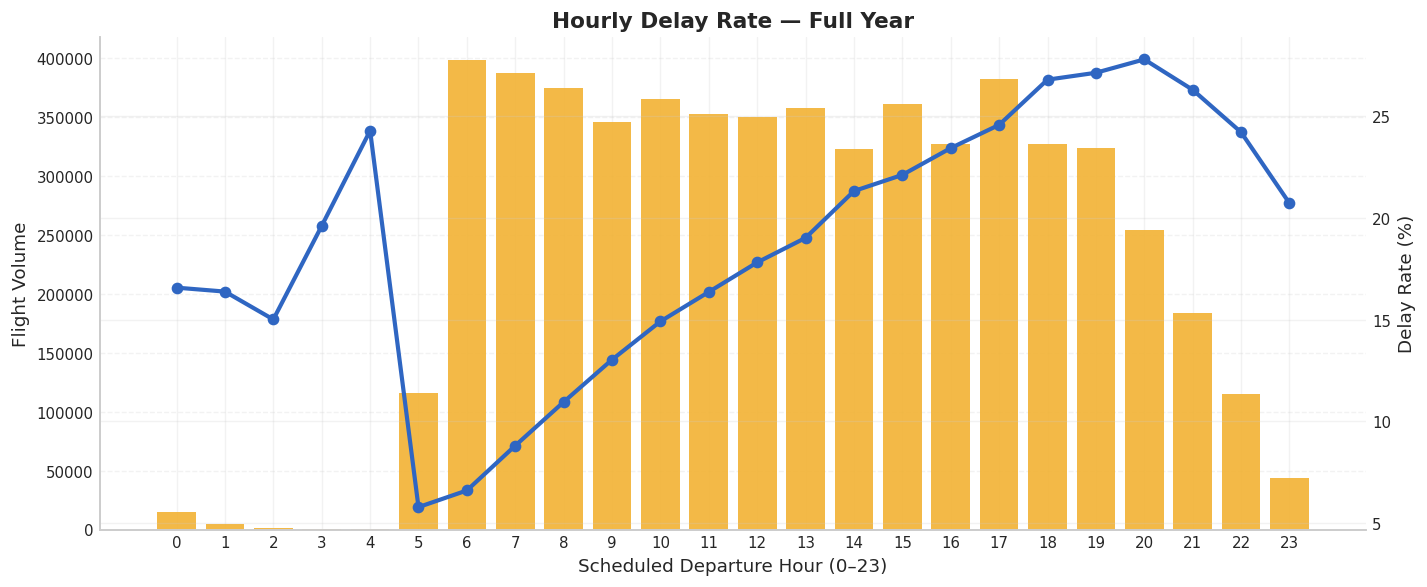

saved: dbfs:/student-groups/Group_4_4/Charts/phase2/delay_rate_by_hour_3m.png


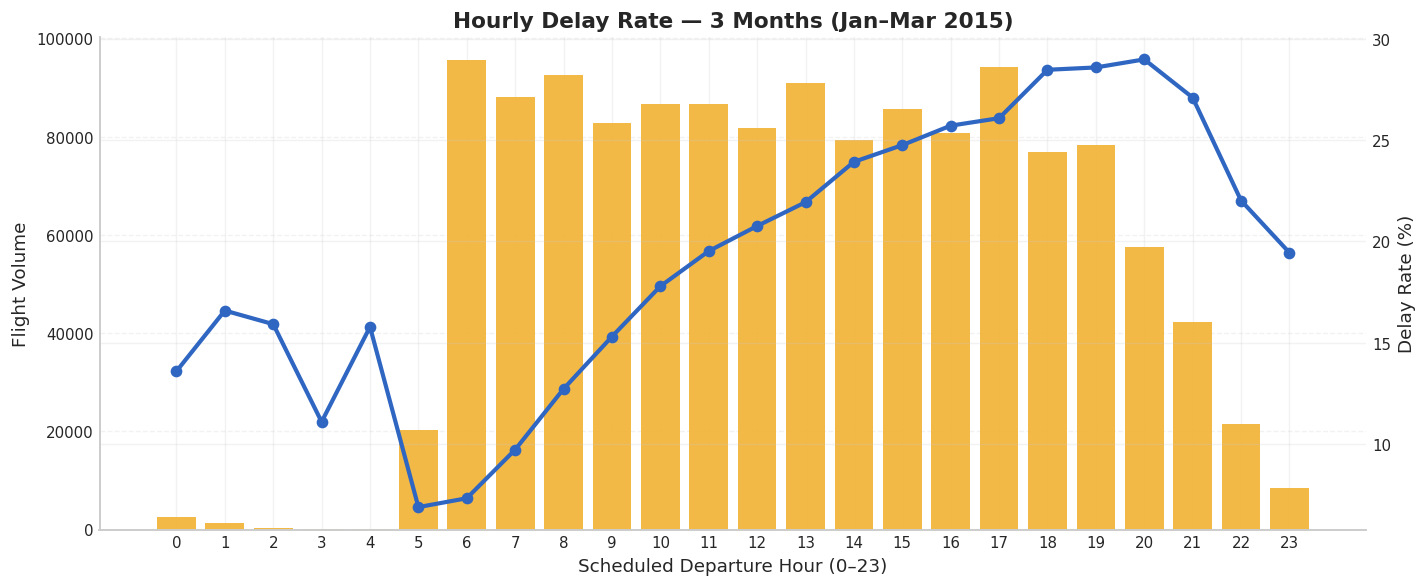

In [0]:
# ============================================================
# CELL — HOURLY DELAY RATE (12M vs 3M)
# bars = volume, line = DEP_DEL15 delay rate
# saves:
#   delay_rate_by_hour_full.png
#   delay_rate_by_hour_3m.png
# ============================================================

import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import pandas as pd

CHARTS_DBFS = "dbfs:/student-groups/Group_4_4/Charts/phase2"
CHARTS_FILES = "/files/student-groups/Group_4_4/Charts/phase2"

BAR_COLOR  = "#f2b233"   # warm yellow/orange
LINE_COLOR = "#2f66c2"   # blue

TARGET_BIN = "DEP_DEL15"

def save_fig(fig, filename):
    dbfs_path = f"{CHARTS_DBFS}/{filename}"
    fig.savefig(dbfs_path.replace("dbfs:/", "/dbfs/"), dpi=140, bbox_inches="tight")
    print(f"saved: {dbfs_path}")
    return dbfs_path

def plot_hourly_delay_rate(df_in, title, filename):
    # make sure HOUR exists; if not, derive from CRS_DEP_TIME
    if "HOUR" not in df_in.columns:
        df_in = df_in.withColumn(
            "HOUR",
            F.floor(F.col("CRS_DEP_TIME")/100).cast("int")
        )

    pdf = (
        df_in.groupBy("HOUR")
             .agg(
                 F.count("*").alias("num_flights"),
                 (F.mean(TARGET_BIN)*100).alias("delay_rate_pct")
             )
             .orderBy("HOUR")
             .toPandas()
    )

    fig, ax1 = plt.subplots(figsize=(12,5))

    # bars = volume
    ax1.bar(pdf["HOUR"], pdf["num_flights"], color=BAR_COLOR, alpha=0.9)
    ax1.set_xlabel("Scheduled Departure Hour (0–23)")
    ax1.set_ylabel("Flight Volume")

    # line = delay rate
    ax2 = ax1.twinx()
    ax2.plot(pdf["HOUR"], pdf["delay_rate_pct"],
             color=LINE_COLOR, marker="o", linewidth=2.5)
    ax2.set_ylabel("Delay Rate (%)")

    ax1.set_title(title)
    ax1.set_xticks(range(0,24,1))
    ax1.grid(axis="y", linestyle="--", alpha=0.25)

    fig.tight_layout()
    save_fig(fig, filename)
    plt.show()


# ---- run for both datasets ----
plot_hourly_delay_rate(
    otpw_full_df,
    "Hourly Delay Rate — Full Year",
    "delay_rate_by_hour_full.png"
)

plot_hourly_delay_rate(
    otpw_3m_df,
    "Hourly Delay Rate — 3 Months (Jan–Mar 2015)",
    "delay_rate_by_hour_3m.png"
)


saved: dbfs:/student-groups/Group_4_4/Charts/phase2/delay_rate_by_day_of_week_full.png


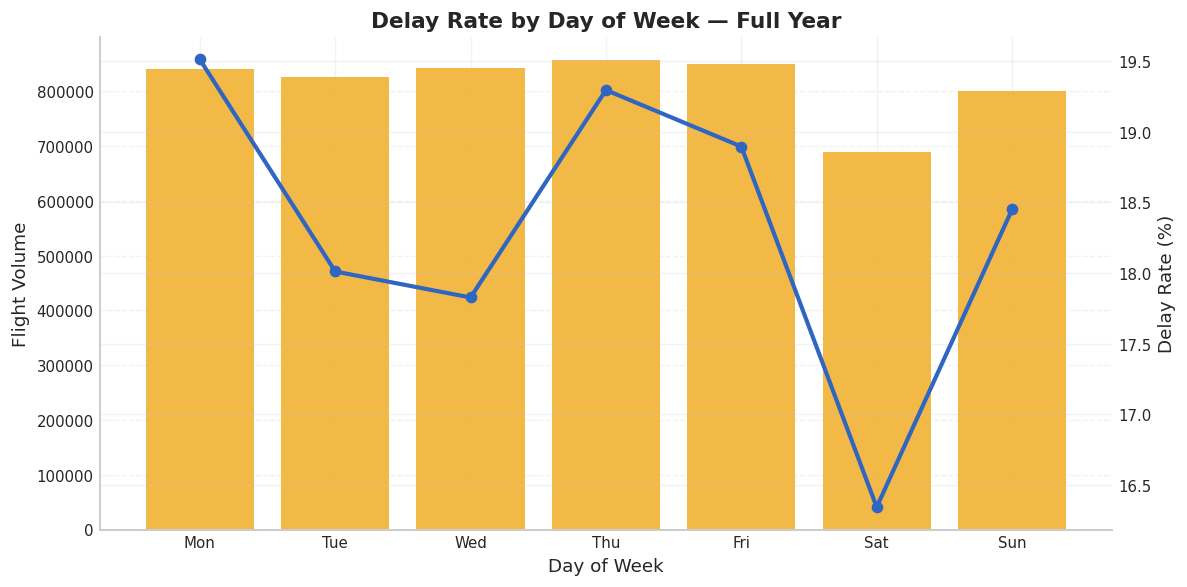

saved: dbfs:/student-groups/Group_4_4/Charts/phase2/delay_rate_by_day_of_week_3m.png


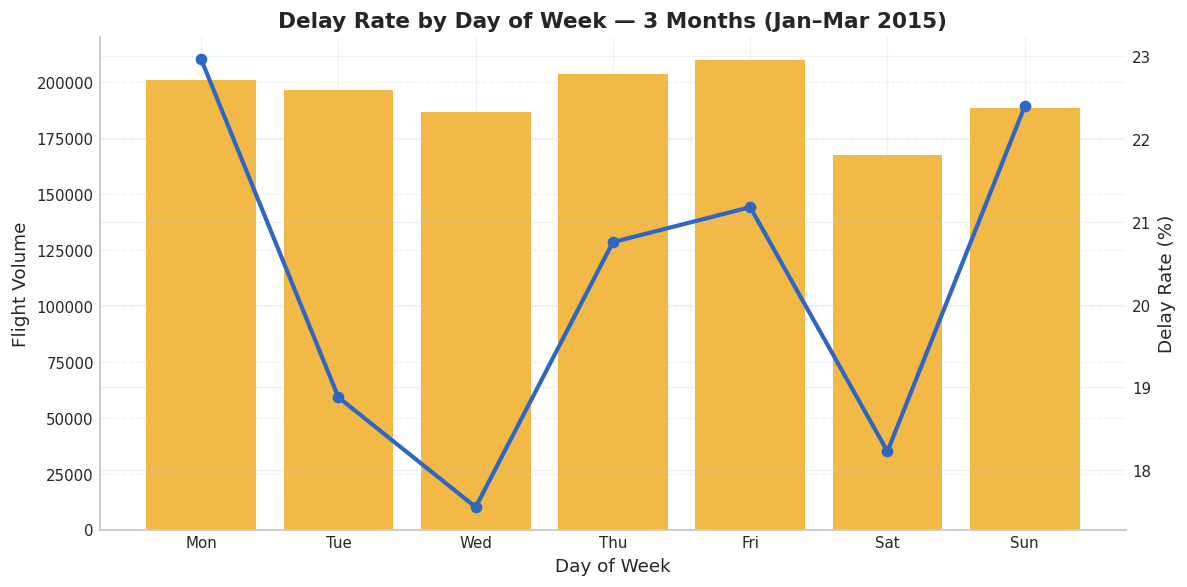

In [0]:
# ============================================================
# CELL — DELAY RATE BY DAY OF WEEK (12M vs 3M)
# bars = volume, line = DEP_DEL15 delay rate
# saves:
#   delay_rate_by_day_of_week_full.png
#   delay_rate_by_day_of_week_3m.png
# ============================================================

import pyspark.sql.functions as F
import matplotlib.pyplot as plt

BAR_COLOR  = "#f2b233"
LINE_COLOR = "#2f66c2"
TARGET_BIN = "DEP_DEL15"

DOW_ORDER = [1,2,3,4,5,6,7]  # Spark convention: 1=Mon ... 7=Sun
DOW_LABELS = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]

def save_fig(fig, filename):
    dbfs_path = f"{CHARTS_DBFS}/{filename}"
    fig.savefig(dbfs_path.replace("dbfs:/", "/dbfs/"), dpi=140, bbox_inches="tight")
    print(f"saved: {dbfs_path}")
    return dbfs_path

def plot_dow_delay_rate(df_in, title, filename):
    pdf = (
        df_in.groupBy("DAY_OF_WEEK")
             .agg(
                 F.count("*").alias("num_flights"),
                 (F.mean(TARGET_BIN)*100).alias("delay_rate_pct")
             )
             .orderBy("DAY_OF_WEEK")
             .toPandas()
    )

    # enforce order + labels
    pdf = pdf.set_index("DAY_OF_WEEK").reindex(DOW_ORDER).reset_index()
    pdf["dow_label"] = DOW_LABELS

    fig, ax1 = plt.subplots(figsize=(10,5))

    ax1.bar(pdf["dow_label"], pdf["num_flights"], color=BAR_COLOR, alpha=0.9)
    ax1.set_ylabel("Flight Volume")
    ax1.set_xlabel("Day of Week")

    ax2 = ax1.twinx()
    ax2.plot(pdf["dow_label"], pdf["delay_rate_pct"],
             color=LINE_COLOR, marker="o", linewidth=2.5)
    ax2.set_ylabel("Delay Rate (%)")

    ax1.set_title(title)
    ax1.grid(axis="y", linestyle="--", alpha=0.25)

    fig.tight_layout()
    save_fig(fig, filename)
    plt.show()


plot_dow_delay_rate(
    otpw_full_df,
    "Delay Rate by Day of Week — Full Year",
    "delay_rate_by_day_of_week_full.png"
)

plot_dow_delay_rate(
    otpw_3m_df,
    "Delay Rate by Day of Week — 3 Months (Jan–Mar 2015)",
    "delay_rate_by_day_of_week_3m.png"
)


In [0]:
df.columns


['FL_DATE',
 'OP_UNIQUE_CARRIER',
 'OP_CARRIER_FL_NUM',
 'ORIGIN',
 'DEST',
 'CRS_DEP_TIME',
 'ORIGIN_AIRPORT_ID',
 'departure_hour',
 'prediction_utc',
 'origin_obs_utc',
 'asof_minutes',
 'YEAR',
 'QUARTER',
 'DAY_OF_MONTH',
 'DAY_OF_WEEK',
 'CRS_ARR_TIME',
 'ORIGIN_STATE_ABR',
 'DEST_AIRPORT_ID',
 'DEST_STATE_ABR',
 'HourlyDewPointTemperature',
 'HourlyPrecipitation',
 'HourlyWindSpeed',
 'HourlyWindDirection',
 'HourlyWindGustSpeed',
 'HourlyVisibility',
 'HourlyRelativeHumidity',
 'HourlyAltimeterSetting',
 'origin_airport_lat',
 'origin_airport_lon',
 'dest_airport_lat',
 'dest_airport_lon',
 'origin_station_dis',
 'dest_station_dis',
 'origin_type',
 'dest_type',
 'DEP_DEL15',
 'CANCELLED',
 'CANCELLATION_CODE',
 'DIVERTED',
 'departure_month',
 'departure_dayofweek',
 'is_weekend',
 'season',
 'is_peak_hour',
 'is_peak_month',
 'time_of_day_early_morning',
 'time_of_day_morning',
 'time_of_day_afternoon',
 'time_of_day_evening',
 'time_of_day_night',
 'rolling_origin_num_delays

saved: dbfs:/student-groups/Group_4_4/Charts/phase2/HourlyWindSpeed_vs_delay_full.png
saved: dbfs:/student-groups/Group_4_4/Charts/phase2/HourlyWindSpeed_vs_delay_3m.png
saved: dbfs:/student-groups/Group_4_4/Charts/phase2/HourlyPrecipitation_vs_delay_full.png
saved: dbfs:/student-groups/Group_4_4/Charts/phase2/HourlyPrecipitation_vs_delay_3m.png
saved: dbfs:/student-groups/Group_4_4/Charts/phase2/HourlyVisibility_vs_delay_full.png
saved: dbfs:/student-groups/Group_4_4/Charts/phase2/HourlyVisibility_vs_delay_3m.png


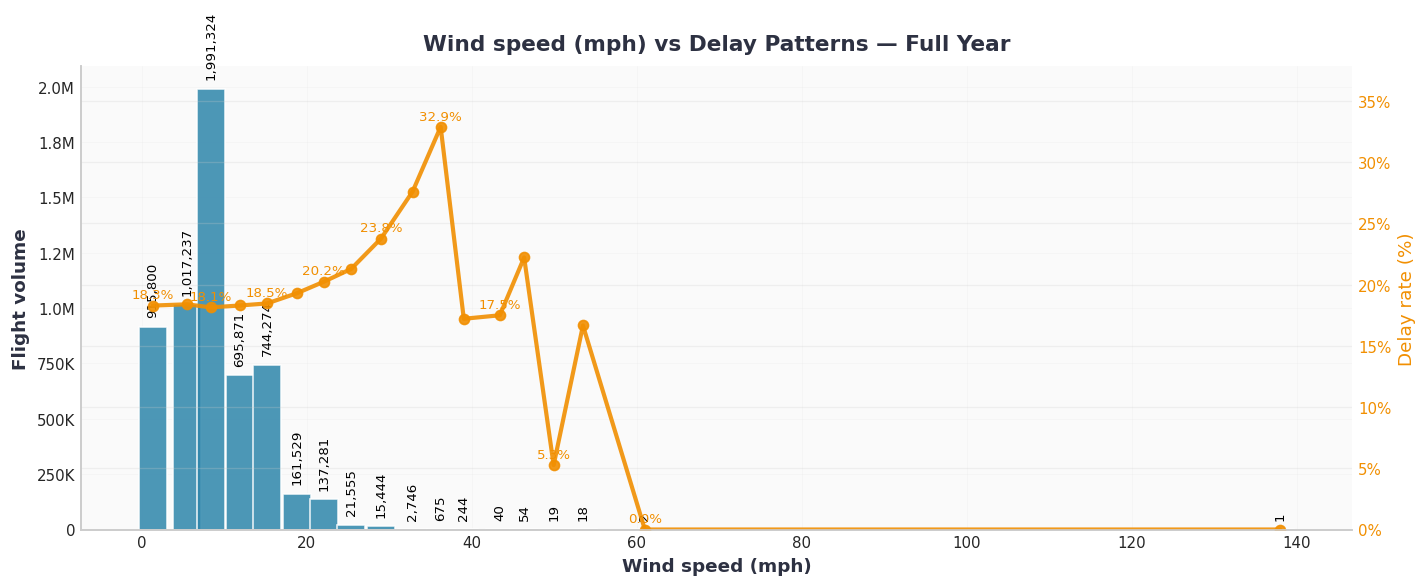

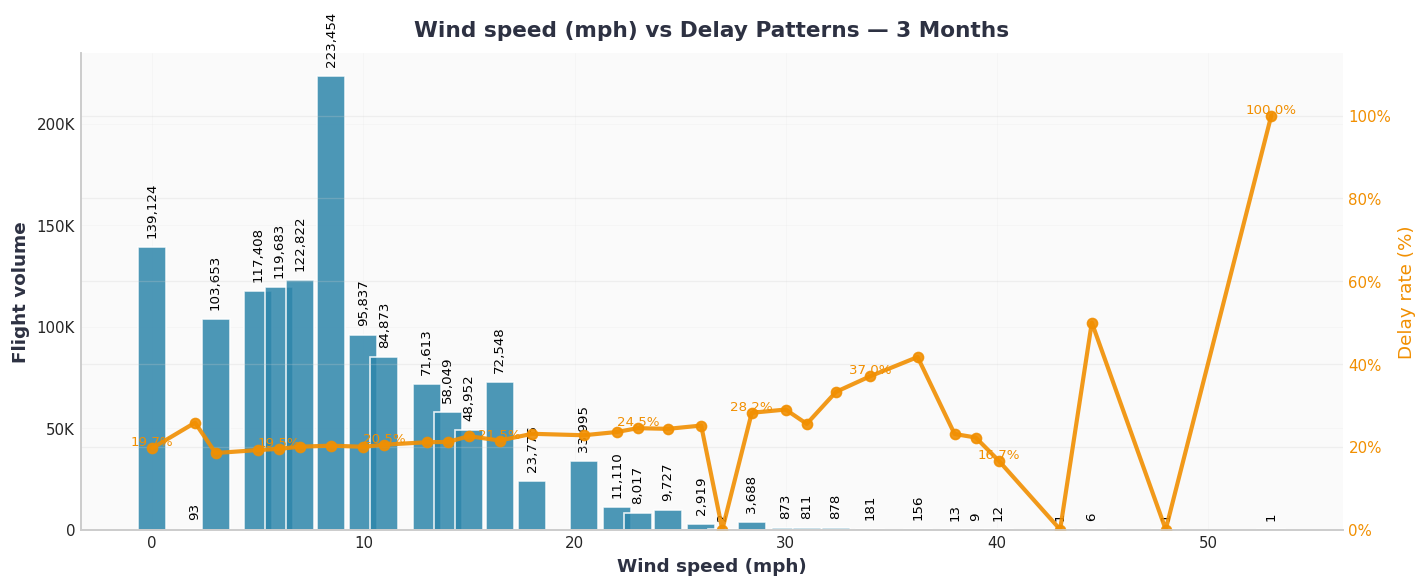

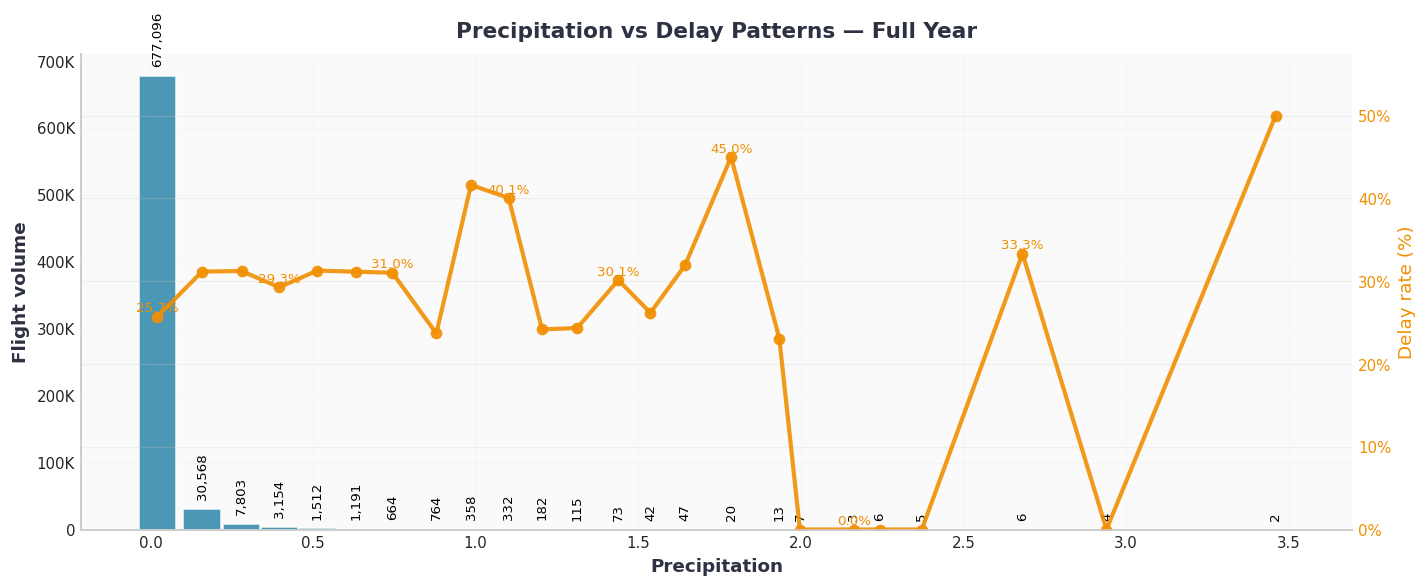

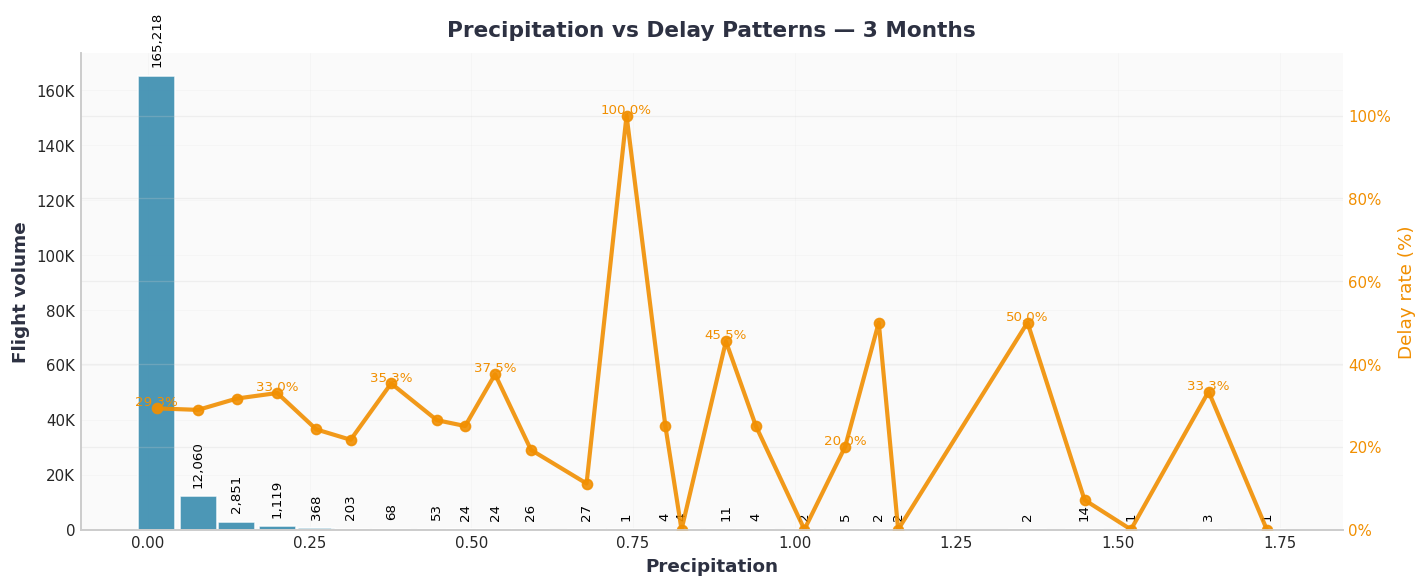

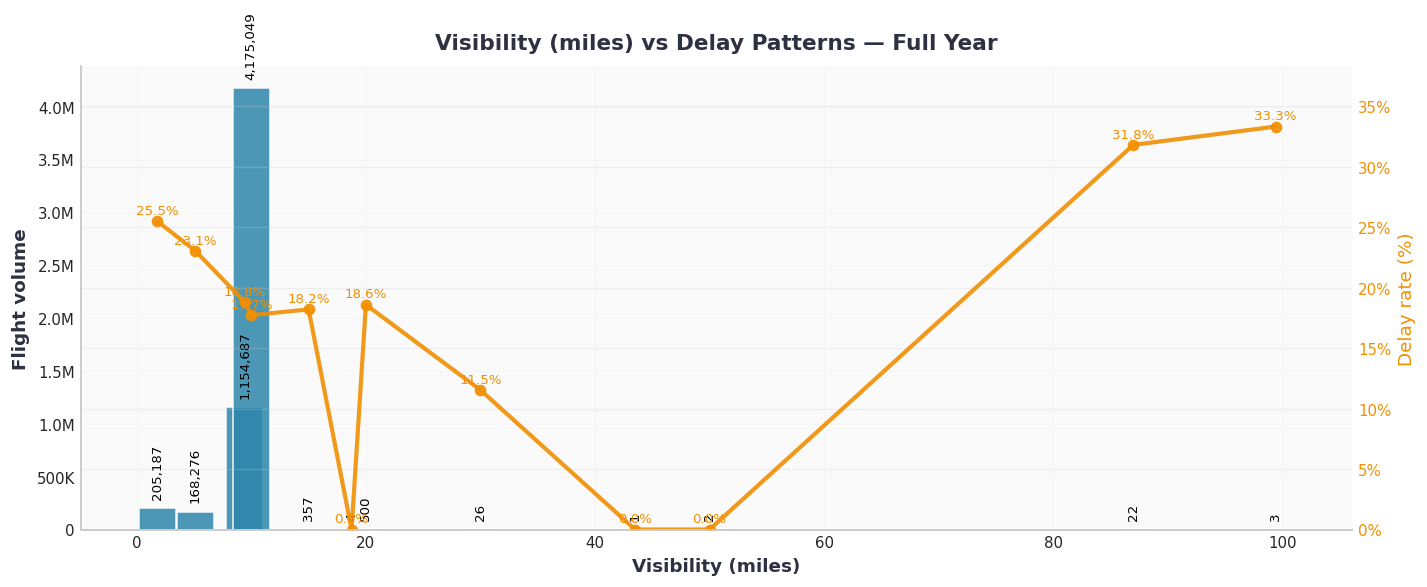

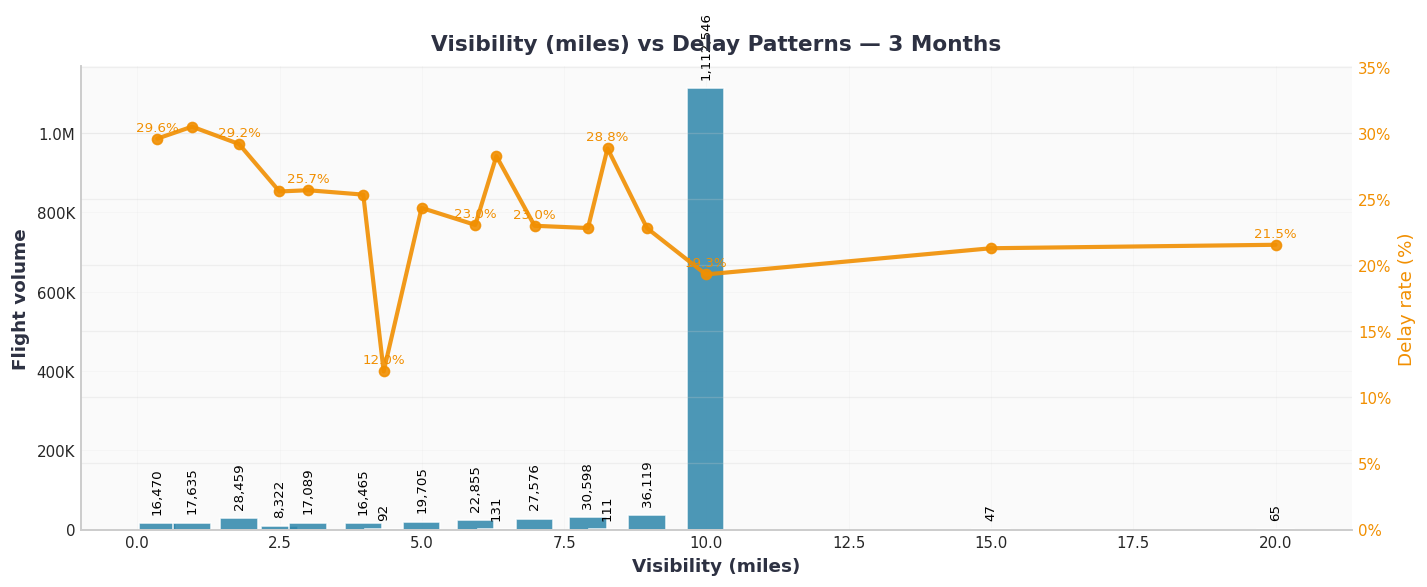

In [0]:
# ============================================================
# WEATHER EDA — TEMP / WIND / PRECIP / VISIBILITY
# Phase 2 aesthetics: blue bars, orange line
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_weather_binned_delay(
    df_in,
    col,
    col_label,
    title,
    filename,
    bins=40,
    min_bin_n=3000,
    drop_zero=False,
):
    """
    Generic Phase-2 style weather plot:
      - Bars (primary blue)  = flight volume per bin
      - Line (orange)        = DEP_DEL15 delay rate (%)

    Saves to CHARTS_DIR via save_fig().
    """
    if col not in df_in.columns:
        print(f"[skip] Column {col} not in dataframe")
        return None

    # Spark -> Pandas for this one column
    pdf = (
        df_in.select(col, TARGET_BIN)
             .dropna()
             .toPandas()
    )
    if pdf.empty:
        print(f"[skip] No data for {col}")
        return None

    if drop_zero:
        pdf = pdf[pdf[col] > 0]

    # Bin in pandas
    pdf["bin"] = pd.cut(pdf[col], bins=bins)

    grouped = (
        pdf.groupby("bin")
           .agg(
               n=("bin", "size"),
               delay_rate=(TARGET_BIN, "mean"),
               bin_center=(col, "mean"),
           )
           .dropna()
           .reset_index(drop=True)
    )
    if grouped.empty:
        print(f"[skip] No non-empty bins for {col}")
        return None

    delay_pct = grouped["delay_rate"] * 100

    # Approximate bar width
    bin_width = (grouped["bin_center"].max() - grouped["bin_center"].min()) / bins
    if not np.isfinite(bin_width) or bin_width <= 0:
        bin_width = max(1.0, grouped["bin_center"].std())

    fig, ax1 = plt.subplots(figsize=(12, 5), facecolor="white")

    # -----------------------------
    # Bars: flight volume (primary)
    # -----------------------------
    bars = ax1.bar(
        grouped["bin_center"],
        grouped["n"],
        width=bin_width,
        color=COLORS["primary"],
        alpha=0.85,
        edgecolor="white",
        linewidth=1,
    )

    style_axis(
        ax1,
        title=title,
        xlabel=col_label,
        ylabel="Flight volume",
        format_y_km=True,
    )

    # Value labels on bars
    add_bar_labels(
        ax1,
        bars,
        fmt="{:,.0f}",
        pad=0.02,
        rotation=90,
        fontsize=8,
    )

    # -----------------------------
    # Line: delay rate (%) (orange)
    # -----------------------------
    ax2 = ax1.twinx()
    ax2.plot(
        grouped["bin_center"],
        delay_pct,
        color=COLORS["warning"],
        marker="o",
        linewidth=2.5,
        alpha=0.9,
    )
    ax2.set_ylabel("Delay rate (%)", color=COLORS["warning"])
    ax2.tick_params(axis="y", labelcolor=COLORS["warning"])
    ax2.yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, p: f"{x:.0f}%")
    )
    ax2.set_ylim(0, max(35, delay_pct.max() * 1.15))

    # Label a subset of points to avoid clutter
    step = max(1, len(grouped) // 8)
    for _, r in grouped.iloc[::step].iterrows():
        ax2.text(
            r["bin_center"],
            r["delay_rate"] * 100 + 0.6,
            f"{r['delay_rate']*100:.1f}%",
            ha="center",
            fontsize=8,
            color=COLORS["warning"],
        )

    fig.tight_layout()
    return save_fig(fig, filename)

# ------------------------------------------------------------
# Run for key weather columns (full + 3m) if they exist
# ------------------------------------------------------------

weather_specs = [
    # col name              label                      bins   drop_zero
    ("HourlyWindSpeed",         "Wind speed (mph)",    40,    False),
    ("HourlyPrecipitation",     "Precipitation",       30,    True),
    ("HourlyVisibility",        "Visibility (miles)",  30,    False),
]

for col, label, bins, drop_zero in weather_specs:
    # Full year
    plot_weather_binned_delay(
        otpw_full_df,
        col=col,
        col_label=label,
        title=f"{label} vs Delay Patterns — Full Year",
        filename=f"{col}_vs_delay_full.png",
        bins=bins,
        drop_zero=drop_zero,
    )

    # 3-month sample
    plot_weather_binned_delay(
        otpw_3m_df,
        col=col,
        col_label=label,
        title=f"{label} vs Delay Patterns — 3 Months",
        filename=f"{col}_vs_delay_3m.png",
        bins=bins,
        drop_zero=drop_zero,
    )


saved: dbfs:/student-groups/Group_4_4/Charts/phase2/HourlyDewPointTemperature_vs_delay_full.png
saved: dbfs:/student-groups/Group_4_4/Charts/phase2/HourlyDewPointTemperature_vs_delay_3m.png
saved: dbfs:/student-groups/Group_4_4/Charts/phase2/HourlyWindSpeed_vs_delay_full.png
saved: dbfs:/student-groups/Group_4_4/Charts/phase2/HourlyWindSpeed_vs_delay_3m.png
saved: dbfs:/student-groups/Group_4_4/Charts/phase2/HourlyPrecipitation_vs_delay_full.png
saved: dbfs:/student-groups/Group_4_4/Charts/phase2/HourlyPrecipitation_vs_delay_3m.png
saved: dbfs:/student-groups/Group_4_4/Charts/phase2/HourlyVisibility_vs_delay_full.png
saved: dbfs:/student-groups/Group_4_4/Charts/phase2/HourlyVisibility_vs_delay_3m.png


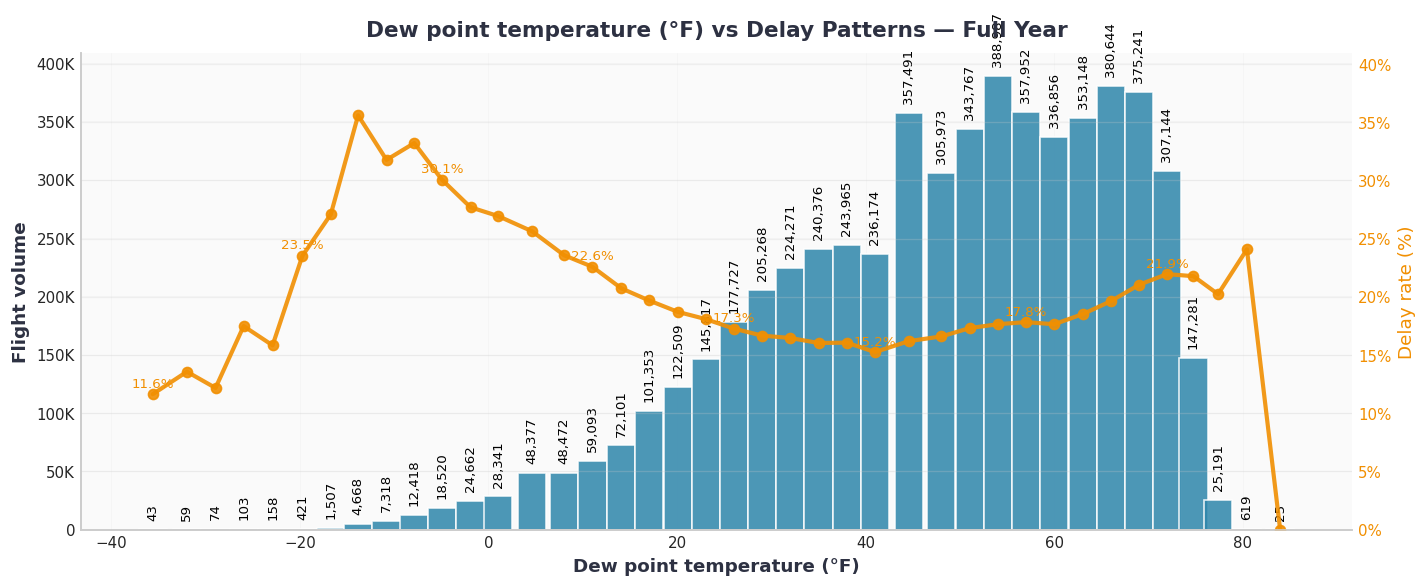

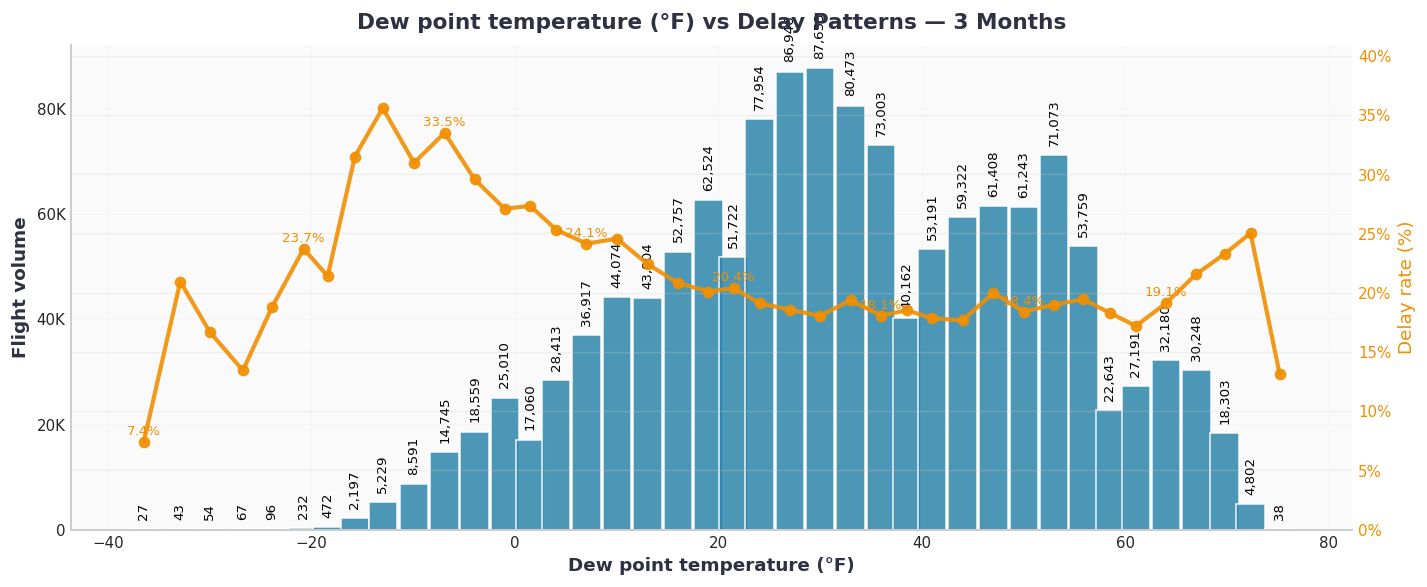

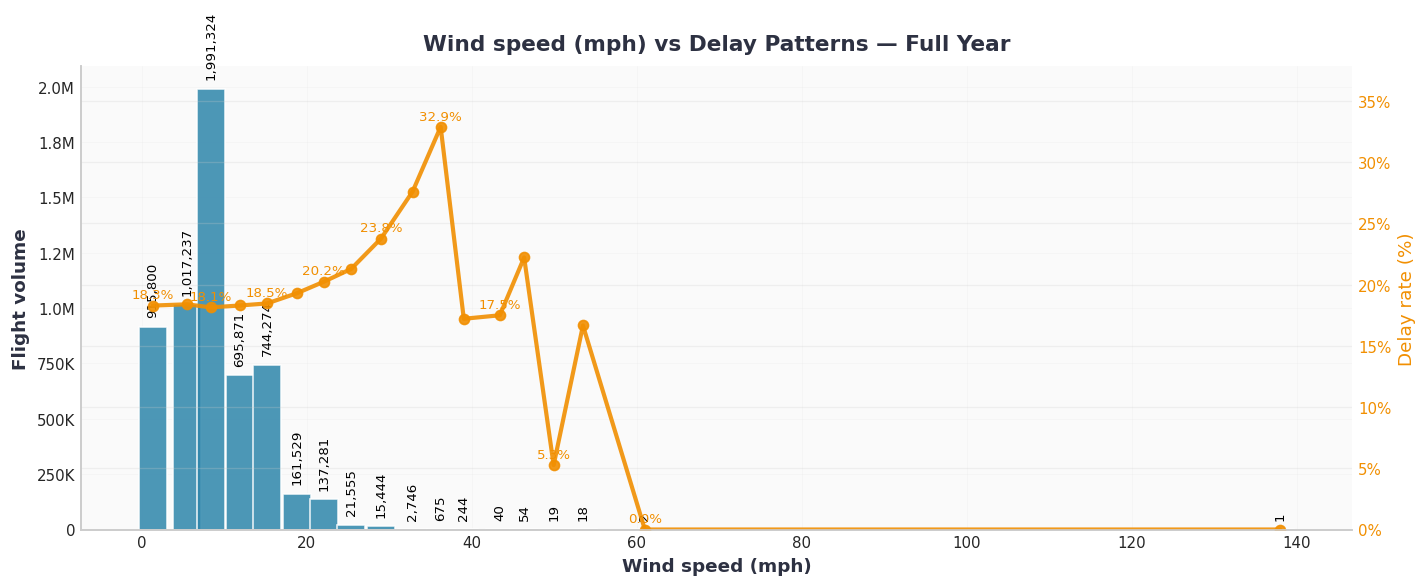

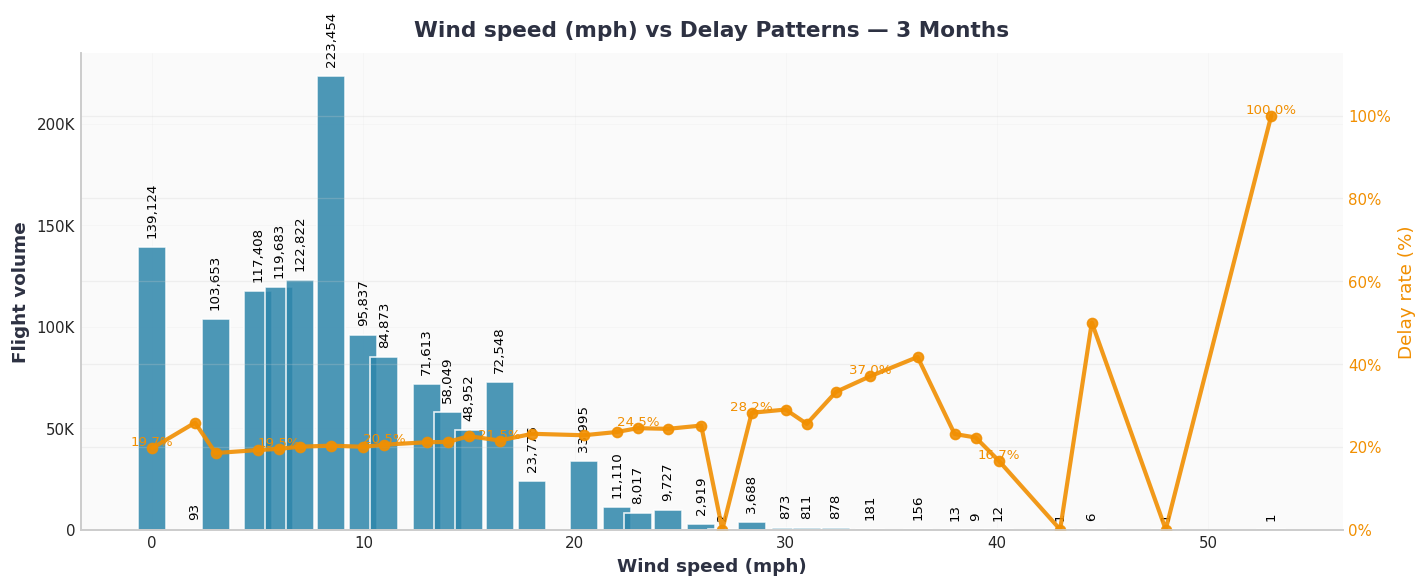

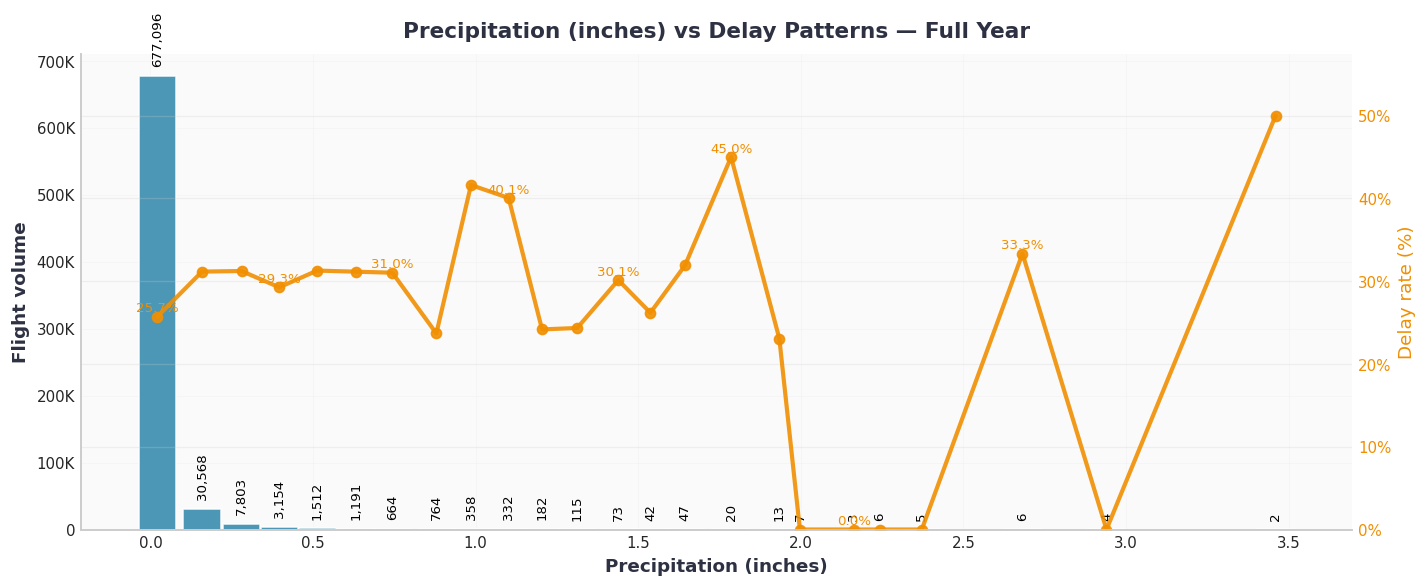

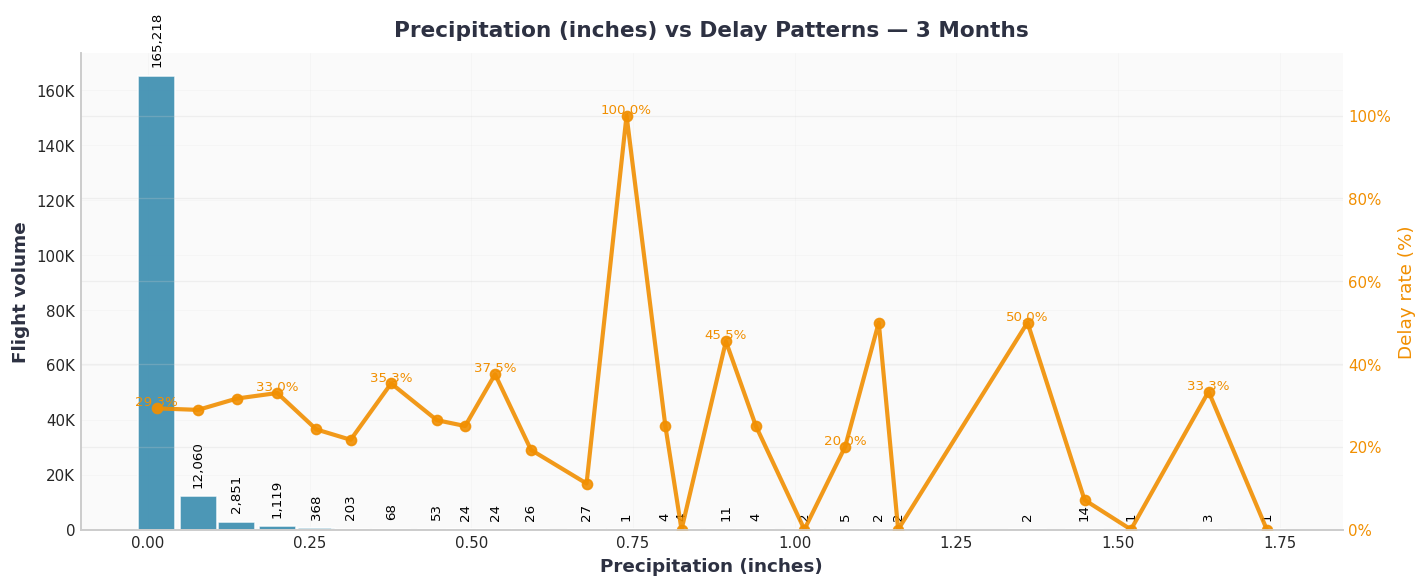

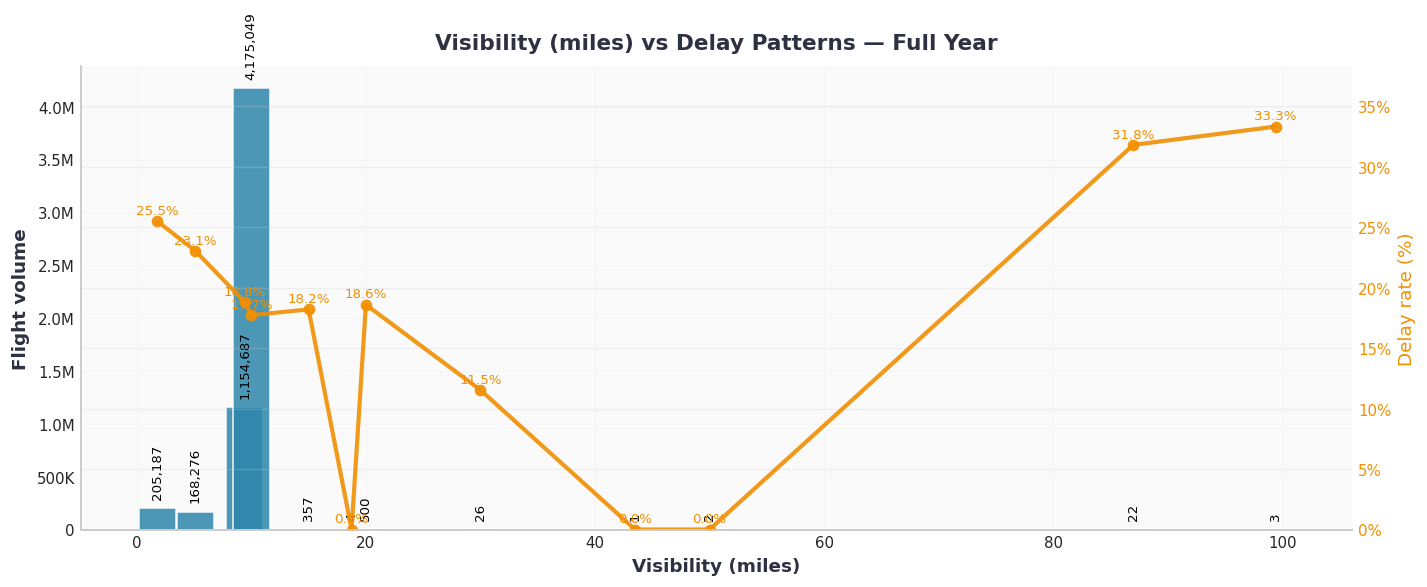

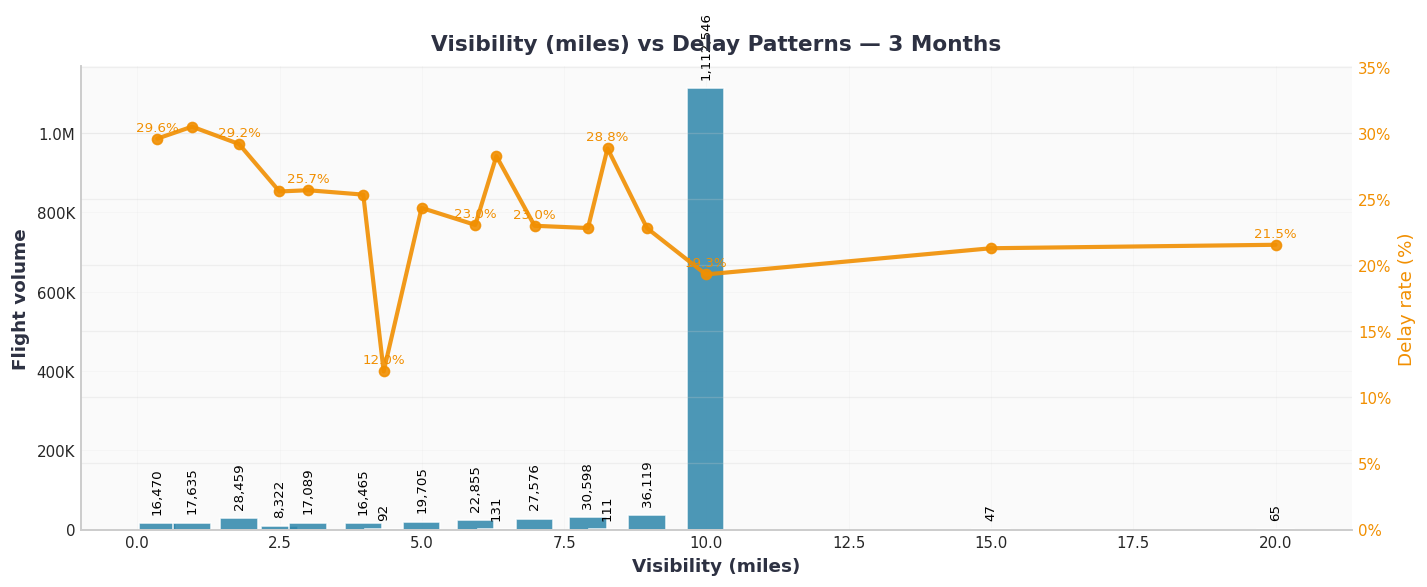

In [0]:
# ============================================================
# WEATHER EDA — TEMP / WIND / PRECIP / VISIBILITY
# Phase 2 aesthetics: blue bars, orange line
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_weather_binned_delay(
    df_in,
    col,
    col_label,
    title,
    filename,
    bins=40,
    min_bin_n=3000,
    drop_zero=False,
):
    """
    Generic Phase-2 style weather plot:
      - Bars (primary blue)  = flight volume per bin
      - Line (orange)        = DEP_DEL15 delay rate (%)

    Saves to CHARTS_DIR via save_fig().
    """
    if col not in df_in.columns:
        print(f"[skip] Column {col} not in dataframe")
        return None

    # Spark -> Pandas for this one column
    pdf = (
        df_in.select(col, TARGET_BIN)
             .dropna()
             .toPandas()
    )
    if pdf.empty:
        print(f"[skip] No data for {col}")
        return None

    if drop_zero:
        pdf = pdf[pdf[col] > 0]

    # Bin in pandas
    pdf["bin"] = pd.cut(pdf[col], bins=bins)

    grouped = (
        pdf.groupby("bin")
           .agg(
               n=("bin", "size"),
               delay_rate=(TARGET_BIN, "mean"),
               bin_center=(col, "mean"),
           )
           .dropna()
           .reset_index(drop=True)
    )
    if grouped.empty:
        print(f"[skip] No non-empty bins for {col}")
        return None

    delay_pct = grouped["delay_rate"] * 100

    # Approximate bar width
    bin_width = (grouped["bin_center"].max() - grouped["bin_center"].min()) / bins
    if not np.isfinite(bin_width) or bin_width <= 0:
        bin_width = max(1.0, grouped["bin_center"].std())

    fig, ax1 = plt.subplots(figsize=(12, 5), facecolor="white")

    # -----------------------------
    # Bars: flight volume (primary)
    # -----------------------------
    bars = ax1.bar(
        grouped["bin_center"],
        grouped["n"],
        width=bin_width,
        color=COLORS["primary"],
        alpha=0.85,
        edgecolor="white",
        linewidth=1,
    )

    style_axis(
        ax1,
        title=title,
        xlabel=col_label,
        ylabel="Flight volume",
        format_y_km=True,
    )

    # Value labels on bars
    add_bar_labels(
        ax1,
        bars,
        fmt="{:,.0f}",
        pad=0.02,
        rotation=90,
        fontsize=8,
    )

    # -----------------------------
    # Line: delay rate (%) (orange)
    # -----------------------------
    ax2 = ax1.twinx()
    ax2.plot(
        grouped["bin_center"],
        delay_pct,
        color=COLORS["warning"],
        marker="o",
        linewidth=2.5,
        alpha=0.9,
    )
    ax2.set_ylabel("Delay rate (%)", color=COLORS["warning"])
    ax2.tick_params(axis="y", labelcolor=COLORS["warning"])
    ax2.yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, p: f"{x:.0f}%")
    )
    ax2.set_ylim(0, max(35, delay_pct.max() * 1.15))

    # Label a subset of points to avoid clutter
    step = max(1, len(grouped) // 8)
    for _, r in grouped.iloc[::step].iterrows():
        ax2.text(
            r["bin_center"],
            r["delay_rate"] * 100 + 0.6,
            f"{r['delay_rate']*100:.1f}%",
            ha="center",
            fontsize=8,
            color=COLORS["warning"],
        )

    fig.tight_layout()
    return save_fig(fig, filename)

# ------------------------------------------------------------
# Run for key weather columns (full + 3m) if they exist
# ------------------------------------------------------------

weather_specs = [
    # col name                  label                          bins   drop_zero
    ("HourlyDewPointTemperature", "Dew point temperature (°F)", 40,    False),
    ("HourlyWindSpeed",           "Wind speed (mph)",           40,    False),
    ("HourlyPrecipitation",       "Precipitation (inches)",     30,    True),
    ("HourlyVisibility",          "Visibility (miles)",         30,    False),
]

for col, label, bins, drop_zero in weather_specs:
    # Full year
    plot_weather_binned_delay(
        otpw_full_df,
        col=col,
        col_label=label,
        title=f"{label} vs Delay Patterns — Full Year",
        filename=f"{col}_vs_delay_full.png",
        bins=bins,
        drop_zero=drop_zero,
    )

    # 3-month sample
    plot_weather_binned_delay(
        otpw_3m_df,
        col=col,
        col_label=label,
        title=f"{label} vs Delay Patterns — 3 Months",
        filename=f"{col}_vs_delay_3m.png",
        bins=bins,
        drop_zero=drop_zero,
    )
